In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "QPM_species"
model_name = "flow_mse"
ood = "0"

In [3]:
# Parameters
ood = 0


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 263794 images
Dataset type val label type: species


Loaded 33867 images
Dataset type test label type: species


Loaded 34090 images
Dataset type train label type: species


Loaded 111649 images
Dataset type val label type: species


Loaded 14695 images
Dataset type test label type: species


Loaded 14700 images


In [6]:
# model ids
model_ids = {"0": '3qdutcy1', "1": 'czgx4bod', "2": '72y7x1fk', "3": 'cqp59iho', "4": 'fwur6c78'}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

0 3qdutcy1


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                      | 0/4122 [00:00<?, ?it/s]

  0%|                                                                                              | 1/4122 [00:00<54:15,  1.27it/s]

  0%|                                                                                              | 3/4122 [00:00<17:14,  3.98it/s]

  0%|                                                                                              | 5/4122 [00:01<10:19,  6.65it/s]

  0%|▏                                                                                             | 7/4122 [00:01<07:33,  9.08it/s]

  0%|▏                                                                                             | 9/4122 [00:01<06:06, 11.23it/s]

  0%|▏                                                                                            | 11/4122 [00:01<05:16, 12.98it/s]

  0%|▎                                                                                            | 13/4122 [00:01<04:46, 14.35it/s]

  0%|▎                                                                                            | 15/4122 [00:01<04:26, 15.38it/s]

  0%|▍                                                                                            | 17/4122 [00:01<04:13, 16.18it/s]

  0%|▍                                                                                            | 19/4122 [00:01<04:04, 16.75it/s]

  1%|▍                                                                                            | 21/4122 [00:01<03:58, 17.18it/s]

  1%|▌                                                                                            | 23/4122 [00:02<03:54, 17.48it/s]

  1%|▌                                                                                            | 25/4122 [00:02<03:51, 17.67it/s]

  1%|▌                                                                                            | 27/4122 [00:02<03:49, 17.85it/s]

  1%|▋                                                                                            | 29/4122 [00:02<03:48, 17.94it/s]

  1%|▋                                                                                            | 31/4122 [00:02<03:46, 18.05it/s]

  1%|▋                                                                                            | 33/4122 [00:02<03:45, 18.12it/s]

  1%|▊                                                                                            | 35/4122 [00:02<03:44, 18.17it/s]

  1%|▊                                                                                            | 37/4122 [00:02<03:45, 18.14it/s]

  1%|▉                                                                                            | 39/4122 [00:02<03:47, 17.98it/s]

  1%|▉                                                                                            | 41/4122 [00:03<03:48, 17.89it/s]

  1%|▉                                                                                            | 43/4122 [00:03<03:47, 17.95it/s]

  1%|█                                                                                            | 45/4122 [00:03<03:45, 18.06it/s]

  1%|█                                                                                            | 47/4122 [00:03<03:44, 18.13it/s]

  1%|█                                                                                            | 49/4122 [00:03<03:44, 18.15it/s]

  1%|█▏                                                                                           | 51/4122 [00:03<03:44, 18.16it/s]

  1%|█▏                                                                                           | 53/4122 [00:03<03:43, 18.19it/s]

  1%|█▏                                                                                           | 55/4122 [00:03<03:43, 18.20it/s]

  1%|█▎                                                                                           | 57/4122 [00:03<03:43, 18.18it/s]

  1%|█▎                                                                                           | 59/4122 [00:03<03:43, 18.19it/s]

  1%|█▍                                                                                           | 61/4122 [00:04<03:42, 18.22it/s]

  2%|█▍                                                                                           | 63/4122 [00:04<03:42, 18.21it/s]

  2%|█▍                                                                                           | 65/4122 [00:04<03:42, 18.24it/s]

  2%|█▌                                                                                           | 67/4122 [00:04<03:42, 18.23it/s]

  2%|█▌                                                                                           | 69/4122 [00:04<03:41, 18.28it/s]

  2%|█▌                                                                                           | 71/4122 [00:04<03:41, 18.28it/s]

  2%|█▋                                                                                           | 73/4122 [00:04<03:41, 18.27it/s]

  2%|█▋                                                                                           | 75/4122 [00:04<03:41, 18.25it/s]

  2%|█▋                                                                                           | 77/4122 [00:04<03:41, 18.23it/s]

  2%|█▊                                                                                           | 79/4122 [00:05<03:42, 18.20it/s]

  2%|█▊                                                                                           | 81/4122 [00:05<03:41, 18.21it/s]

  2%|█▊                                                                                           | 83/4122 [00:05<03:41, 18.20it/s]

  2%|█▉                                                                                           | 85/4122 [00:05<03:42, 18.17it/s]

  2%|█▉                                                                                           | 87/4122 [00:05<03:42, 18.17it/s]

  2%|██                                                                                           | 89/4122 [00:05<03:41, 18.20it/s]

  2%|██                                                                                           | 91/4122 [00:05<03:41, 18.19it/s]

  2%|██                                                                                           | 93/4122 [00:05<03:41, 18.15it/s]

  2%|██▏                                                                                          | 95/4122 [00:05<03:41, 18.19it/s]

  2%|██▏                                                                                          | 97/4122 [00:06<03:41, 18.21it/s]

  2%|██▏                                                                                          | 99/4122 [00:06<03:40, 18.22it/s]

  2%|██▎                                                                                         | 101/4122 [00:06<03:40, 18.21it/s]

  2%|██▎                                                                                         | 103/4122 [00:06<03:41, 18.17it/s]

  3%|██▎                                                                                         | 105/4122 [00:06<03:40, 18.21it/s]

  3%|██▍                                                                                         | 107/4122 [00:06<03:40, 18.21it/s]

  3%|██▍                                                                                         | 109/4122 [00:06<03:40, 18.20it/s]

  3%|██▍                                                                                         | 111/4122 [00:06<03:40, 18.17it/s]

  3%|██▌                                                                                         | 113/4122 [00:06<03:41, 18.14it/s]

  3%|██▌                                                                                         | 115/4122 [00:07<03:40, 18.15it/s]

  3%|██▌                                                                                         | 117/4122 [00:07<03:40, 18.15it/s]

  3%|██▋                                                                                         | 119/4122 [00:07<03:40, 18.15it/s]

  3%|██▋                                                                                         | 121/4122 [00:07<03:40, 18.15it/s]

  3%|██▋                                                                                         | 123/4122 [00:07<03:40, 18.16it/s]

  3%|██▊                                                                                         | 125/4122 [00:07<03:40, 18.16it/s]

  3%|██▊                                                                                         | 127/4122 [00:07<03:39, 18.18it/s]

  3%|██▉                                                                                         | 129/4122 [00:07<03:39, 18.18it/s]

  3%|██▉                                                                                         | 131/4122 [00:07<03:39, 18.19it/s]

  3%|██▉                                                                                         | 133/4122 [00:08<03:38, 18.22it/s]

  3%|███                                                                                         | 135/4122 [00:08<03:39, 18.19it/s]

  3%|███                                                                                         | 137/4122 [00:08<03:39, 18.15it/s]

  3%|███                                                                                         | 139/4122 [00:08<03:39, 18.16it/s]

  3%|███▏                                                                                        | 141/4122 [00:08<03:39, 18.16it/s]

  3%|███▏                                                                                        | 143/4122 [00:08<03:38, 18.18it/s]

  4%|███▏                                                                                        | 145/4122 [00:08<03:38, 18.16it/s]

  4%|███▎                                                                                        | 147/4122 [00:08<03:38, 18.16it/s]

  4%|███▎                                                                                        | 149/4122 [00:08<03:37, 18.23it/s]

  4%|███▎                                                                                        | 151/4122 [00:09<03:38, 18.21it/s]

  4%|███▍                                                                                        | 153/4122 [00:09<03:38, 18.19it/s]

  4%|███▍                                                                                        | 155/4122 [00:09<03:38, 18.18it/s]

  4%|███▌                                                                                        | 157/4122 [00:09<03:38, 18.17it/s]

  4%|███▌                                                                                        | 159/4122 [00:09<03:38, 18.16it/s]

  4%|███▌                                                                                        | 161/4122 [00:09<03:37, 18.17it/s]

  4%|███▋                                                                                        | 163/4122 [00:09<03:37, 18.17it/s]

  4%|███▋                                                                                        | 165/4122 [00:09<03:37, 18.17it/s]

  4%|███▋                                                                                        | 167/4122 [00:09<03:37, 18.18it/s]

  4%|███▊                                                                                        | 169/4122 [00:10<03:37, 18.21it/s]

  4%|███▊                                                                                        | 171/4122 [00:10<03:37, 18.20it/s]

  4%|███▊                                                                                        | 173/4122 [00:10<03:36, 18.20it/s]

  4%|███▉                                                                                        | 175/4122 [00:10<03:36, 18.19it/s]

  4%|███▉                                                                                        | 177/4122 [00:10<03:36, 18.18it/s]

  4%|███▉                                                                                        | 179/4122 [00:10<03:36, 18.20it/s]

  4%|████                                                                                        | 181/4122 [00:10<03:36, 18.19it/s]

  4%|████                                                                                        | 183/4122 [00:10<03:36, 18.20it/s]

  4%|████▏                                                                                       | 185/4122 [00:10<03:36, 18.22it/s]

  5%|████▏                                                                                       | 187/4122 [00:11<03:36, 18.21it/s]

  5%|████▏                                                                                       | 189/4122 [00:11<03:36, 18.19it/s]

  5%|████▎                                                                                       | 191/4122 [00:11<03:36, 18.19it/s]

  5%|████▎                                                                                       | 193/4122 [00:11<03:36, 18.16it/s]

  5%|████▎                                                                                       | 195/4122 [00:11<03:36, 18.17it/s]

  5%|████▍                                                                                       | 197/4122 [00:11<03:36, 18.16it/s]

  5%|████▍                                                                                       | 199/4122 [00:11<03:35, 18.17it/s]

  5%|████▍                                                                                       | 201/4122 [00:11<03:35, 18.20it/s]

  5%|████▌                                                                                       | 203/4122 [00:11<03:35, 18.19it/s]

  5%|████▌                                                                                       | 205/4122 [00:12<03:35, 18.17it/s]

  5%|████▌                                                                                       | 207/4122 [00:12<03:35, 18.16it/s]

  5%|████▋                                                                                       | 209/4122 [00:12<03:34, 18.20it/s]

  5%|████▋                                                                                       | 211/4122 [00:12<03:34, 18.22it/s]

  5%|████▊                                                                                       | 213/4122 [00:12<03:34, 18.22it/s]

  5%|████▊                                                                                       | 215/4122 [00:12<03:34, 18.21it/s]

  5%|████▊                                                                                       | 217/4122 [00:12<03:34, 18.18it/s]

  5%|████▉                                                                                       | 219/4122 [00:12<03:34, 18.17it/s]

  5%|████▉                                                                                       | 221/4122 [00:12<03:34, 18.19it/s]

  5%|████▉                                                                                       | 223/4122 [00:13<03:34, 18.21it/s]

  5%|█████                                                                                       | 225/4122 [00:13<03:33, 18.21it/s]

  6%|█████                                                                                       | 227/4122 [00:13<03:34, 18.19it/s]

  6%|█████                                                                                       | 229/4122 [00:13<03:33, 18.20it/s]

  6%|█████▏                                                                                      | 231/4122 [00:13<03:33, 18.20it/s]

  6%|█████▏                                                                                      | 233/4122 [00:13<03:33, 18.20it/s]

  6%|█████▏                                                                                      | 235/4122 [00:13<03:33, 18.19it/s]

  6%|█████▎                                                                                      | 237/4122 [00:13<03:33, 18.17it/s]

  6%|█████▎                                                                                      | 239/4122 [00:13<03:33, 18.19it/s]

  6%|█████▍                                                                                      | 241/4122 [00:14<03:33, 18.21it/s]

  6%|█████▍                                                                                      | 243/4122 [00:14<03:33, 18.20it/s]

  6%|█████▍                                                                                      | 245/4122 [00:14<03:33, 18.19it/s]

  6%|█████▌                                                                                      | 247/4122 [00:14<03:32, 18.23it/s]

  6%|█████▌                                                                                      | 249/4122 [00:14<03:32, 18.22it/s]

  6%|█████▌                                                                                      | 251/4122 [00:14<03:32, 18.24it/s]

  6%|█████▋                                                                                      | 253/4122 [00:14<03:32, 18.21it/s]

  6%|█████▋                                                                                      | 255/4122 [00:14<03:32, 18.23it/s]

  6%|█████▋                                                                                      | 257/4122 [00:14<03:32, 18.22it/s]

  6%|█████▊                                                                                      | 259/4122 [00:14<03:31, 18.24it/s]

  6%|█████▊                                                                                      | 261/4122 [00:15<03:31, 18.22it/s]

  6%|█████▊                                                                                      | 263/4122 [00:15<03:31, 18.25it/s]

  6%|█████▉                                                                                      | 265/4122 [00:15<03:31, 18.26it/s]

  6%|█████▉                                                                                      | 267/4122 [00:15<03:31, 18.24it/s]

  7%|██████                                                                                      | 269/4122 [00:15<03:31, 18.20it/s]

  7%|██████                                                                                      | 271/4122 [00:15<03:31, 18.18it/s]

  7%|██████                                                                                      | 273/4122 [00:15<03:31, 18.19it/s]

  7%|██████▏                                                                                     | 275/4122 [00:15<03:31, 18.22it/s]

  7%|██████▏                                                                                     | 277/4122 [00:15<03:31, 18.22it/s]

  7%|██████▏                                                                                     | 279/4122 [00:16<03:30, 18.23it/s]

  7%|██████▎                                                                                     | 281/4122 [00:16<03:30, 18.24it/s]

  7%|██████▎                                                                                     | 283/4122 [00:16<03:30, 18.27it/s]

  7%|██████▎                                                                                     | 285/4122 [00:16<03:30, 18.25it/s]

  7%|██████▍                                                                                     | 287/4122 [00:16<03:30, 18.22it/s]

  7%|██████▍                                                                                     | 289/4122 [00:16<03:32, 18.00it/s]

  7%|██████▍                                                                                     | 291/4122 [00:16<03:32, 18.06it/s]

  7%|██████▌                                                                                     | 293/4122 [00:16<03:31, 18.10it/s]

  7%|██████▌                                                                                     | 295/4122 [00:16<03:30, 18.14it/s]

  7%|██████▋                                                                                     | 297/4122 [00:17<03:30, 18.17it/s]

  7%|██████▋                                                                                     | 299/4122 [00:17<03:30, 18.17it/s]

  7%|██████▋                                                                                     | 301/4122 [00:17<03:29, 18.23it/s]

  7%|██████▊                                                                                     | 303/4122 [00:17<03:29, 18.24it/s]

  7%|██████▊                                                                                     | 305/4122 [00:17<03:28, 18.28it/s]

  7%|██████▊                                                                                     | 307/4122 [00:17<03:28, 18.26it/s]

  7%|██████▉                                                                                     | 309/4122 [00:17<03:28, 18.25it/s]

  8%|██████▉                                                                                     | 311/4122 [00:17<03:28, 18.24it/s]

  8%|██████▉                                                                                     | 313/4122 [00:17<03:28, 18.25it/s]

  8%|███████                                                                                     | 315/4122 [00:18<03:28, 18.28it/s]

  8%|███████                                                                                     | 317/4122 [00:18<03:28, 18.27it/s]

  8%|███████                                                                                     | 319/4122 [00:18<03:28, 18.25it/s]

  8%|███████▏                                                                                    | 321/4122 [00:18<03:28, 18.23it/s]

  8%|███████▏                                                                                    | 323/4122 [00:18<03:27, 18.27it/s]

  8%|███████▎                                                                                    | 325/4122 [00:18<03:27, 18.27it/s]

  8%|███████▎                                                                                    | 327/4122 [00:18<03:27, 18.25it/s]

  8%|███████▎                                                                                    | 329/4122 [00:18<03:28, 18.21it/s]

  8%|███████▍                                                                                    | 331/4122 [00:18<03:28, 18.20it/s]

  8%|███████▍                                                                                    | 333/4122 [00:19<03:28, 18.19it/s]

  8%|███████▍                                                                                    | 335/4122 [00:19<03:28, 18.17it/s]

  8%|███████▌                                                                                    | 337/4122 [00:19<03:28, 18.19it/s]

  8%|███████▌                                                                                    | 339/4122 [00:19<03:27, 18.22it/s]

  8%|███████▌                                                                                    | 341/4122 [00:19<03:27, 18.24it/s]

  8%|███████▋                                                                                    | 343/4122 [00:19<03:26, 18.26it/s]

  8%|███████▋                                                                                    | 345/4122 [00:19<03:26, 18.26it/s]

  8%|███████▋                                                                                    | 347/4122 [00:19<03:26, 18.25it/s]

  8%|███████▊                                                                                    | 349/4122 [00:19<03:25, 18.32it/s]

  9%|███████▊                                                                                    | 351/4122 [00:20<03:25, 18.33it/s]

  9%|███████▉                                                                                    | 353/4122 [00:20<03:25, 18.32it/s]

  9%|███████▉                                                                                    | 355/4122 [00:20<03:25, 18.30it/s]

  9%|███████▉                                                                                    | 357/4122 [00:20<03:25, 18.30it/s]

  9%|████████                                                                                    | 359/4122 [00:20<03:25, 18.29it/s]

  9%|████████                                                                                    | 361/4122 [00:20<03:25, 18.27it/s]

  9%|████████                                                                                    | 363/4122 [00:20<03:25, 18.28it/s]

  9%|████████▏                                                                                   | 365/4122 [00:20<03:25, 18.25it/s]

  9%|████████▏                                                                                   | 367/4122 [00:20<03:25, 18.26it/s]

  9%|████████▏                                                                                   | 369/4122 [00:21<03:25, 18.28it/s]

  9%|████████▎                                                                                   | 371/4122 [00:21<03:25, 18.25it/s]

  9%|████████▎                                                                                   | 373/4122 [00:21<03:25, 18.24it/s]

  9%|████████▎                                                                                   | 375/4122 [00:21<03:25, 18.26it/s]

  9%|████████▍                                                                                   | 377/4122 [00:21<03:25, 18.26it/s]

  9%|████████▍                                                                                   | 379/4122 [00:21<03:24, 18.27it/s]

  9%|████████▌                                                                                   | 381/4122 [00:21<03:24, 18.28it/s]

  9%|████████▌                                                                                   | 383/4122 [00:21<03:24, 18.27it/s]

  9%|████████▌                                                                                   | 385/4122 [00:21<03:24, 18.28it/s]

  9%|████████▋                                                                                   | 387/4122 [00:22<03:24, 18.29it/s]

  9%|████████▋                                                                                   | 389/4122 [00:22<03:24, 18.29it/s]

  9%|████████▋                                                                                   | 391/4122 [00:22<03:24, 18.27it/s]

 10%|████████▊                                                                                   | 393/4122 [00:22<03:23, 18.32it/s]

 10%|████████▊                                                                                   | 395/4122 [00:22<03:23, 18.28it/s]

 10%|████████▊                                                                                   | 397/4122 [00:22<03:23, 18.28it/s]

 10%|████████▉                                                                                   | 399/4122 [00:22<03:23, 18.29it/s]

 10%|████████▉                                                                                   | 401/4122 [00:22<03:23, 18.28it/s]

 10%|████████▉                                                                                   | 403/4122 [00:22<03:23, 18.25it/s]

 10%|█████████                                                                                   | 405/4122 [00:22<03:23, 18.28it/s]

 10%|█████████                                                                                   | 407/4122 [00:23<03:23, 18.29it/s]

 10%|█████████▏                                                                                  | 409/4122 [00:23<03:23, 18.29it/s]

 10%|█████████▏                                                                                  | 411/4122 [00:23<03:23, 18.26it/s]

 10%|█████████▏                                                                                  | 413/4122 [00:23<03:23, 18.24it/s]

 10%|█████████▎                                                                                  | 415/4122 [00:23<03:23, 18.26it/s]

 10%|█████████▎                                                                                  | 417/4122 [00:23<03:22, 18.26it/s]

 10%|█████████▎                                                                                  | 419/4122 [00:23<03:22, 18.25it/s]

 10%|█████████▍                                                                                  | 421/4122 [00:23<03:22, 18.29it/s]

 10%|█████████▍                                                                                  | 423/4122 [00:23<03:22, 18.29it/s]

 10%|█████████▍                                                                                  | 425/4122 [00:24<03:22, 18.28it/s]

 10%|█████████▌                                                                                  | 427/4122 [00:24<03:22, 18.29it/s]

 10%|█████████▌                                                                                  | 429/4122 [00:24<03:21, 18.29it/s]

 10%|█████████▌                                                                                  | 431/4122 [00:24<03:21, 18.29it/s]

 11%|█████████▋                                                                                  | 433/4122 [00:24<03:21, 18.31it/s]

 11%|█████████▋                                                                                  | 435/4122 [00:24<03:21, 18.30it/s]

 11%|█████████▊                                                                                  | 437/4122 [00:24<03:22, 18.23it/s]

 11%|█████████▊                                                                                  | 439/4122 [00:24<03:22, 18.23it/s]

 11%|█████████▊                                                                                  | 441/4122 [00:24<03:21, 18.27it/s]

 11%|█████████▉                                                                                  | 443/4122 [00:25<03:21, 18.30it/s]

 11%|█████████▉                                                                                  | 445/4122 [00:25<03:20, 18.30it/s]

 11%|█████████▉                                                                                  | 447/4122 [00:25<03:21, 18.28it/s]

 11%|██████████                                                                                  | 449/4122 [00:25<03:20, 18.30it/s]

 11%|██████████                                                                                  | 451/4122 [00:25<03:20, 18.26it/s]

 11%|██████████                                                                                  | 453/4122 [00:25<03:21, 18.24it/s]

 11%|██████████▏                                                                                 | 455/4122 [00:25<03:21, 18.23it/s]

 11%|██████████▏                                                                                 | 457/4122 [00:25<03:20, 18.25it/s]

 11%|██████████▏                                                                                 | 459/4122 [00:25<03:20, 18.25it/s]

 11%|██████████▎                                                                                 | 461/4122 [00:26<03:20, 18.29it/s]

 11%|██████████▎                                                                                 | 463/4122 [00:26<03:19, 18.30it/s]

 11%|██████████▍                                                                                 | 465/4122 [00:26<03:20, 18.27it/s]

 11%|██████████▍                                                                                 | 467/4122 [00:26<03:19, 18.28it/s]

 11%|██████████▍                                                                                 | 469/4122 [00:26<03:19, 18.27it/s]

 11%|██████████▌                                                                                 | 471/4122 [00:26<03:19, 18.28it/s]

 11%|██████████▌                                                                                 | 473/4122 [00:26<03:19, 18.30it/s]

 12%|██████████▌                                                                                 | 475/4122 [00:26<03:19, 18.26it/s]

 12%|██████████▋                                                                                 | 477/4122 [00:26<03:19, 18.27it/s]

 12%|██████████▋                                                                                 | 479/4122 [00:27<03:19, 18.26it/s]

 12%|██████████▋                                                                                 | 481/4122 [00:27<03:19, 18.23it/s]

 12%|██████████▊                                                                                 | 483/4122 [00:27<03:19, 18.25it/s]

 12%|██████████▊                                                                                 | 485/4122 [00:27<03:19, 18.25it/s]

 12%|██████████▊                                                                                 | 487/4122 [00:27<03:19, 18.25it/s]

 12%|██████████▉                                                                                 | 489/4122 [00:27<03:18, 18.26it/s]

 12%|██████████▉                                                                                 | 491/4122 [00:27<03:19, 18.23it/s]

 12%|███████████                                                                                 | 493/4122 [00:27<03:19, 18.22it/s]

 12%|███████████                                                                                 | 495/4122 [00:27<03:19, 18.19it/s]

 12%|███████████                                                                                 | 497/4122 [00:28<03:19, 18.16it/s]

 12%|███████████▏                                                                                | 499/4122 [00:28<03:19, 18.17it/s]

 12%|███████████▏                                                                                | 501/4122 [00:28<03:19, 18.19it/s]

 12%|███████████▏                                                                                | 503/4122 [00:28<03:19, 18.18it/s]

 12%|███████████▎                                                                                | 505/4122 [00:28<03:18, 18.23it/s]

 12%|███████████▎                                                                                | 507/4122 [00:28<03:17, 18.26it/s]

 12%|███████████▎                                                                                | 509/4122 [00:28<03:17, 18.25it/s]

 12%|███████████▍                                                                                | 511/4122 [00:28<03:18, 18.21it/s]

 12%|███████████▍                                                                                | 513/4122 [00:28<03:18, 18.22it/s]

 12%|███████████▍                                                                                | 515/4122 [00:29<03:18, 18.21it/s]

 13%|███████████▌                                                                                | 517/4122 [00:29<03:17, 18.22it/s]

 13%|███████████▌                                                                                | 519/4122 [00:29<03:17, 18.21it/s]

 13%|███████████▋                                                                                | 521/4122 [00:29<03:17, 18.19it/s]

 13%|███████████▋                                                                                | 523/4122 [00:29<03:17, 18.18it/s]

 13%|███████████▋                                                                                | 525/4122 [00:29<03:16, 18.26it/s]

 13%|███████████▊                                                                                | 527/4122 [00:29<03:17, 18.24it/s]

 13%|███████████▊                                                                                | 529/4122 [00:29<03:16, 18.26it/s]

 13%|███████████▊                                                                                | 531/4122 [00:29<03:16, 18.27it/s]

 13%|███████████▉                                                                                | 533/4122 [00:30<03:16, 18.26it/s]

 13%|███████████▉                                                                                | 535/4122 [00:30<03:16, 18.24it/s]

 13%|███████████▉                                                                                | 537/4122 [00:30<03:16, 18.21it/s]

 13%|████████████                                                                                | 539/4122 [00:30<03:16, 18.20it/s]

 13%|████████████                                                                                | 541/4122 [00:30<03:16, 18.21it/s]

 13%|████████████                                                                                | 543/4122 [00:30<03:16, 18.21it/s]

 13%|████████████▏                                                                               | 545/4122 [00:30<03:15, 18.26it/s]

 13%|████████████▏                                                                               | 547/4122 [00:30<03:15, 18.24it/s]

 13%|████████████▎                                                                               | 549/4122 [00:30<03:15, 18.24it/s]

 13%|████████████▎                                                                               | 551/4122 [00:30<03:15, 18.22it/s]

 13%|████████████▎                                                                               | 553/4122 [00:31<03:15, 18.27it/s]

 13%|████████████▍                                                                               | 555/4122 [00:31<03:15, 18.25it/s]

 14%|████████████▍                                                                               | 557/4122 [00:31<03:15, 18.23it/s]

 14%|████████████▍                                                                               | 559/4122 [00:31<03:15, 18.21it/s]

 14%|████████████▌                                                                               | 561/4122 [00:31<03:15, 18.22it/s]

 14%|████████████▌                                                                               | 563/4122 [00:31<03:15, 18.23it/s]

 14%|████████████▌                                                                               | 565/4122 [00:31<03:15, 18.23it/s]

 14%|████████████▋                                                                               | 567/4122 [00:31<03:14, 18.25it/s]

 14%|████████████▋                                                                               | 569/4122 [00:31<03:14, 18.28it/s]

 14%|████████████▋                                                                               | 571/4122 [00:32<03:14, 18.26it/s]

 14%|████████████▊                                                                               | 573/4122 [00:32<03:14, 18.23it/s]

 14%|████████████▊                                                                               | 575/4122 [00:32<03:14, 18.25it/s]

 14%|████████████▉                                                                               | 577/4122 [00:32<03:14, 18.24it/s]

 14%|████████████▉                                                                               | 579/4122 [00:32<03:14, 18.21it/s]

 14%|████████████▉                                                                               | 581/4122 [00:32<03:14, 18.19it/s]

 14%|█████████████                                                                               | 583/4122 [00:32<03:14, 18.22it/s]

 14%|█████████████                                                                               | 585/4122 [00:32<03:13, 18.27it/s]

 14%|█████████████                                                                               | 587/4122 [00:32<03:13, 18.27it/s]

 14%|█████████████▏                                                                              | 589/4122 [00:33<03:13, 18.25it/s]

 14%|█████████████▏                                                                              | 591/4122 [00:33<03:13, 18.24it/s]

 14%|█████████████▏                                                                              | 593/4122 [00:33<03:14, 18.12it/s]

 14%|█████████████▎                                                                              | 595/4122 [00:33<03:15, 18.06it/s]

 14%|█████████████▎                                                                              | 597/4122 [00:33<03:15, 18.02it/s]

 15%|█████████████▎                                                                              | 599/4122 [00:33<03:16, 17.97it/s]

 15%|█████████████▍                                                                              | 601/4122 [00:33<03:16, 17.92it/s]

 15%|█████████████▍                                                                              | 603/4122 [00:33<03:16, 17.91it/s]

 15%|█████████████▌                                                                              | 605/4122 [00:33<03:17, 17.85it/s]

 15%|█████████████▌                                                                              | 607/4122 [00:34<03:17, 17.83it/s]

 15%|█████████████▌                                                                              | 609/4122 [00:34<03:16, 17.91it/s]

 15%|█████████████▋                                                                              | 611/4122 [00:34<03:14, 18.04it/s]

 15%|█████████████▋                                                                              | 613/4122 [00:34<03:13, 18.10it/s]

 15%|█████████████▋                                                                              | 615/4122 [00:34<03:13, 18.12it/s]

 15%|█████████████▊                                                                              | 617/4122 [00:34<03:13, 18.12it/s]

 15%|█████████████▊                                                                              | 619/4122 [00:34<03:12, 18.16it/s]

 15%|█████████████▊                                                                              | 621/4122 [00:34<03:12, 18.21it/s]

 15%|█████████████▉                                                                              | 623/4122 [00:34<03:12, 18.18it/s]

 15%|█████████████▉                                                                              | 625/4122 [00:35<03:12, 18.21it/s]

 15%|█████████████▉                                                                              | 627/4122 [00:35<03:11, 18.21it/s]

 15%|██████████████                                                                              | 629/4122 [00:35<03:11, 18.22it/s]

 15%|██████████████                                                                              | 631/4122 [00:35<03:11, 18.21it/s]

 15%|██████████████▏                                                                             | 633/4122 [00:35<03:11, 18.21it/s]

 15%|██████████████▏                                                                             | 635/4122 [00:35<03:11, 18.20it/s]

 15%|██████████████▏                                                                             | 637/4122 [00:35<03:11, 18.20it/s]

 16%|██████████████▎                                                                             | 639/4122 [00:35<03:11, 18.19it/s]

 16%|██████████████▎                                                                             | 641/4122 [00:35<03:11, 18.22it/s]

 16%|██████████████▎                                                                             | 643/4122 [00:36<03:10, 18.23it/s]

 16%|██████████████▍                                                                             | 645/4122 [00:36<03:10, 18.24it/s]

 16%|██████████████▍                                                                             | 647/4122 [00:36<03:10, 18.19it/s]

 16%|██████████████▍                                                                             | 649/4122 [00:36<03:10, 18.19it/s]

 16%|██████████████▌                                                                             | 651/4122 [00:36<03:10, 18.21it/s]

 16%|██████████████▌                                                                             | 653/4122 [00:36<03:10, 18.17it/s]

 16%|██████████████▌                                                                             | 655/4122 [00:36<03:11, 18.14it/s]

 16%|██████████████▋                                                                             | 657/4122 [00:36<03:10, 18.17it/s]

 16%|██████████████▋                                                                             | 659/4122 [00:36<03:10, 18.17it/s]

 16%|██████████████▊                                                                             | 661/4122 [00:37<03:10, 18.17it/s]

 16%|██████████████▊                                                                             | 663/4122 [00:37<03:10, 18.18it/s]

 16%|██████████████▊                                                                             | 665/4122 [00:37<03:10, 18.16it/s]

 16%|██████████████▉                                                                             | 667/4122 [00:37<03:10, 18.16it/s]

 16%|██████████████▉                                                                             | 669/4122 [00:37<03:10, 18.16it/s]

 16%|██████████████▉                                                                             | 671/4122 [00:37<03:10, 18.15it/s]

 16%|███████████████                                                                             | 673/4122 [00:37<03:09, 18.19it/s]

 16%|███████████████                                                                             | 675/4122 [00:37<03:09, 18.19it/s]

 16%|███████████████                                                                             | 677/4122 [00:37<03:09, 18.23it/s]

 16%|███████████████▏                                                                            | 679/4122 [00:38<03:09, 18.19it/s]

 17%|███████████████▏                                                                            | 681/4122 [00:38<03:09, 18.20it/s]

 17%|███████████████▏                                                                            | 683/4122 [00:38<03:08, 18.25it/s]

 17%|███████████████▎                                                                            | 685/4122 [00:38<03:08, 18.25it/s]

 17%|███████████████▎                                                                            | 687/4122 [00:38<03:08, 18.27it/s]

 17%|███████████████▍                                                                            | 689/4122 [00:38<03:08, 18.25it/s]

 17%|███████████████▍                                                                            | 691/4122 [00:38<03:08, 18.23it/s]

 17%|███████████████▍                                                                            | 693/4122 [00:38<03:07, 18.25it/s]

 17%|███████████████▌                                                                            | 695/4122 [00:38<03:07, 18.24it/s]

 17%|███████████████▌                                                                            | 697/4122 [00:39<03:08, 18.21it/s]

 17%|███████████████▌                                                                            | 699/4122 [00:39<03:07, 18.21it/s]

 17%|███████████████▋                                                                            | 701/4122 [00:39<03:07, 18.21it/s]

 17%|███████████████▋                                                                            | 703/4122 [00:39<03:07, 18.23it/s]

 17%|███████████████▋                                                                            | 705/4122 [00:39<03:07, 18.22it/s]

 17%|███████████████▊                                                                            | 707/4122 [00:39<03:07, 18.25it/s]

 17%|███████████████▊                                                                            | 709/4122 [00:39<03:07, 18.24it/s]

 17%|███████████████▊                                                                            | 711/4122 [00:39<03:06, 18.26it/s]

 17%|███████████████▉                                                                            | 713/4122 [00:39<03:07, 18.23it/s]

 17%|███████████████▉                                                                            | 715/4122 [00:40<03:06, 18.25it/s]

 17%|████████████████                                                                            | 717/4122 [00:40<03:06, 18.24it/s]

 17%|████████████████                                                                            | 719/4122 [00:40<03:06, 18.22it/s]

 17%|████████████████                                                                            | 721/4122 [00:40<03:07, 18.17it/s]

 18%|████████████████▏                                                                           | 723/4122 [00:40<03:06, 18.18it/s]

 18%|████████████████▏                                                                           | 725/4122 [00:40<03:06, 18.18it/s]

 18%|████████████████▏                                                                           | 727/4122 [00:40<03:06, 18.17it/s]

 18%|████████████████▎                                                                           | 729/4122 [00:40<03:06, 18.21it/s]

 18%|████████████████▎                                                                           | 731/4122 [00:40<03:05, 18.25it/s]

 18%|████████████████▎                                                                           | 733/4122 [00:41<03:05, 18.25it/s]

 18%|████████████████▍                                                                           | 735/4122 [00:41<03:05, 18.22it/s]

 18%|████████████████▍                                                                           | 737/4122 [00:41<03:06, 18.17it/s]

 18%|████████████████▍                                                                           | 739/4122 [00:41<03:05, 18.20it/s]

 18%|████████████████▌                                                                           | 741/4122 [00:41<03:05, 18.19it/s]

 18%|████████████████▌                                                                           | 743/4122 [00:41<03:05, 18.20it/s]

 18%|████████████████▋                                                                           | 745/4122 [00:41<03:05, 18.20it/s]

 18%|████████████████▋                                                                           | 747/4122 [00:41<03:05, 18.20it/s]

 18%|████████████████▋                                                                           | 749/4122 [00:41<03:05, 18.19it/s]

 18%|████████████████▊                                                                           | 751/4122 [00:41<03:04, 18.23it/s]

 18%|████████████████▊                                                                           | 753/4122 [00:42<03:05, 18.20it/s]

 18%|████████████████▊                                                                           | 755/4122 [00:42<03:05, 18.19it/s]

 18%|████████████████▉                                                                           | 757/4122 [00:42<03:05, 18.16it/s]

 18%|████████████████▉                                                                           | 759/4122 [00:42<03:05, 18.16it/s]

 18%|████████████████▉                                                                           | 761/4122 [00:42<03:05, 18.15it/s]

 19%|█████████████████                                                                           | 763/4122 [00:42<03:04, 18.16it/s]

 19%|█████████████████                                                                           | 765/4122 [00:42<03:04, 18.17it/s]

 19%|█████████████████                                                                           | 767/4122 [00:42<03:04, 18.22it/s]

 19%|█████████████████▏                                                                          | 769/4122 [00:42<03:04, 18.20it/s]

 19%|█████████████████▏                                                                          | 771/4122 [00:43<03:04, 18.18it/s]

 19%|█████████████████▎                                                                          | 773/4122 [00:43<03:04, 18.17it/s]

 19%|█████████████████▎                                                                          | 775/4122 [00:43<03:04, 18.17it/s]

 19%|█████████████████▎                                                                          | 777/4122 [00:43<03:04, 18.17it/s]

 19%|█████████████████▍                                                                          | 779/4122 [00:43<03:03, 18.18it/s]

 19%|█████████████████▍                                                                          | 781/4122 [00:43<03:03, 18.17it/s]

 19%|█████████████████▍                                                                          | 783/4122 [00:43<03:03, 18.15it/s]

 19%|█████████████████▌                                                                          | 785/4122 [00:43<03:03, 18.14it/s]

 19%|█████████████████▌                                                                          | 787/4122 [00:43<03:03, 18.13it/s]

 19%|█████████████████▌                                                                          | 789/4122 [00:44<03:03, 18.21it/s]

 19%|█████████████████▋                                                                          | 791/4122 [00:44<03:02, 18.21it/s]

 19%|█████████████████▋                                                                          | 793/4122 [00:44<03:02, 18.20it/s]

 19%|█████████████████▋                                                                          | 795/4122 [00:44<03:02, 18.24it/s]

 19%|█████████████████▊                                                                          | 797/4122 [00:44<03:02, 18.23it/s]

 19%|█████████████████▊                                                                          | 799/4122 [00:44<03:02, 18.24it/s]

 19%|█████████████████▉                                                                          | 801/4122 [00:44<03:02, 18.24it/s]

 19%|█████████████████▉                                                                          | 803/4122 [00:44<03:02, 18.21it/s]

 20%|█████████████████▉                                                                          | 805/4122 [00:44<03:02, 18.17it/s]

 20%|██████████████████                                                                          | 807/4122 [00:45<03:03, 18.08it/s]

 20%|██████████████████                                                                          | 809/4122 [00:45<03:02, 18.12it/s]

 20%|██████████████████                                                                          | 811/4122 [00:45<03:02, 18.14it/s]

 20%|██████████████████▏                                                                         | 813/4122 [00:45<03:02, 18.14it/s]

 20%|██████████████████▏                                                                         | 815/4122 [00:45<03:01, 18.17it/s]

 20%|██████████████████▏                                                                         | 817/4122 [00:45<03:01, 18.17it/s]

 20%|██████████████████▎                                                                         | 819/4122 [00:45<03:01, 18.15it/s]

 20%|██████████████████▎                                                                         | 821/4122 [00:45<03:01, 18.15it/s]

 20%|██████████████████▎                                                                         | 823/4122 [00:45<03:01, 18.14it/s]

 20%|██████████████████▍                                                                         | 825/4122 [00:46<03:01, 18.20it/s]

 20%|██████████████████▍                                                                         | 827/4122 [00:46<03:01, 18.19it/s]

 20%|██████████████████▌                                                                         | 829/4122 [00:46<03:01, 18.11it/s]

 20%|██████████████████▌                                                                         | 831/4122 [00:46<03:02, 18.04it/s]

 20%|██████████████████▌                                                                         | 833/4122 [00:46<03:02, 18.00it/s]

 20%|██████████████████▋                                                                         | 835/4122 [00:46<03:02, 17.97it/s]

 20%|██████████████████▋                                                                         | 837/4122 [00:46<03:02, 18.00it/s]

 20%|██████████████████▋                                                                         | 839/4122 [00:46<03:02, 18.00it/s]

 20%|██████████████████▊                                                                         | 841/4122 [00:46<03:02, 18.00it/s]

 20%|██████████████████▊                                                                         | 843/4122 [00:47<03:01, 18.02it/s]

 20%|██████████████████▊                                                                         | 845/4122 [00:47<03:01, 18.02it/s]

 21%|██████████████████▉                                                                         | 847/4122 [00:47<03:01, 18.02it/s]

 21%|██████████████████▉                                                                         | 849/4122 [00:47<03:01, 18.03it/s]

 21%|██████████████████▉                                                                         | 851/4122 [00:47<03:01, 18.02it/s]

 21%|███████████████████                                                                         | 853/4122 [00:47<03:01, 18.01it/s]

 21%|███████████████████                                                                         | 855/4122 [00:47<03:01, 18.01it/s]

 21%|███████████████████▏                                                                        | 857/4122 [00:47<03:01, 18.00it/s]

 21%|███████████████████▏                                                                        | 859/4122 [00:47<03:01, 17.99it/s]

 21%|███████████████████▏                                                                        | 861/4122 [00:48<03:01, 18.00it/s]

 21%|███████████████████▎                                                                        | 863/4122 [00:48<03:00, 18.03it/s]

 21%|███████████████████▎                                                                        | 865/4122 [00:48<03:00, 18.05it/s]

 21%|███████████████████▎                                                                        | 867/4122 [00:48<03:00, 18.02it/s]

 21%|███████████████████▍                                                                        | 869/4122 [00:48<03:00, 18.03it/s]

 21%|███████████████████▍                                                                        | 871/4122 [00:48<03:00, 18.01it/s]

 21%|███████████████████▍                                                                        | 873/4122 [00:48<03:00, 18.02it/s]

 21%|███████████████████▌                                                                        | 875/4122 [00:48<03:00, 18.01it/s]

 21%|███████████████████▌                                                                        | 877/4122 [00:48<03:00, 17.99it/s]

 21%|███████████████████▌                                                                        | 879/4122 [00:49<03:00, 17.98it/s]

 21%|███████████████████▋                                                                        | 881/4122 [00:49<03:00, 17.99it/s]

 21%|███████████████████▋                                                                        | 883/4122 [00:49<02:59, 18.01it/s]

 21%|███████████████████▊                                                                        | 885/4122 [00:49<02:59, 18.03it/s]

 22%|███████████████████▊                                                                        | 887/4122 [00:49<02:59, 18.02it/s]

 22%|███████████████████▊                                                                        | 889/4122 [00:49<02:59, 18.01it/s]

 22%|███████████████████▉                                                                        | 891/4122 [00:49<02:59, 18.00it/s]

 22%|███████████████████▉                                                                        | 893/4122 [00:49<02:59, 18.01it/s]

 22%|███████████████████▉                                                                        | 895/4122 [00:49<02:59, 18.01it/s]

 22%|████████████████████                                                                        | 897/4122 [00:50<02:59, 17.99it/s]

 22%|████████████████████                                                                        | 899/4122 [00:50<02:59, 17.93it/s]

 22%|████████████████████                                                                        | 901/4122 [00:50<02:59, 17.93it/s]

 22%|████████████████████▏                                                                       | 903/4122 [00:50<02:59, 17.95it/s]

 22%|████████████████████▏                                                                       | 905/4122 [00:50<02:59, 17.96it/s]

 22%|████████████████████▏                                                                       | 907/4122 [00:50<02:58, 18.00it/s]

 22%|████████████████████▎                                                                       | 909/4122 [00:50<02:58, 18.03it/s]

 22%|████████████████████▎                                                                       | 911/4122 [00:50<02:57, 18.05it/s]

 22%|████████████████████▍                                                                       | 913/4122 [00:50<02:57, 18.05it/s]

 22%|████████████████████▍                                                                       | 915/4122 [00:51<02:58, 18.01it/s]

 22%|████████████████████▍                                                                       | 917/4122 [00:51<02:58, 17.99it/s]

 22%|████████████████████▌                                                                       | 919/4122 [00:51<02:57, 18.00it/s]

 22%|████████████████████▌                                                                       | 921/4122 [00:51<02:57, 17.99it/s]

 22%|████████████████████▌                                                                       | 923/4122 [00:51<02:57, 18.01it/s]

 22%|████████████████████▋                                                                       | 925/4122 [00:51<02:57, 18.03it/s]

 22%|████████████████████▋                                                                       | 927/4122 [00:51<02:57, 18.03it/s]

 23%|████████████████████▋                                                                       | 929/4122 [00:51<02:57, 18.01it/s]

 23%|████████████████████▊                                                                       | 931/4122 [00:51<02:57, 18.01it/s]

 23%|████████████████████▊                                                                       | 933/4122 [00:52<02:56, 18.02it/s]

 23%|████████████████████▊                                                                       | 935/4122 [00:52<02:56, 18.01it/s]

 23%|████████████████████▉                                                                       | 937/4122 [00:52<02:56, 18.01it/s]

 23%|████████████████████▉                                                                       | 939/4122 [00:52<02:56, 17.99it/s]

 23%|█████████████████████                                                                       | 941/4122 [00:52<02:56, 18.01it/s]

 23%|█████████████████████                                                                       | 943/4122 [00:52<02:56, 18.01it/s]

 23%|█████████████████████                                                                       | 945/4122 [00:52<02:56, 18.05it/s]

 23%|█████████████████████▏                                                                      | 947/4122 [00:52<02:55, 18.08it/s]

 23%|█████████████████████▏                                                                      | 949/4122 [00:52<02:55, 18.09it/s]

 23%|█████████████████████▏                                                                      | 951/4122 [00:53<02:55, 18.09it/s]

 23%|█████████████████████▎                                                                      | 953/4122 [00:53<02:55, 18.10it/s]

 23%|█████████████████████▎                                                                      | 955/4122 [00:53<02:54, 18.11it/s]

 23%|█████████████████████▎                                                                      | 957/4122 [00:53<02:54, 18.13it/s]

 23%|█████████████████████▍                                                                      | 959/4122 [00:53<02:54, 18.11it/s]

 23%|█████████████████████▍                                                                      | 961/4122 [00:53<02:54, 18.16it/s]

 23%|█████████████████████▍                                                                      | 963/4122 [00:53<02:53, 18.19it/s]

 23%|█████████████████████▌                                                                      | 965/4122 [00:53<02:53, 18.19it/s]

 23%|█████████████████████▌                                                                      | 967/4122 [00:53<02:53, 18.19it/s]

 24%|█████████████████████▋                                                                      | 969/4122 [00:54<02:53, 18.21it/s]

 24%|█████████████████████▋                                                                      | 971/4122 [00:54<02:53, 18.20it/s]

 24%|█████████████████████▋                                                                      | 973/4122 [00:54<02:52, 18.20it/s]

 24%|█████████████████████▊                                                                      | 975/4122 [00:54<02:53, 18.18it/s]

 24%|█████████████████████▊                                                                      | 977/4122 [00:54<02:53, 18.16it/s]

 24%|█████████████████████▊                                                                      | 979/4122 [00:54<02:53, 18.15it/s]

 24%|█████████████████████▉                                                                      | 981/4122 [00:54<02:53, 18.15it/s]

 24%|█████████████████████▉                                                                      | 983/4122 [00:54<02:52, 18.15it/s]

 24%|█████████████████████▉                                                                      | 985/4122 [00:54<02:52, 18.17it/s]

 24%|██████████████████████                                                                      | 987/4122 [00:55<02:52, 18.18it/s]

 24%|██████████████████████                                                                      | 989/4122 [00:55<02:52, 18.17it/s]

 24%|██████████████████████                                                                      | 991/4122 [00:55<02:52, 18.15it/s]

 24%|██████████████████████▏                                                                     | 993/4122 [00:55<02:52, 18.14it/s]

 24%|██████████████████████▏                                                                     | 995/4122 [00:55<02:52, 18.14it/s]

 24%|██████████████████████▎                                                                     | 997/4122 [00:55<02:52, 18.14it/s]

 24%|██████████████████████▎                                                                     | 999/4122 [00:55<02:52, 18.14it/s]

 24%|██████████████████████                                                                     | 1001/4122 [00:55<02:52, 18.12it/s]

 24%|██████████████████████▏                                                                    | 1003/4122 [00:55<02:52, 18.12it/s]

 24%|██████████████████████▏                                                                    | 1005/4122 [00:56<02:51, 18.13it/s]

 24%|██████████████████████▏                                                                    | 1007/4122 [00:56<02:51, 18.15it/s]

 24%|██████████████████████▎                                                                    | 1009/4122 [00:56<02:51, 18.16it/s]

 25%|██████████████████████▎                                                                    | 1011/4122 [00:56<02:51, 18.16it/s]

 25%|██████████████████████▎                                                                    | 1013/4122 [00:56<02:51, 18.18it/s]

 25%|██████████████████████▍                                                                    | 1015/4122 [00:56<02:50, 18.19it/s]

 25%|██████████████████████▍                                                                    | 1017/4122 [00:56<02:50, 18.20it/s]

 25%|██████████████████████▍                                                                    | 1019/4122 [00:56<02:50, 18.19it/s]

 25%|██████████████████████▌                                                                    | 1021/4122 [00:56<02:50, 18.21it/s]

 25%|██████████████████████▌                                                                    | 1023/4122 [00:57<02:50, 18.22it/s]

 25%|██████████████████████▋                                                                    | 1025/4122 [00:57<02:50, 18.19it/s]

 25%|██████████████████████▋                                                                    | 1027/4122 [00:57<02:50, 18.18it/s]

 25%|██████████████████████▋                                                                    | 1029/4122 [00:57<02:50, 18.18it/s]

 25%|██████████████████████▊                                                                    | 1031/4122 [00:57<02:50, 18.17it/s]

 25%|██████████████████████▊                                                                    | 1033/4122 [00:57<02:49, 18.19it/s]

 25%|██████████████████████▊                                                                    | 1035/4122 [00:57<02:49, 18.18it/s]

 25%|██████████████████████▉                                                                    | 1037/4122 [00:57<02:49, 18.17it/s]

 25%|██████████████████████▉                                                                    | 1039/4122 [00:57<02:49, 18.16it/s]

 25%|██████████████████████▉                                                                    | 1041/4122 [00:58<02:49, 18.19it/s]

 25%|███████████████████████                                                                    | 1043/4122 [00:58<02:49, 18.17it/s]

 25%|███████████████████████                                                                    | 1045/4122 [00:58<02:49, 18.17it/s]

 25%|███████████████████████                                                                    | 1047/4122 [00:58<02:49, 18.17it/s]

 25%|███████████████████████▏                                                                   | 1049/4122 [00:58<02:49, 18.18it/s]

 25%|███████████████████████▏                                                                   | 1051/4122 [00:58<02:48, 18.19it/s]

 26%|███████████████████████▏                                                                   | 1053/4122 [00:58<02:48, 18.18it/s]

 26%|███████████████████████▎                                                                   | 1055/4122 [00:58<02:48, 18.22it/s]

 26%|███████████████████████▎                                                                   | 1057/4122 [00:58<02:48, 18.23it/s]

 26%|███████████████████████▍                                                                   | 1059/4122 [00:59<02:48, 18.20it/s]

 26%|███████████████████████▍                                                                   | 1061/4122 [00:59<02:48, 18.20it/s]

 26%|███████████████████████▍                                                                   | 1063/4122 [00:59<02:48, 18.20it/s]

 26%|███████████████████████▌                                                                   | 1065/4122 [00:59<02:48, 18.19it/s]

 26%|███████████████████████▌                                                                   | 1067/4122 [00:59<02:47, 18.19it/s]

 26%|███████████████████████▌                                                                   | 1069/4122 [00:59<02:48, 18.17it/s]

 26%|███████████████████████▋                                                                   | 1071/4122 [00:59<02:47, 18.16it/s]

 26%|███████████████████████▋                                                                   | 1073/4122 [00:59<02:47, 18.18it/s]

 26%|███████████████████████▋                                                                   | 1075/4122 [00:59<02:47, 18.20it/s]

 26%|███████████████████████▊                                                                   | 1077/4122 [00:59<02:47, 18.20it/s]

 26%|███████████████████████▊                                                                   | 1079/4122 [01:00<02:47, 18.18it/s]

 26%|███████████████████████▊                                                                   | 1081/4122 [01:00<02:47, 18.14it/s]

 26%|███████████████████████▉                                                                   | 1083/4122 [01:00<02:47, 18.09it/s]

 26%|███████████████████████▉                                                                   | 1085/4122 [01:00<02:47, 18.09it/s]

 26%|███████████████████████▉                                                                   | 1087/4122 [01:00<02:47, 18.11it/s]

 26%|████████████████████████                                                                   | 1089/4122 [01:00<02:47, 18.12it/s]

 26%|████████████████████████                                                                   | 1091/4122 [01:00<02:47, 18.13it/s]

 27%|████████████████████████▏                                                                  | 1093/4122 [01:00<02:46, 18.17it/s]

 27%|████████████████████████▏                                                                  | 1095/4122 [01:00<02:46, 18.19it/s]

 27%|████████████████████████▏                                                                  | 1097/4122 [01:01<02:45, 18.25it/s]

 27%|████████████████████████▎                                                                  | 1099/4122 [01:01<02:45, 18.22it/s]

 27%|████████████████████████▎                                                                  | 1101/4122 [01:01<02:45, 18.20it/s]

 27%|████████████████████████▎                                                                  | 1103/4122 [01:01<02:46, 18.18it/s]

 27%|████████████████████████▍                                                                  | 1105/4122 [01:01<02:46, 18.17it/s]

 27%|████████████████████████▍                                                                  | 1107/4122 [01:01<02:46, 18.16it/s]

 27%|████████████████████████▍                                                                  | 1109/4122 [01:01<02:45, 18.17it/s]

 27%|████████████████████████▌                                                                  | 1111/4122 [01:01<02:45, 18.20it/s]

 27%|████████████████████████▌                                                                  | 1113/4122 [01:01<02:45, 18.18it/s]

 27%|████████████████████████▌                                                                  | 1115/4122 [01:02<02:45, 18.19it/s]

 27%|████████████████████████▋                                                                  | 1117/4122 [01:02<02:44, 18.24it/s]

 27%|████████████████████████▋                                                                  | 1119/4122 [01:02<02:44, 18.24it/s]

 27%|████████████████████████▋                                                                  | 1121/4122 [01:02<02:44, 18.21it/s]

 27%|████████████████████████▊                                                                  | 1123/4122 [01:02<02:44, 18.20it/s]

 27%|████████████████████████▊                                                                  | 1125/4122 [01:02<02:44, 18.19it/s]

 27%|████████████████████████▉                                                                  | 1127/4122 [01:02<02:44, 18.18it/s]

 27%|████████████████████████▉                                                                  | 1129/4122 [01:02<02:44, 18.18it/s]

 27%|████████████████████████▉                                                                  | 1131/4122 [01:02<02:44, 18.18it/s]

 27%|█████████████████████████                                                                  | 1133/4122 [01:03<02:44, 18.18it/s]

 28%|█████████████████████████                                                                  | 1135/4122 [01:03<02:44, 18.18it/s]

 28%|█████████████████████████                                                                  | 1137/4122 [01:03<02:44, 18.20it/s]

 28%|█████████████████████████▏                                                                 | 1139/4122 [01:03<02:43, 18.19it/s]

 28%|█████████████████████████▏                                                                 | 1141/4122 [01:03<02:43, 18.20it/s]

 28%|█████████████████████████▏                                                                 | 1143/4122 [01:03<02:43, 18.18it/s]

 28%|█████████████████████████▎                                                                 | 1145/4122 [01:03<02:43, 18.19it/s]

 28%|█████████████████████████▎                                                                 | 1147/4122 [01:03<02:44, 18.10it/s]

 28%|█████████████████████████▎                                                                 | 1149/4122 [01:03<02:44, 18.07it/s]

 28%|█████████████████████████▍                                                                 | 1151/4122 [01:04<02:44, 18.09it/s]

 28%|█████████████████████████▍                                                                 | 1153/4122 [01:04<02:43, 18.11it/s]

 28%|█████████████████████████▍                                                                 | 1155/4122 [01:04<02:43, 18.13it/s]

 28%|█████████████████████████▌                                                                 | 1157/4122 [01:04<02:43, 18.13it/s]

 28%|█████████████████████████▌                                                                 | 1159/4122 [01:04<02:43, 18.17it/s]

 28%|█████████████████████████▋                                                                 | 1161/4122 [01:04<02:42, 18.17it/s]

 28%|█████████████████████████▋                                                                 | 1163/4122 [01:04<02:42, 18.18it/s]

 28%|█████████████████████████▋                                                                 | 1165/4122 [01:04<02:42, 18.14it/s]

 28%|█████████████████████████▊                                                                 | 1167/4122 [01:04<02:43, 18.08it/s]

 28%|█████████████████████████▊                                                                 | 1169/4122 [01:05<02:43, 18.06it/s]

 28%|█████████████████████████▊                                                                 | 1171/4122 [01:05<02:44, 17.98it/s]

 28%|█████████████████████████▉                                                                 | 1173/4122 [01:05<02:44, 17.91it/s]

 29%|█████████████████████████▉                                                                 | 1175/4122 [01:05<02:44, 17.89it/s]

 29%|█████████████████████████▉                                                                 | 1177/4122 [01:05<02:44, 17.89it/s]

 29%|██████████████████████████                                                                 | 1179/4122 [01:05<02:44, 17.89it/s]

 29%|██████████████████████████                                                                 | 1181/4122 [01:05<02:44, 17.91it/s]

 29%|██████████████████████████                                                                 | 1183/4122 [01:05<02:44, 17.92it/s]

 29%|██████████████████████████▏                                                                | 1185/4122 [01:05<02:43, 17.94it/s]

 29%|██████████████████████████▏                                                                | 1187/4122 [01:06<02:43, 17.96it/s]

 29%|██████████████████████████▏                                                                | 1189/4122 [01:06<02:43, 17.98it/s]

 29%|██████████████████████████▎                                                                | 1191/4122 [01:06<02:42, 17.99it/s]

 29%|██████████████████████████▎                                                                | 1193/4122 [01:06<02:42, 17.98it/s]

 29%|██████████████████████████▍                                                                | 1195/4122 [01:06<02:42, 18.01it/s]

 29%|██████████████████████████▍                                                                | 1197/4122 [01:06<02:42, 17.99it/s]

 29%|██████████████████████████▍                                                                | 1199/4122 [01:06<02:42, 18.01it/s]

 29%|██████████████████████████▌                                                                | 1201/4122 [01:06<02:42, 17.98it/s]

 29%|██████████████████████████▌                                                                | 1203/4122 [01:06<02:42, 18.01it/s]

 29%|██████████████████████████▌                                                                | 1205/4122 [01:07<02:41, 18.01it/s]

 29%|██████████████████████████▋                                                                | 1207/4122 [01:07<02:41, 18.00it/s]

 29%|██████████████████████████▋                                                                | 1209/4122 [01:07<02:41, 18.02it/s]

 29%|██████████████████████████▋                                                                | 1211/4122 [01:07<02:41, 17.99it/s]

 29%|██████████████████████████▊                                                                | 1213/4122 [01:07<02:42, 17.93it/s]

 29%|██████████████████████████▊                                                                | 1215/4122 [01:07<02:42, 17.94it/s]

 30%|██████████████████████████▊                                                                | 1217/4122 [01:07<02:41, 17.96it/s]

 30%|██████████████████████████▉                                                                | 1219/4122 [01:07<02:41, 17.96it/s]

 30%|██████████████████████████▉                                                                | 1221/4122 [01:07<02:41, 17.98it/s]

 30%|██████████████████████████▉                                                                | 1223/4122 [01:08<02:41, 17.96it/s]

 30%|███████████████████████████                                                                | 1225/4122 [01:08<02:41, 17.97it/s]

 30%|███████████████████████████                                                                | 1227/4122 [01:08<02:41, 17.97it/s]

 30%|███████████████████████████▏                                                               | 1229/4122 [01:08<02:40, 17.99it/s]

 30%|███████████████████████████▏                                                               | 1231/4122 [01:08<02:40, 18.02it/s]

 30%|███████████████████████████▏                                                               | 1233/4122 [01:08<02:40, 17.98it/s]

 30%|███████████████████████████▎                                                               | 1235/4122 [01:08<02:40, 17.94it/s]

 30%|███████████████████████████▎                                                               | 1237/4122 [01:08<02:40, 17.94it/s]

 30%|███████████████████████████▎                                                               | 1239/4122 [01:08<02:40, 17.97it/s]

 30%|███████████████████████████▍                                                               | 1241/4122 [01:09<02:39, 18.01it/s]

 30%|███████████████████████████▍                                                               | 1243/4122 [01:09<02:39, 18.05it/s]

 30%|███████████████████████████▍                                                               | 1245/4122 [01:09<02:39, 18.07it/s]

 30%|███████████████████████████▌                                                               | 1247/4122 [01:09<02:38, 18.14it/s]

 30%|███████████████████████████▌                                                               | 1249/4122 [01:09<02:38, 18.16it/s]

 30%|███████████████████████████▌                                                               | 1251/4122 [01:09<02:38, 18.15it/s]

 30%|███████████████████████████▋                                                               | 1253/4122 [01:09<02:38, 18.12it/s]

 30%|███████████████████████████▋                                                               | 1255/4122 [01:09<02:38, 18.13it/s]

 30%|███████████████████████████▊                                                               | 1257/4122 [01:09<02:37, 18.15it/s]

 31%|███████████████████████████▊                                                               | 1259/4122 [01:10<02:37, 18.17it/s]

 31%|███████████████████████████▊                                                               | 1261/4122 [01:10<02:37, 18.19it/s]

 31%|███████████████████████████▉                                                               | 1263/4122 [01:10<02:37, 18.18it/s]

 31%|███████████████████████████▉                                                               | 1265/4122 [01:10<02:37, 18.17it/s]

 31%|███████████████████████████▉                                                               | 1267/4122 [01:10<02:36, 18.19it/s]

 31%|████████████████████████████                                                               | 1269/4122 [01:10<02:36, 18.18it/s]

 31%|████████████████████████████                                                               | 1271/4122 [01:10<02:36, 18.18it/s]

 31%|████████████████████████████                                                               | 1273/4122 [01:10<02:36, 18.18it/s]

 31%|████████████████████████████▏                                                              | 1275/4122 [01:10<02:36, 18.17it/s]

 31%|████████████████████████████▏                                                              | 1277/4122 [01:11<02:36, 18.18it/s]

 31%|████████████████████████████▏                                                              | 1279/4122 [01:11<02:36, 18.20it/s]

 31%|████████████████████████████▎                                                              | 1281/4122 [01:11<02:36, 18.18it/s]

 31%|████████████████████████████▎                                                              | 1283/4122 [01:11<02:36, 18.17it/s]

 31%|████████████████████████████▎                                                              | 1285/4122 [01:11<02:36, 18.16it/s]

 31%|████████████████████████████▍                                                              | 1287/4122 [01:11<02:35, 18.18it/s]

 31%|████████████████████████████▍                                                              | 1289/4122 [01:11<02:35, 18.20it/s]

 31%|████████████████████████████▌                                                              | 1291/4122 [01:11<02:35, 18.21it/s]

 31%|████████████████████████████▌                                                              | 1293/4122 [01:11<02:35, 18.23it/s]

 31%|████████████████████████████▌                                                              | 1295/4122 [01:12<02:35, 18.22it/s]

 31%|████████████████████████████▋                                                              | 1297/4122 [01:12<02:35, 18.22it/s]

 32%|████████████████████████████▋                                                              | 1299/4122 [01:12<02:35, 18.21it/s]

 32%|████████████████████████████▋                                                              | 1301/4122 [01:12<02:35, 18.19it/s]

 32%|████████████████████████████▊                                                              | 1303/4122 [01:12<02:35, 18.17it/s]

 32%|████████████████████████████▊                                                              | 1305/4122 [01:12<02:35, 18.16it/s]

 32%|████████████████████████████▊                                                              | 1307/4122 [01:12<02:34, 18.17it/s]

 32%|████████████████████████████▉                                                              | 1309/4122 [01:12<02:34, 18.16it/s]

 32%|████████████████████████████▉                                                              | 1311/4122 [01:12<02:34, 18.19it/s]

 32%|████████████████████████████▉                                                              | 1313/4122 [01:13<02:35, 18.10it/s]

 32%|█████████████████████████████                                                              | 1315/4122 [01:13<02:34, 18.15it/s]

 32%|█████████████████████████████                                                              | 1317/4122 [01:13<02:34, 18.17it/s]

 32%|█████████████████████████████                                                              | 1319/4122 [01:13<02:34, 18.16it/s]

 32%|█████████████████████████████▏                                                             | 1321/4122 [01:13<02:34, 18.16it/s]

 32%|█████████████████████████████▏                                                             | 1323/4122 [01:13<02:34, 18.15it/s]

 32%|█████████████████████████████▎                                                             | 1325/4122 [01:13<02:34, 18.15it/s]

 32%|█████████████████████████████▎                                                             | 1327/4122 [01:13<02:34, 18.11it/s]

 32%|█████████████████████████████▎                                                             | 1329/4122 [01:13<02:34, 18.11it/s]

 32%|█████████████████████████████▍                                                             | 1331/4122 [01:14<02:34, 18.11it/s]

 32%|█████████████████████████████▍                                                             | 1333/4122 [01:14<02:33, 18.12it/s]

 32%|█████████████████████████████▍                                                             | 1335/4122 [01:14<02:33, 18.12it/s]

 32%|█████████████████████████████▌                                                             | 1337/4122 [01:14<02:33, 18.12it/s]

 32%|█████████████████████████████▌                                                             | 1339/4122 [01:14<02:33, 18.11it/s]

 33%|█████████████████████████████▌                                                             | 1341/4122 [01:14<02:33, 18.13it/s]

 33%|█████████████████████████████▋                                                             | 1343/4122 [01:14<02:32, 18.20it/s]

 33%|█████████████████████████████▋                                                             | 1345/4122 [01:14<02:32, 18.21it/s]

 33%|█████████████████████████████▋                                                             | 1347/4122 [01:14<02:32, 18.24it/s]

 33%|█████████████████████████████▊                                                             | 1349/4122 [01:15<02:32, 18.23it/s]

 33%|█████████████████████████████▊                                                             | 1351/4122 [01:15<02:32, 18.21it/s]

 33%|█████████████████████████████▊                                                             | 1353/4122 [01:15<02:32, 18.21it/s]

 33%|█████████████████████████████▉                                                             | 1355/4122 [01:15<02:31, 18.21it/s]

 33%|█████████████████████████████▉                                                             | 1357/4122 [01:15<02:31, 18.21it/s]

 33%|██████████████████████████████                                                             | 1359/4122 [01:15<02:31, 18.24it/s]

 33%|██████████████████████████████                                                             | 1361/4122 [01:15<02:31, 18.22it/s]

 33%|██████████████████████████████                                                             | 1363/4122 [01:15<02:31, 18.24it/s]

 33%|██████████████████████████████▏                                                            | 1365/4122 [01:15<02:31, 18.20it/s]

 33%|██████████████████████████████▏                                                            | 1367/4122 [01:15<02:31, 18.16it/s]

 33%|██████████████████████████████▏                                                            | 1369/4122 [01:16<02:31, 18.15it/s]

 33%|██████████████████████████████▎                                                            | 1371/4122 [01:16<02:31, 18.15it/s]

 33%|██████████████████████████████▎                                                            | 1373/4122 [01:16<02:31, 18.17it/s]

 33%|██████████████████████████████▎                                                            | 1375/4122 [01:16<02:30, 18.20it/s]

 33%|██████████████████████████████▍                                                            | 1377/4122 [01:16<02:30, 18.21it/s]

 33%|██████████████████████████████▍                                                            | 1379/4122 [01:16<02:30, 18.24it/s]

 34%|██████████████████████████████▍                                                            | 1381/4122 [01:16<02:30, 18.24it/s]

 34%|██████████████████████████████▌                                                            | 1383/4122 [01:16<02:30, 18.21it/s]

 34%|██████████████████████████████▌                                                            | 1385/4122 [01:16<02:30, 18.22it/s]

 34%|██████████████████████████████▌                                                            | 1387/4122 [01:17<02:29, 18.25it/s]

 34%|██████████████████████████████▋                                                            | 1389/4122 [01:17<02:29, 18.24it/s]

 34%|██████████████████████████████▋                                                            | 1391/4122 [01:17<02:29, 18.22it/s]

 34%|██████████████████████████████▊                                                            | 1393/4122 [01:17<02:29, 18.20it/s]

 34%|██████████████████████████████▊                                                            | 1395/4122 [01:17<02:29, 18.21it/s]

 34%|██████████████████████████████▊                                                            | 1397/4122 [01:17<02:29, 18.18it/s]

 34%|██████████████████████████████▉                                                            | 1399/4122 [01:17<02:29, 18.16it/s]

 34%|██████████████████████████████▉                                                            | 1401/4122 [01:17<02:29, 18.17it/s]

 34%|██████████████████████████████▉                                                            | 1403/4122 [01:17<02:29, 18.16it/s]

 34%|███████████████████████████████                                                            | 1405/4122 [01:18<02:29, 18.15it/s]

 34%|███████████████████████████████                                                            | 1407/4122 [01:18<02:29, 18.19it/s]

 34%|███████████████████████████████                                                            | 1409/4122 [01:18<02:29, 18.18it/s]

 34%|███████████████████████████████▏                                                           | 1411/4122 [01:18<02:29, 18.16it/s]

 34%|███████████████████████████████▏                                                           | 1413/4122 [01:18<02:29, 18.14it/s]

 34%|███████████████████████████████▏                                                           | 1415/4122 [01:18<02:28, 18.21it/s]

 34%|███████████████████████████████▎                                                           | 1417/4122 [01:18<02:28, 18.21it/s]

 34%|███████████████████████████████▎                                                           | 1419/4122 [01:18<02:28, 18.21it/s]

 34%|███████████████████████████████▎                                                           | 1421/4122 [01:18<02:28, 18.18it/s]

 35%|███████████████████████████████▍                                                           | 1423/4122 [01:19<02:28, 18.19it/s]

 35%|███████████████████████████████▍                                                           | 1425/4122 [01:19<02:28, 18.17it/s]

 35%|███████████████████████████████▌                                                           | 1427/4122 [01:19<02:28, 18.18it/s]

 35%|███████████████████████████████▌                                                           | 1429/4122 [01:19<02:27, 18.20it/s]

 35%|███████████████████████████████▌                                                           | 1431/4122 [01:19<02:27, 18.19it/s]

 35%|███████████████████████████████▋                                                           | 1433/4122 [01:19<02:27, 18.21it/s]

 35%|███████████████████████████████▋                                                           | 1435/4122 [01:19<02:27, 18.21it/s]

 35%|███████████████████████████████▋                                                           | 1437/4122 [01:19<02:27, 18.23it/s]

 35%|███████████████████████████████▊                                                           | 1439/4122 [01:19<02:27, 18.21it/s]

 35%|███████████████████████████████▊                                                           | 1441/4122 [01:20<02:27, 18.18it/s]

 35%|███████████████████████████████▊                                                           | 1443/4122 [01:20<02:27, 18.17it/s]

 35%|███████████████████████████████▉                                                           | 1445/4122 [01:20<02:27, 18.16it/s]

 35%|███████████████████████████████▉                                                           | 1447/4122 [01:20<02:27, 18.16it/s]

 35%|███████████████████████████████▉                                                           | 1449/4122 [01:20<02:27, 18.17it/s]

 35%|████████████████████████████████                                                           | 1451/4122 [01:20<02:26, 18.17it/s]

 35%|████████████████████████████████                                                           | 1453/4122 [01:20<02:26, 18.17it/s]

 35%|████████████████████████████████                                                           | 1455/4122 [01:20<02:26, 18.20it/s]

 35%|████████████████████████████████▏                                                          | 1457/4122 [01:20<02:26, 18.21it/s]

 35%|████████████████████████████████▏                                                          | 1459/4122 [01:21<02:26, 18.18it/s]

 35%|████████████████████████████████▎                                                          | 1461/4122 [01:21<02:26, 18.16it/s]

 35%|████████████████████████████████▎                                                          | 1463/4122 [01:21<02:26, 18.13it/s]

 36%|████████████████████████████████▎                                                          | 1465/4122 [01:21<02:26, 18.15it/s]

 36%|████████████████████████████████▍                                                          | 1467/4122 [01:21<02:26, 18.14it/s]

 36%|████████████████████████████████▍                                                          | 1469/4122 [01:21<02:26, 18.13it/s]

 36%|████████████████████████████████▍                                                          | 1471/4122 [01:21<02:26, 18.15it/s]

 36%|████████████████████████████████▌                                                          | 1473/4122 [01:21<02:26, 18.13it/s]

 36%|████████████████████████████████▌                                                          | 1475/4122 [01:21<02:25, 18.14it/s]

 36%|████████████████████████████████▌                                                          | 1477/4122 [01:22<02:25, 18.16it/s]

 36%|████████████████████████████████▋                                                          | 1479/4122 [01:22<02:25, 18.10it/s]

 36%|████████████████████████████████▋                                                          | 1481/4122 [01:22<02:25, 18.13it/s]

 36%|████████████████████████████████▋                                                          | 1483/4122 [01:22<02:25, 18.17it/s]

 36%|████████████████████████████████▊                                                          | 1485/4122 [01:22<02:25, 18.18it/s]

 36%|████████████████████████████████▊                                                          | 1487/4122 [01:22<02:24, 18.18it/s]

 36%|████████████████████████████████▊                                                          | 1489/4122 [01:22<02:24, 18.17it/s]

 36%|████████████████████████████████▉                                                          | 1491/4122 [01:22<02:24, 18.17it/s]

 36%|████████████████████████████████▉                                                          | 1493/4122 [01:22<02:24, 18.16it/s]

 36%|█████████████████████████████████                                                          | 1495/4122 [01:23<02:24, 18.15it/s]

 36%|█████████████████████████████████                                                          | 1497/4122 [01:23<02:24, 18.17it/s]

 36%|█████████████████████████████████                                                          | 1499/4122 [01:23<02:24, 18.19it/s]

 36%|█████████████████████████████████▏                                                         | 1501/4122 [01:23<02:24, 18.19it/s]

 36%|█████████████████████████████████▏                                                         | 1503/4122 [01:23<02:23, 18.22it/s]

 37%|█████████████████████████████████▏                                                         | 1505/4122 [01:23<02:23, 18.18it/s]

 37%|█████████████████████████████████▎                                                         | 1507/4122 [01:23<02:24, 18.16it/s]

 37%|█████████████████████████████████▎                                                         | 1509/4122 [01:23<02:23, 18.17it/s]

 37%|█████████████████████████████████▎                                                         | 1511/4122 [01:23<02:23, 18.16it/s]

 37%|█████████████████████████████████▍                                                         | 1513/4122 [01:24<02:23, 18.19it/s]

 37%|█████████████████████████████████▍                                                         | 1515/4122 [01:24<02:23, 18.18it/s]

 37%|█████████████████████████████████▍                                                         | 1517/4122 [01:24<02:23, 18.18it/s]

 37%|█████████████████████████████████▌                                                         | 1519/4122 [01:24<02:23, 18.17it/s]

 37%|█████████████████████████████████▌                                                         | 1521/4122 [01:24<02:23, 18.17it/s]

 37%|█████████████████████████████████▌                                                         | 1523/4122 [01:24<02:22, 18.22it/s]

 37%|█████████████████████████████████▋                                                         | 1525/4122 [01:24<02:22, 18.24it/s]

 37%|█████████████████████████████████▋                                                         | 1527/4122 [01:24<02:22, 18.25it/s]

 37%|█████████████████████████████████▊                                                         | 1529/4122 [01:24<02:22, 18.25it/s]

 37%|█████████████████████████████████▊                                                         | 1531/4122 [01:25<02:21, 18.25it/s]

 37%|█████████████████████████████████▊                                                         | 1533/4122 [01:25<02:21, 18.24it/s]

 37%|█████████████████████████████████▉                                                         | 1535/4122 [01:25<02:21, 18.22it/s]

 37%|█████████████████████████████████▉                                                         | 1537/4122 [01:25<02:21, 18.22it/s]

 37%|█████████████████████████████████▉                                                         | 1539/4122 [01:25<02:21, 18.23it/s]

 37%|██████████████████████████████████                                                         | 1541/4122 [01:25<02:21, 18.23it/s]

 37%|██████████████████████████████████                                                         | 1543/4122 [01:25<02:21, 18.22it/s]

 37%|██████████████████████████████████                                                         | 1545/4122 [01:25<02:21, 18.23it/s]

 38%|██████████████████████████████████▏                                                        | 1547/4122 [01:25<02:21, 18.19it/s]

 38%|██████████████████████████████████▏                                                        | 1549/4122 [01:26<02:21, 18.19it/s]

 38%|██████████████████████████████████▏                                                        | 1551/4122 [01:26<02:21, 18.19it/s]

 38%|██████████████████████████████████▎                                                        | 1553/4122 [01:26<02:22, 18.06it/s]

 38%|██████████████████████████████████▎                                                        | 1555/4122 [01:26<02:22, 18.02it/s]

 38%|██████████████████████████████████▎                                                        | 1557/4122 [01:26<02:21, 18.07it/s]

 38%|██████████████████████████████████▍                                                        | 1559/4122 [01:26<02:21, 18.09it/s]

 38%|██████████████████████████████████▍                                                        | 1561/4122 [01:26<02:21, 18.15it/s]

 38%|██████████████████████████████████▌                                                        | 1563/4122 [01:26<02:20, 18.22it/s]

 38%|██████████████████████████████████▌                                                        | 1565/4122 [01:26<02:20, 18.24it/s]

 38%|██████████████████████████████████▌                                                        | 1567/4122 [01:26<02:20, 18.22it/s]

 38%|██████████████████████████████████▋                                                        | 1569/4122 [01:27<02:20, 18.20it/s]

 38%|██████████████████████████████████▋                                                        | 1571/4122 [01:27<02:20, 18.18it/s]

 38%|██████████████████████████████████▋                                                        | 1573/4122 [01:27<02:20, 18.19it/s]

 38%|██████████████████████████████████▊                                                        | 1575/4122 [01:27<02:19, 18.20it/s]

 38%|██████████████████████████████████▊                                                        | 1577/4122 [01:27<02:19, 18.18it/s]

 38%|██████████████████████████████████▊                                                        | 1579/4122 [01:27<02:19, 18.17it/s]

 38%|██████████████████████████████████▉                                                        | 1581/4122 [01:27<02:19, 18.16it/s]

 38%|██████████████████████████████████▉                                                        | 1583/4122 [01:27<02:19, 18.22it/s]

 38%|██████████████████████████████████▉                                                        | 1585/4122 [01:27<02:19, 18.22it/s]

 39%|███████████████████████████████████                                                        | 1587/4122 [01:28<02:19, 18.21it/s]

 39%|███████████████████████████████████                                                        | 1589/4122 [01:28<02:19, 18.17it/s]

 39%|███████████████████████████████████                                                        | 1591/4122 [01:28<02:19, 18.16it/s]

 39%|███████████████████████████████████▏                                                       | 1593/4122 [01:28<02:19, 18.19it/s]

 39%|███████████████████████████████████▏                                                       | 1595/4122 [01:28<02:18, 18.20it/s]

 39%|███████████████████████████████████▎                                                       | 1597/4122 [01:28<02:18, 18.20it/s]

 39%|███████████████████████████████████▎                                                       | 1599/4122 [01:28<02:18, 18.19it/s]

 39%|███████████████████████████████████▎                                                       | 1601/4122 [01:28<02:18, 18.20it/s]

 39%|███████████████████████████████████▍                                                       | 1603/4122 [01:28<02:18, 18.22it/s]

 39%|███████████████████████████████████▍                                                       | 1605/4122 [01:29<02:18, 18.22it/s]

 39%|███████████████████████████████████▍                                                       | 1607/4122 [01:29<02:18, 18.21it/s]

 39%|███████████████████████████████████▌                                                       | 1609/4122 [01:29<02:17, 18.21it/s]

 39%|███████████████████████████████████▌                                                       | 1611/4122 [01:29<02:17, 18.22it/s]

 39%|███████████████████████████████████▌                                                       | 1613/4122 [01:29<02:17, 18.20it/s]

 39%|███████████████████████████████████▋                                                       | 1615/4122 [01:29<02:17, 18.21it/s]

 39%|███████████████████████████████████▋                                                       | 1617/4122 [01:29<02:17, 18.23it/s]

 39%|███████████████████████████████████▋                                                       | 1619/4122 [01:29<02:17, 18.23it/s]

 39%|███████████████████████████████████▊                                                       | 1621/4122 [01:29<02:17, 18.22it/s]

 39%|███████████████████████████████████▊                                                       | 1623/4122 [01:30<02:17, 18.20it/s]

 39%|███████████████████████████████████▊                                                       | 1625/4122 [01:30<02:17, 18.19it/s]

 39%|███████████████████████████████████▉                                                       | 1627/4122 [01:30<02:17, 18.14it/s]

 40%|███████████████████████████████████▉                                                       | 1629/4122 [01:30<02:17, 18.13it/s]

 40%|████████████████████████████████████                                                       | 1631/4122 [01:30<02:17, 18.11it/s]

 40%|████████████████████████████████████                                                       | 1633/4122 [01:30<02:17, 18.13it/s]

 40%|████████████████████████████████████                                                       | 1635/4122 [01:30<02:17, 18.14it/s]

 40%|████████████████████████████████████▏                                                      | 1637/4122 [01:30<02:16, 18.15it/s]

 40%|████████████████████████████████████▏                                                      | 1639/4122 [01:30<02:16, 18.18it/s]

 40%|████████████████████████████████████▏                                                      | 1641/4122 [01:31<02:16, 18.19it/s]

 40%|████████████████████████████████████▎                                                      | 1643/4122 [01:31<02:16, 18.19it/s]

 40%|████████████████████████████████████▎                                                      | 1645/4122 [01:31<02:15, 18.22it/s]

 40%|████████████████████████████████████▎                                                      | 1647/4122 [01:31<02:15, 18.22it/s]

 40%|████████████████████████████████████▍                                                      | 1649/4122 [01:31<02:16, 18.17it/s]

 40%|████████████████████████████████████▍                                                      | 1651/4122 [01:31<02:16, 18.15it/s]

 40%|████████████████████████████████████▍                                                      | 1653/4122 [01:31<02:15, 18.17it/s]

 40%|████████████████████████████████████▌                                                      | 1655/4122 [01:31<02:15, 18.16it/s]

 40%|████████████████████████████████████▌                                                      | 1657/4122 [01:31<02:16, 18.12it/s]

 40%|████████████████████████████████████▋                                                      | 1659/4122 [01:32<02:15, 18.13it/s]

 40%|████████████████████████████████████▋                                                      | 1661/4122 [01:32<02:15, 18.15it/s]

 40%|████████████████████████████████████▋                                                      | 1663/4122 [01:32<02:15, 18.12it/s]

 40%|████████████████████████████████████▊                                                      | 1665/4122 [01:32<02:15, 18.17it/s]

 40%|████████████████████████████████████▊                                                      | 1667/4122 [01:32<02:14, 18.19it/s]

 40%|████████████████████████████████████▊                                                      | 1669/4122 [01:32<02:14, 18.19it/s]

 41%|████████████████████████████████████▉                                                      | 1671/4122 [01:32<02:14, 18.16it/s]

 41%|████████████████████████████████████▉                                                      | 1673/4122 [01:32<02:14, 18.15it/s]

 41%|████████████████████████████████████▉                                                      | 1675/4122 [01:32<02:14, 18.14it/s]

 41%|█████████████████████████████████████                                                      | 1677/4122 [01:33<02:15, 18.07it/s]

 41%|█████████████████████████████████████                                                      | 1679/4122 [01:33<02:15, 18.08it/s]

 41%|█████████████████████████████████████                                                      | 1681/4122 [01:33<02:14, 18.09it/s]

 41%|█████████████████████████████████████▏                                                     | 1683/4122 [01:33<02:14, 18.13it/s]

 41%|█████████████████████████████████████▏                                                     | 1685/4122 [01:33<02:14, 18.15it/s]

 41%|█████████████████████████████████████▏                                                     | 1687/4122 [01:33<02:14, 18.17it/s]

 41%|█████████████████████████████████████▎                                                     | 1689/4122 [01:33<02:13, 18.16it/s]

 41%|█████████████████████████████████████▎                                                     | 1691/4122 [01:33<02:13, 18.17it/s]

 41%|█████████████████████████████████████▍                                                     | 1693/4122 [01:33<02:13, 18.18it/s]

 41%|█████████████████████████████████████▍                                                     | 1695/4122 [01:34<02:13, 18.23it/s]

 41%|█████████████████████████████████████▍                                                     | 1697/4122 [01:34<02:14, 18.06it/s]

 41%|█████████████████████████████████████▌                                                     | 1699/4122 [01:34<02:14, 18.07it/s]

 41%|█████████████████████████████████████▌                                                     | 1701/4122 [01:34<02:13, 18.10it/s]

 41%|█████████████████████████████████████▌                                                     | 1703/4122 [01:34<02:13, 18.13it/s]

 41%|█████████████████████████████████████▋                                                     | 1705/4122 [01:34<02:13, 18.15it/s]

 41%|█████████████████████████████████████▋                                                     | 1707/4122 [01:34<02:13, 18.15it/s]

 41%|█████████████████████████████████████▋                                                     | 1709/4122 [01:34<02:12, 18.16it/s]

 42%|█████████████████████████████████████▊                                                     | 1711/4122 [01:34<02:12, 18.18it/s]

 42%|█████████████████████████████████████▊                                                     | 1713/4122 [01:35<02:12, 18.19it/s]

 42%|█████████████████████████████████████▊                                                     | 1715/4122 [01:35<02:13, 18.06it/s]

 42%|█████████████████████████████████████▉                                                     | 1717/4122 [01:35<02:13, 18.00it/s]

 42%|█████████████████████████████████████▉                                                     | 1719/4122 [01:35<02:13, 17.96it/s]

 42%|█████████████████████████████████████▉                                                     | 1721/4122 [01:35<02:13, 17.95it/s]

 42%|██████████████████████████████████████                                                     | 1723/4122 [01:35<02:13, 17.92it/s]

 42%|██████████████████████████████████████                                                     | 1725/4122 [01:35<02:13, 17.89it/s]

 42%|██████████████████████████████████████▏                                                    | 1727/4122 [01:35<02:14, 17.86it/s]

 42%|██████████████████████████████████████▏                                                    | 1729/4122 [01:35<02:14, 17.82it/s]

 42%|██████████████████████████████████████▏                                                    | 1731/4122 [01:36<02:14, 17.80it/s]

 42%|██████████████████████████████████████▎                                                    | 1733/4122 [01:36<02:13, 17.91it/s]

 42%|██████████████████████████████████████▎                                                    | 1735/4122 [01:36<02:12, 17.99it/s]

 42%|██████████████████████████████████████▎                                                    | 1737/4122 [01:36<02:12, 18.03it/s]

 42%|██████████████████████████████████████▍                                                    | 1739/4122 [01:36<02:11, 18.06it/s]

 42%|██████████████████████████████████████▍                                                    | 1741/4122 [01:36<02:11, 18.11it/s]

 42%|██████████████████████████████████████▍                                                    | 1743/4122 [01:36<02:11, 18.12it/s]

 42%|██████████████████████████████████████▌                                                    | 1745/4122 [01:36<02:11, 18.14it/s]

 42%|██████████████████████████████████████▌                                                    | 1747/4122 [01:36<02:10, 18.15it/s]

 42%|██████████████████████████████████████▌                                                    | 1749/4122 [01:37<02:10, 18.15it/s]

 42%|██████████████████████████████████████▋                                                    | 1751/4122 [01:37<02:10, 18.14it/s]

 43%|██████████████████████████████████████▋                                                    | 1753/4122 [01:37<02:10, 18.17it/s]

 43%|██████████████████████████████████████▋                                                    | 1755/4122 [01:37<02:10, 18.18it/s]

 43%|██████████████████████████████████████▊                                                    | 1757/4122 [01:37<02:10, 18.15it/s]

 43%|██████████████████████████████████████▊                                                    | 1759/4122 [01:37<02:10, 18.16it/s]

 43%|██████████████████████████████████████▉                                                    | 1761/4122 [01:37<02:09, 18.17it/s]

 43%|██████████████████████████████████████▉                                                    | 1763/4122 [01:37<02:09, 18.19it/s]

 43%|██████████████████████████████████████▉                                                    | 1765/4122 [01:37<02:09, 18.21it/s]

 43%|███████████████████████████████████████                                                    | 1767/4122 [01:38<02:09, 18.18it/s]

 43%|███████████████████████████████████████                                                    | 1769/4122 [01:38<02:09, 18.15it/s]

 43%|███████████████████████████████████████                                                    | 1771/4122 [01:38<02:09, 18.15it/s]

 43%|███████████████████████████████████████▏                                                   | 1773/4122 [01:38<02:09, 18.13it/s]

 43%|███████████████████████████████████████▏                                                   | 1775/4122 [01:38<02:09, 18.15it/s]

 43%|███████████████████████████████████████▏                                                   | 1777/4122 [01:38<02:09, 18.14it/s]

 43%|███████████████████████████████████████▎                                                   | 1779/4122 [01:38<02:09, 18.15it/s]

 43%|███████████████████████████████████████▎                                                   | 1781/4122 [01:38<02:09, 18.14it/s]

 43%|███████████████████████████████████████▎                                                   | 1783/4122 [01:38<02:08, 18.15it/s]

 43%|███████████████████████████████████████▍                                                   | 1785/4122 [01:39<02:08, 18.17it/s]

 43%|███████████████████████████████████████▍                                                   | 1787/4122 [01:39<02:08, 18.17it/s]

 43%|███████████████████████████████████████▍                                                   | 1789/4122 [01:39<02:07, 18.23it/s]

 43%|███████████████████████████████████████▌                                                   | 1791/4122 [01:39<02:08, 18.20it/s]

 43%|███████████████████████████████████████▌                                                   | 1793/4122 [01:39<02:08, 18.15it/s]

 44%|███████████████████████████████████████▋                                                   | 1795/4122 [01:39<02:08, 18.17it/s]

 44%|███████████████████████████████████████▋                                                   | 1797/4122 [01:39<02:07, 18.18it/s]

 44%|███████████████████████████████████████▋                                                   | 1799/4122 [01:39<02:07, 18.18it/s]

 44%|███████████████████████████████████████▊                                                   | 1801/4122 [01:39<02:07, 18.15it/s]

 44%|███████████████████████████████████████▊                                                   | 1803/4122 [01:40<02:07, 18.17it/s]

 44%|███████████████████████████████████████▊                                                   | 1805/4122 [01:40<02:07, 18.21it/s]

 44%|███████████████████████████████████████▉                                                   | 1807/4122 [01:40<02:06, 18.24it/s]

 44%|███████████████████████████████████████▉                                                   | 1809/4122 [01:40<02:06, 18.25it/s]

 44%|███████████████████████████████████████▉                                                   | 1811/4122 [01:40<02:06, 18.26it/s]

 44%|████████████████████████████████████████                                                   | 1813/4122 [01:40<02:06, 18.21it/s]

 44%|████████████████████████████████████████                                                   | 1815/4122 [01:40<02:06, 18.19it/s]

 44%|████████████████████████████████████████                                                   | 1817/4122 [01:40<02:06, 18.21it/s]

 44%|████████████████████████████████████████▏                                                  | 1819/4122 [01:40<02:06, 18.25it/s]

 44%|████████████████████████████████████████▏                                                  | 1821/4122 [01:40<02:06, 18.24it/s]

 44%|████████████████████████████████████████▏                                                  | 1823/4122 [01:41<02:06, 18.24it/s]

 44%|████████████████████████████████████████▎                                                  | 1825/4122 [01:41<02:05, 18.24it/s]

 44%|████████████████████████████████████████▎                                                  | 1827/4122 [01:41<02:06, 18.21it/s]

 44%|████████████████████████████████████████▍                                                  | 1829/4122 [01:41<02:06, 18.20it/s]

 44%|████████████████████████████████████████▍                                                  | 1831/4122 [01:41<02:06, 18.16it/s]

 44%|████████████████████████████████████████▍                                                  | 1833/4122 [01:41<02:05, 18.19it/s]

 45%|████████████████████████████████████████▌                                                  | 1835/4122 [01:41<02:05, 18.22it/s]

 45%|████████████████████████████████████████▌                                                  | 1837/4122 [01:41<02:05, 18.22it/s]

 45%|████████████████████████████████████████▌                                                  | 1839/4122 [01:41<02:05, 18.22it/s]

 45%|████████████████████████████████████████▋                                                  | 1841/4122 [01:42<02:05, 18.21it/s]

 45%|████████████████████████████████████████▋                                                  | 1843/4122 [01:42<02:05, 18.18it/s]

 45%|████████████████████████████████████████▋                                                  | 1845/4122 [01:42<02:05, 18.19it/s]

 45%|████████████████████████████████████████▊                                                  | 1847/4122 [01:42<02:05, 18.17it/s]

 45%|████████████████████████████████████████▊                                                  | 1849/4122 [01:42<02:05, 18.15it/s]

 45%|████████████████████████████████████████▊                                                  | 1851/4122 [01:42<02:05, 18.12it/s]

 45%|████████████████████████████████████████▉                                                  | 1853/4122 [01:42<02:05, 18.09it/s]

 45%|████████████████████████████████████████▉                                                  | 1855/4122 [01:42<02:05, 18.10it/s]

 45%|████████████████████████████████████████▉                                                  | 1857/4122 [01:42<02:05, 18.10it/s]

 45%|█████████████████████████████████████████                                                  | 1859/4122 [01:43<02:04, 18.13it/s]

 45%|█████████████████████████████████████████                                                  | 1861/4122 [01:43<02:04, 18.15it/s]

 45%|█████████████████████████████████████████▏                                                 | 1863/4122 [01:43<02:04, 18.16it/s]

 45%|█████████████████████████████████████████▏                                                 | 1865/4122 [01:43<02:03, 18.23it/s]

 45%|█████████████████████████████████████████▏                                                 | 1867/4122 [01:43<02:03, 18.24it/s]

 45%|█████████████████████████████████████████▎                                                 | 1869/4122 [01:43<02:03, 18.20it/s]

 45%|█████████████████████████████████████████▎                                                 | 1871/4122 [01:43<02:05, 17.99it/s]

 45%|█████████████████████████████████████████▎                                                 | 1873/4122 [01:43<02:04, 18.03it/s]

 45%|█████████████████████████████████████████▍                                                 | 1875/4122 [01:43<02:04, 18.07it/s]

 46%|█████████████████████████████████████████▍                                                 | 1877/4122 [01:44<02:03, 18.12it/s]

 46%|█████████████████████████████████████████▍                                                 | 1879/4122 [01:44<02:03, 18.12it/s]

 46%|█████████████████████████████████████████▌                                                 | 1881/4122 [01:44<02:03, 18.12it/s]

 46%|█████████████████████████████████████████▌                                                 | 1883/4122 [01:44<02:03, 18.13it/s]

 46%|█████████████████████████████████████████▌                                                 | 1885/4122 [01:44<02:03, 18.14it/s]

 46%|█████████████████████████████████████████▋                                                 | 1887/4122 [01:44<02:03, 18.17it/s]

 46%|█████████████████████████████████████████▋                                                 | 1889/4122 [01:44<02:02, 18.19it/s]

 46%|█████████████████████████████████████████▋                                                 | 1891/4122 [01:44<02:02, 18.21it/s]

 46%|█████████████████████████████████████████▊                                                 | 1893/4122 [01:44<02:02, 18.23it/s]

 46%|█████████████████████████████████████████▊                                                 | 1895/4122 [01:45<02:02, 18.15it/s]

 46%|█████████████████████████████████████████▉                                                 | 1897/4122 [01:45<02:02, 18.15it/s]

 46%|█████████████████████████████████████████▉                                                 | 1899/4122 [01:45<02:02, 18.11it/s]

 46%|█████████████████████████████████████████▉                                                 | 1901/4122 [01:45<02:02, 18.13it/s]

 46%|██████████████████████████████████████████                                                 | 1903/4122 [01:45<02:02, 18.13it/s]

 46%|██████████████████████████████████████████                                                 | 1905/4122 [01:45<02:02, 18.13it/s]

 46%|██████████████████████████████████████████                                                 | 1907/4122 [01:45<02:02, 18.15it/s]

 46%|██████████████████████████████████████████▏                                                | 1909/4122 [01:45<02:01, 18.20it/s]

 46%|██████████████████████████████████████████▏                                                | 1911/4122 [01:45<02:01, 18.18it/s]

 46%|██████████████████████████████████████████▏                                                | 1913/4122 [01:46<02:01, 18.20it/s]

 46%|██████████████████████████████████████████▎                                                | 1915/4122 [01:46<02:01, 18.22it/s]

 47%|██████████████████████████████████████████▎                                                | 1917/4122 [01:46<02:00, 18.24it/s]

 47%|██████████████████████████████████████████▎                                                | 1919/4122 [01:46<02:01, 18.20it/s]

 47%|██████████████████████████████████████████▍                                                | 1921/4122 [01:46<02:01, 18.18it/s]

 47%|██████████████████████████████████████████▍                                                | 1923/4122 [01:46<02:01, 18.16it/s]

 47%|██████████████████████████████████████████▍                                                | 1925/4122 [01:46<02:01, 18.13it/s]

 47%|██████████████████████████████████████████▌                                                | 1927/4122 [01:46<02:01, 18.14it/s]

 47%|██████████████████████████████████████████▌                                                | 1929/4122 [01:46<02:00, 18.16it/s]

 47%|██████████████████████████████████████████▋                                                | 1931/4122 [01:47<02:00, 18.17it/s]

 47%|██████████████████████████████████████████▋                                                | 1933/4122 [01:47<02:00, 18.16it/s]

 47%|██████████████████████████████████████████▋                                                | 1935/4122 [01:47<02:00, 18.16it/s]

 47%|██████████████████████████████████████████▊                                                | 1937/4122 [01:47<02:00, 18.19it/s]

 47%|██████████████████████████████████████████▊                                                | 1939/4122 [01:47<02:00, 18.16it/s]

 47%|██████████████████████████████████████████▊                                                | 1941/4122 [01:47<01:59, 18.19it/s]

 47%|██████████████████████████████████████████▉                                                | 1943/4122 [01:47<01:59, 18.17it/s]

 47%|██████████████████████████████████████████▉                                                | 1945/4122 [01:47<01:59, 18.16it/s]

 47%|██████████████████████████████████████████▉                                                | 1947/4122 [01:47<01:59, 18.17it/s]

 47%|███████████████████████████████████████████                                                | 1949/4122 [01:48<01:59, 18.16it/s]

 47%|███████████████████████████████████████████                                                | 1951/4122 [01:48<01:59, 18.16it/s]

 47%|███████████████████████████████████████████                                                | 1953/4122 [01:48<01:59, 18.20it/s]

 47%|███████████████████████████████████████████▏                                               | 1955/4122 [01:48<01:59, 18.19it/s]

 47%|███████████████████████████████████████████▏                                               | 1957/4122 [01:48<01:59, 18.19it/s]

 48%|███████████████████████████████████████████▏                                               | 1959/4122 [01:48<01:59, 18.17it/s]

 48%|███████████████████████████████████████████▎                                               | 1961/4122 [01:48<01:59, 18.15it/s]

 48%|███████████████████████████████████████████▎                                               | 1963/4122 [01:48<01:58, 18.15it/s]

 48%|███████████████████████████████████████████▍                                               | 1965/4122 [01:48<01:58, 18.15it/s]

 48%|███████████████████████████████████████████▍                                               | 1967/4122 [01:49<01:58, 18.14it/s]

 48%|███████████████████████████████████████████▍                                               | 1969/4122 [01:49<01:58, 18.13it/s]

 48%|███████████████████████████████████████████▌                                               | 1971/4122 [01:49<01:58, 18.15it/s]

 48%|███████████████████████████████████████████▌                                               | 1973/4122 [01:49<01:58, 18.18it/s]

 48%|███████████████████████████████████████████▌                                               | 1975/4122 [01:49<01:57, 18.20it/s]

 48%|███████████████████████████████████████████▋                                               | 1977/4122 [01:49<01:57, 18.21it/s]

 48%|███████████████████████████████████████████▋                                               | 1979/4122 [01:49<01:57, 18.20it/s]

 48%|███████████████████████████████████████████▋                                               | 1981/4122 [01:49<01:57, 18.18it/s]

 48%|███████████████████████████████████████████▊                                               | 1983/4122 [01:49<01:57, 18.16it/s]

 48%|███████████████████████████████████████████▊                                               | 1985/4122 [01:50<01:57, 18.13it/s]

 48%|███████████████████████████████████████████▊                                               | 1987/4122 [01:50<01:57, 18.14it/s]

 48%|███████████████████████████████████████████▉                                               | 1989/4122 [01:50<01:57, 18.17it/s]

 48%|███████████████████████████████████████████▉                                               | 1991/4122 [01:50<01:57, 18.18it/s]

 48%|███████████████████████████████████████████▉                                               | 1993/4122 [01:50<01:57, 18.16it/s]

 48%|████████████████████████████████████████████                                               | 1995/4122 [01:50<01:57, 18.18it/s]

 48%|████████████████████████████████████████████                                               | 1997/4122 [01:50<01:57, 18.13it/s]

 48%|████████████████████████████████████████████▏                                              | 1999/4122 [01:50<01:56, 18.16it/s]

 49%|████████████████████████████████████████████▏                                              | 2001/4122 [01:50<01:56, 18.16it/s]

 49%|████████████████████████████████████████████▏                                              | 2003/4122 [01:51<01:56, 18.15it/s]

 49%|████████████████████████████████████████████▎                                              | 2005/4122 [01:51<01:56, 18.14it/s]

 49%|████████████████████████████████████████████▎                                              | 2007/4122 [01:51<01:56, 18.14it/s]

 49%|████████████████████████████████████████████▎                                              | 2009/4122 [01:51<01:56, 18.10it/s]

 49%|████████████████████████████████████████████▍                                              | 2011/4122 [01:51<01:56, 18.08it/s]

 49%|████████████████████████████████████████████▍                                              | 2013/4122 [01:51<01:56, 18.10it/s]

 49%|████████████████████████████████████████████▍                                              | 2015/4122 [01:51<01:56, 18.13it/s]

 49%|████████████████████████████████████████████▌                                              | 2017/4122 [01:51<01:56, 18.13it/s]

 49%|████████████████████████████████████████████▌                                              | 2019/4122 [01:51<01:55, 18.18it/s]

 49%|████████████████████████████████████████████▌                                              | 2021/4122 [01:52<01:55, 18.20it/s]

 49%|████████████████████████████████████████████▋                                              | 2023/4122 [01:52<01:55, 18.23it/s]

 49%|████████████████████████████████████████████▋                                              | 2025/4122 [01:52<01:55, 18.23it/s]

 49%|████████████████████████████████████████████▋                                              | 2027/4122 [01:52<01:55, 18.21it/s]

 49%|████████████████████████████████████████████▊                                              | 2029/4122 [01:52<01:55, 18.18it/s]

 49%|████████████████████████████████████████████▊                                              | 2031/4122 [01:52<01:55, 18.17it/s]

 49%|████████████████████████████████████████████▉                                              | 2033/4122 [01:52<01:54, 18.17it/s]

 49%|████████████████████████████████████████████▉                                              | 2035/4122 [01:52<01:54, 18.19it/s]

 49%|████████████████████████████████████████████▉                                              | 2037/4122 [01:52<01:55, 18.11it/s]

 49%|█████████████████████████████████████████████                                              | 2039/4122 [01:52<01:55, 18.10it/s]

 50%|█████████████████████████████████████████████                                              | 2041/4122 [01:53<01:54, 18.14it/s]

 50%|█████████████████████████████████████████████                                              | 2043/4122 [01:53<01:54, 18.16it/s]

 50%|█████████████████████████████████████████████▏                                             | 2045/4122 [01:53<01:54, 18.16it/s]

 50%|█████████████████████████████████████████████▏                                             | 2047/4122 [01:53<01:54, 18.16it/s]

 50%|█████████████████████████████████████████████▏                                             | 2049/4122 [01:53<01:53, 18.21it/s]

 50%|█████████████████████████████████████████████▎                                             | 2051/4122 [01:53<01:53, 18.19it/s]

 50%|█████████████████████████████████████████████▎                                             | 2053/4122 [01:53<01:53, 18.20it/s]

 50%|█████████████████████████████████████████████▎                                             | 2055/4122 [01:53<01:53, 18.21it/s]

 50%|█████████████████████████████████████████████▍                                             | 2057/4122 [01:53<01:54, 18.10it/s]

 50%|█████████████████████████████████████████████▍                                             | 2059/4122 [01:54<01:54, 18.09it/s]

 50%|█████████████████████████████████████████████▌                                             | 2061/4122 [01:54<01:53, 18.11it/s]

 50%|█████████████████████████████████████████████▌                                             | 2063/4122 [01:54<01:53, 18.14it/s]

 50%|█████████████████████████████████████████████▌                                             | 2065/4122 [01:54<01:53, 18.15it/s]

 50%|█████████████████████████████████████████████▋                                             | 2067/4122 [01:54<01:53, 18.16it/s]

 50%|█████████████████████████████████████████████▋                                             | 2069/4122 [01:54<01:52, 18.21it/s]

 50%|█████████████████████████████████████████████▋                                             | 2071/4122 [01:54<01:52, 18.20it/s]

 50%|█████████████████████████████████████████████▊                                             | 2073/4122 [01:54<01:52, 18.18it/s]

 50%|█████████████████████████████████████████████▊                                             | 2075/4122 [01:54<01:52, 18.16it/s]

 50%|█████████████████████████████████████████████▊                                             | 2077/4122 [01:55<01:52, 18.12it/s]

 50%|█████████████████████████████████████████████▉                                             | 2079/4122 [01:55<01:52, 18.14it/s]

 50%|█████████████████████████████████████████████▉                                             | 2081/4122 [01:55<01:52, 18.08it/s]

 51%|█████████████████████████████████████████████▉                                             | 2083/4122 [01:55<01:52, 18.10it/s]

 51%|██████████████████████████████████████████████                                             | 2085/4122 [01:55<01:52, 18.11it/s]

 51%|██████████████████████████████████████████████                                             | 2087/4122 [01:55<01:52, 18.14it/s]

 51%|██████████████████████████████████████████████                                             | 2089/4122 [01:55<01:51, 18.15it/s]

 51%|██████████████████████████████████████████████▏                                            | 2091/4122 [01:55<01:51, 18.20it/s]

 51%|██████████████████████████████████████████████▏                                            | 2093/4122 [01:55<01:51, 18.17it/s]

 51%|██████████████████████████████████████████████▎                                            | 2095/4122 [01:56<01:51, 18.17it/s]

 51%|██████████████████████████████████████████████▎                                            | 2097/4122 [01:56<01:52, 18.02it/s]

 51%|██████████████████████████████████████████████▎                                            | 2099/4122 [01:56<01:52, 17.99it/s]

 51%|██████████████████████████████████████████████▍                                            | 2101/4122 [01:56<01:51, 18.05it/s]

 51%|██████████████████████████████████████████████▍                                            | 2103/4122 [01:56<01:51, 18.13it/s]

 51%|██████████████████████████████████████████████▍                                            | 2105/4122 [01:56<01:51, 18.04it/s]

 51%|██████████████████████████████████████████████▌                                            | 2107/4122 [01:56<01:51, 18.12it/s]

 51%|██████████████████████████████████████████████▌                                            | 2109/4122 [01:56<01:51, 18.12it/s]

 51%|██████████████████████████████████████████████▌                                            | 2111/4122 [01:56<01:50, 18.13it/s]

 51%|██████████████████████████████████████████████▋                                            | 2113/4122 [01:57<01:50, 18.13it/s]

 51%|██████████████████████████████████████████████▋                                            | 2115/4122 [01:57<01:50, 18.14it/s]

 51%|██████████████████████████████████████████████▋                                            | 2117/4122 [01:57<01:50, 18.13it/s]

 51%|██████████████████████████████████████████████▊                                            | 2119/4122 [01:57<01:50, 18.18it/s]

 51%|██████████████████████████████████████████████▊                                            | 2121/4122 [01:57<01:50, 18.16it/s]

 52%|██████████████████████████████████████████████▊                                            | 2123/4122 [01:57<01:49, 18.17it/s]

 52%|██████████████████████████████████████████████▉                                            | 2125/4122 [01:57<01:49, 18.20it/s]

 52%|██████████████████████████████████████████████▉                                            | 2127/4122 [01:57<01:49, 18.21it/s]

 52%|███████████████████████████████████████████████                                            | 2129/4122 [01:57<01:49, 18.21it/s]

 52%|███████████████████████████████████████████████                                            | 2131/4122 [01:58<01:49, 18.20it/s]

 52%|███████████████████████████████████████████████                                            | 2133/4122 [01:58<01:49, 18.19it/s]

 52%|███████████████████████████████████████████████▏                                           | 2135/4122 [01:58<01:49, 18.17it/s]

 52%|███████████████████████████████████████████████▏                                           | 2137/4122 [01:58<01:49, 18.19it/s]

 52%|███████████████████████████████████████████████▏                                           | 2139/4122 [01:58<01:49, 18.19it/s]

 52%|███████████████████████████████████████████████▎                                           | 2141/4122 [01:58<01:48, 18.22it/s]

 52%|███████████████████████████████████████████████▎                                           | 2143/4122 [01:58<01:48, 18.23it/s]

 52%|███████████████████████████████████████████████▎                                           | 2145/4122 [01:58<01:48, 18.23it/s]

 52%|███████████████████████████████████████████████▍                                           | 2147/4122 [01:58<01:48, 18.23it/s]

 52%|███████████████████████████████████████████████▍                                           | 2149/4122 [01:59<01:48, 18.22it/s]

 52%|███████████████████████████████████████████████▍                                           | 2151/4122 [01:59<01:48, 18.20it/s]

 52%|███████████████████████████████████████████████▌                                           | 2153/4122 [01:59<01:48, 18.21it/s]

 52%|███████████████████████████████████████████████▌                                           | 2155/4122 [01:59<01:48, 18.19it/s]

 52%|███████████████████████████████████████████████▌                                           | 2157/4122 [01:59<01:48, 18.16it/s]

 52%|███████████████████████████████████████████████▋                                           | 2159/4122 [01:59<01:48, 18.10it/s]

 52%|███████████████████████████████████████████████▋                                           | 2161/4122 [01:59<01:48, 18.08it/s]

 52%|███████████████████████████████████████████████▊                                           | 2163/4122 [01:59<01:48, 18.12it/s]

 53%|███████████████████████████████████████████████▊                                           | 2165/4122 [01:59<01:47, 18.17it/s]

 53%|███████████████████████████████████████████████▊                                           | 2167/4122 [02:00<01:47, 18.19it/s]

 53%|███████████████████████████████████████████████▉                                           | 2169/4122 [02:00<01:47, 18.20it/s]

 53%|███████████████████████████████████████████████▉                                           | 2171/4122 [02:00<01:47, 18.19it/s]

 53%|███████████████████████████████████████████████▉                                           | 2173/4122 [02:00<01:47, 18.16it/s]

 53%|████████████████████████████████████████████████                                           | 2175/4122 [02:00<01:47, 18.19it/s]

 53%|████████████████████████████████████████████████                                           | 2177/4122 [02:00<01:47, 18.09it/s]

 53%|████████████████████████████████████████████████                                           | 2179/4122 [02:00<01:47, 18.10it/s]

 53%|████████████████████████████████████████████████▏                                          | 2181/4122 [02:00<01:47, 18.10it/s]

 53%|████████████████████████████████████████████████▏                                          | 2183/4122 [02:00<01:46, 18.15it/s]

 53%|████████████████████████████████████████████████▏                                          | 2185/4122 [02:01<01:46, 18.14it/s]

 53%|████████████████████████████████████████████████▎                                          | 2187/4122 [02:01<01:46, 18.13it/s]

 53%|████████████████████████████████████████████████▎                                          | 2189/4122 [02:01<01:46, 18.20it/s]

 53%|████████████████████████████████████████████████▎                                          | 2191/4122 [02:01<01:45, 18.22it/s]

 53%|████████████████████████████████████████████████▍                                          | 2193/4122 [02:01<01:45, 18.20it/s]

 53%|████████████████████████████████████████████████▍                                          | 2195/4122 [02:01<01:45, 18.23it/s]

 53%|████████████████████████████████████████████████▌                                          | 2197/4122 [02:01<01:45, 18.22it/s]

 53%|████████████████████████████████████████████████▌                                          | 2199/4122 [02:01<01:45, 18.22it/s]

 53%|████████████████████████████████████████████████▌                                          | 2201/4122 [02:01<01:45, 18.20it/s]

 53%|████████████████████████████████████████████████▋                                          | 2203/4122 [02:02<01:45, 18.20it/s]

 53%|████████████████████████████████████████████████▋                                          | 2205/4122 [02:02<01:45, 18.24it/s]

 54%|████████████████████████████████████████████████▋                                          | 2207/4122 [02:02<01:45, 18.23it/s]

 54%|████████████████████████████████████████████████▊                                          | 2209/4122 [02:02<01:44, 18.23it/s]

 54%|████████████████████████████████████████████████▊                                          | 2211/4122 [02:02<01:44, 18.24it/s]

 54%|████████████████████████████████████████████████▊                                          | 2213/4122 [02:02<01:44, 18.22it/s]

 54%|████████████████████████████████████████████████▉                                          | 2215/4122 [02:02<01:46, 17.85it/s]

 54%|████████████████████████████████████████████████▉                                          | 2217/4122 [02:02<01:47, 17.80it/s]

 54%|████████████████████████████████████████████████▉                                          | 2219/4122 [02:02<01:46, 17.82it/s]

 54%|█████████████████████████████████████████████████                                          | 2221/4122 [02:03<01:46, 17.93it/s]

 54%|█████████████████████████████████████████████████                                          | 2223/4122 [02:03<01:45, 18.00it/s]

 54%|█████████████████████████████████████████████████                                          | 2225/4122 [02:03<01:44, 18.07it/s]

 54%|█████████████████████████████████████████████████▏                                         | 2227/4122 [02:03<01:44, 18.13it/s]

 54%|█████████████████████████████████████████████████▏                                         | 2229/4122 [02:03<01:44, 18.16it/s]

 54%|█████████████████████████████████████████████████▎                                         | 2231/4122 [02:03<01:44, 18.16it/s]

 54%|█████████████████████████████████████████████████▎                                         | 2233/4122 [02:03<01:43, 18.19it/s]

 54%|█████████████████████████████████████████████████▎                                         | 2235/4122 [02:03<01:43, 18.24it/s]

 54%|█████████████████████████████████████████████████▍                                         | 2237/4122 [02:03<01:43, 18.18it/s]

 54%|█████████████████████████████████████████████████▍                                         | 2239/4122 [02:04<01:43, 18.16it/s]

 54%|█████████████████████████████████████████████████▍                                         | 2241/4122 [02:04<01:43, 18.18it/s]

 54%|█████████████████████████████████████████████████▌                                         | 2243/4122 [02:04<01:43, 18.18it/s]

 54%|█████████████████████████████████████████████████▌                                         | 2245/4122 [02:04<01:43, 18.18it/s]

 55%|█████████████████████████████████████████████████▌                                         | 2247/4122 [02:04<01:43, 18.20it/s]

 55%|█████████████████████████████████████████████████▋                                         | 2249/4122 [02:04<01:42, 18.22it/s]

 55%|█████████████████████████████████████████████████▋                                         | 2251/4122 [02:04<01:42, 18.19it/s]

 55%|█████████████████████████████████████████████████▋                                         | 2253/4122 [02:04<01:42, 18.18it/s]

 55%|█████████████████████████████████████████████████▊                                         | 2255/4122 [02:04<01:42, 18.23it/s]

 55%|█████████████████████████████████████████████████▊                                         | 2257/4122 [02:05<01:42, 18.21it/s]

 55%|█████████████████████████████████████████████████▊                                         | 2259/4122 [02:05<01:42, 18.20it/s]

 55%|█████████████████████████████████████████████████▉                                         | 2261/4122 [02:05<01:42, 18.16it/s]

 55%|█████████████████████████████████████████████████▉                                         | 2263/4122 [02:05<01:42, 18.16it/s]

 55%|██████████████████████████████████████████████████                                         | 2265/4122 [02:05<01:42, 18.20it/s]

 55%|██████████████████████████████████████████████████                                         | 2267/4122 [02:05<01:43, 17.88it/s]

 55%|██████████████████████████████████████████████████                                         | 2269/4122 [02:05<01:43, 17.97it/s]

 55%|██████████████████████████████████████████████████▏                                        | 2271/4122 [02:05<01:42, 18.03it/s]

 55%|██████████████████████████████████████████████████▏                                        | 2273/4122 [02:05<01:42, 18.09it/s]

 55%|██████████████████████████████████████████████████▏                                        | 2275/4122 [02:06<01:41, 18.13it/s]

 55%|██████████████████████████████████████████████████▎                                        | 2277/4122 [02:06<01:42, 17.98it/s]

 55%|██████████████████████████████████████████████████▎                                        | 2279/4122 [02:06<01:42, 18.01it/s]

 55%|██████████████████████████████████████████████████▎                                        | 2281/4122 [02:06<01:42, 18.04it/s]

 55%|██████████████████████████████████████████████████▍                                        | 2283/4122 [02:06<01:41, 18.12it/s]

 55%|██████████████████████████████████████████████████▍                                        | 2285/4122 [02:06<01:41, 18.16it/s]

 55%|██████████████████████████████████████████████████▍                                        | 2287/4122 [02:06<01:40, 18.17it/s]

 56%|██████████████████████████████████████████████████▌                                        | 2289/4122 [02:06<01:40, 18.16it/s]

 56%|██████████████████████████████████████████████████▌                                        | 2291/4122 [02:06<01:40, 18.22it/s]

 56%|██████████████████████████████████████████████████▌                                        | 2293/4122 [02:06<01:40, 18.24it/s]

 56%|██████████████████████████████████████████████████▋                                        | 2295/4122 [02:07<01:40, 18.26it/s]

 56%|██████████████████████████████████████████████████▋                                        | 2297/4122 [02:07<01:40, 18.21it/s]

 56%|██████████████████████████████████████████████████▊                                        | 2299/4122 [02:07<01:40, 18.17it/s]

 56%|██████████████████████████████████████████████████▊                                        | 2301/4122 [02:07<01:39, 18.22it/s]

 56%|██████████████████████████████████████████████████▊                                        | 2303/4122 [02:07<01:40, 18.18it/s]

 56%|██████████████████████████████████████████████████▉                                        | 2305/4122 [02:07<01:39, 18.19it/s]

 56%|██████████████████████████████████████████████████▉                                        | 2307/4122 [02:07<01:39, 18.24it/s]

 56%|██████████████████████████████████████████████████▉                                        | 2309/4122 [02:07<01:39, 18.22it/s]

 56%|███████████████████████████████████████████████████                                        | 2311/4122 [02:07<01:39, 18.21it/s]

 56%|███████████████████████████████████████████████████                                        | 2313/4122 [02:08<01:39, 18.21it/s]

 56%|███████████████████████████████████████████████████                                        | 2315/4122 [02:08<01:39, 18.21it/s]

 56%|███████████████████████████████████████████████████▏                                       | 2317/4122 [02:08<01:38, 18.26it/s]

 56%|███████████████████████████████████████████████████▏                                       | 2319/4122 [02:08<01:38, 18.24it/s]

 56%|███████████████████████████████████████████████████▏                                       | 2321/4122 [02:08<01:38, 18.23it/s]

 56%|███████████████████████████████████████████████████▎                                       | 2323/4122 [02:08<01:38, 18.24it/s]

 56%|███████████████████████████████████████████████████▎                                       | 2325/4122 [02:08<01:38, 18.23it/s]

 56%|███████████████████████████████████████████████████▎                                       | 2327/4122 [02:08<01:38, 18.20it/s]

 57%|███████████████████████████████████████████████████▍                                       | 2329/4122 [02:08<01:38, 18.19it/s]

 57%|███████████████████████████████████████████████████▍                                       | 2331/4122 [02:09<01:38, 18.21it/s]

 57%|███████████████████████████████████████████████████▌                                       | 2333/4122 [02:09<01:38, 18.22it/s]

 57%|███████████████████████████████████████████████████▌                                       | 2335/4122 [02:09<01:38, 18.23it/s]

 57%|███████████████████████████████████████████████████▌                                       | 2337/4122 [02:09<01:38, 18.20it/s]

 57%|███████████████████████████████████████████████████▋                                       | 2339/4122 [02:09<01:37, 18.20it/s]

 57%|███████████████████████████████████████████████████▋                                       | 2341/4122 [02:09<01:37, 18.20it/s]

 57%|███████████████████████████████████████████████████▋                                       | 2343/4122 [02:09<01:37, 18.19it/s]

 57%|███████████████████████████████████████████████████▊                                       | 2345/4122 [02:09<01:37, 18.16it/s]

 57%|███████████████████████████████████████████████████▊                                       | 2347/4122 [02:09<01:37, 18.16it/s]

 57%|███████████████████████████████████████████████████▊                                       | 2349/4122 [02:10<01:37, 18.15it/s]

 57%|███████████████████████████████████████████████████▉                                       | 2351/4122 [02:10<01:37, 18.19it/s]

 57%|███████████████████████████████████████████████████▉                                       | 2353/4122 [02:10<01:37, 18.23it/s]

 57%|███████████████████████████████████████████████████▉                                       | 2355/4122 [02:10<01:36, 18.24it/s]

 57%|████████████████████████████████████████████████████                                       | 2357/4122 [02:10<01:36, 18.22it/s]

 57%|████████████████████████████████████████████████████                                       | 2359/4122 [02:10<01:36, 18.22it/s]

 57%|████████████████████████████████████████████████████                                       | 2361/4122 [02:10<01:36, 18.22it/s]

 57%|████████████████████████████████████████████████████▏                                      | 2363/4122 [02:10<01:36, 18.23it/s]

 57%|████████████████████████████████████████████████████▏                                      | 2365/4122 [02:10<01:36, 18.25it/s]

 57%|████████████████████████████████████████████████████▎                                      | 2367/4122 [02:11<01:36, 18.25it/s]

 57%|████████████████████████████████████████████████████▎                                      | 2369/4122 [02:11<01:36, 18.11it/s]

 58%|████████████████████████████████████████████████████▎                                      | 2371/4122 [02:11<01:36, 18.15it/s]

 58%|████████████████████████████████████████████████████▍                                      | 2373/4122 [02:11<01:36, 18.20it/s]

 58%|████████████████████████████████████████████████████▍                                      | 2375/4122 [02:11<01:35, 18.21it/s]

 58%|████████████████████████████████████████████████████▍                                      | 2377/4122 [02:11<01:35, 18.19it/s]

 58%|████████████████████████████████████████████████████▌                                      | 2379/4122 [02:11<01:35, 18.22it/s]

 58%|████████████████████████████████████████████████████▌                                      | 2381/4122 [02:11<01:35, 18.22it/s]

 58%|████████████████████████████████████████████████████▌                                      | 2383/4122 [02:11<01:35, 18.23it/s]

 58%|████████████████████████████████████████████████████▋                                      | 2385/4122 [02:12<01:35, 18.25it/s]

 58%|████████████████████████████████████████████████████▋                                      | 2387/4122 [02:12<01:35, 18.25it/s]

 58%|████████████████████████████████████████████████████▋                                      | 2389/4122 [02:12<01:34, 18.25it/s]

 58%|████████████████████████████████████████████████████▊                                      | 2391/4122 [02:12<01:34, 18.24it/s]

 58%|████████████████████████████████████████████████████▊                                      | 2393/4122 [02:12<01:34, 18.23it/s]

 58%|████████████████████████████████████████████████████▊                                      | 2395/4122 [02:12<01:34, 18.25it/s]

 58%|████████████████████████████████████████████████████▉                                      | 2397/4122 [02:12<01:34, 18.17it/s]

 58%|████████████████████████████████████████████████████▉                                      | 2399/4122 [02:12<01:35, 18.07it/s]

 58%|█████████████████████████████████████████████████████                                      | 2401/4122 [02:12<01:35, 18.11it/s]

 58%|█████████████████████████████████████████████████████                                      | 2403/4122 [02:13<01:34, 18.17it/s]

 58%|█████████████████████████████████████████████████████                                      | 2405/4122 [02:13<01:34, 18.18it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 2407/4122 [02:13<01:34, 18.17it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 2409/4122 [02:13<01:34, 18.17it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 2411/4122 [02:13<01:33, 18.22it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 2413/4122 [02:13<01:33, 18.23it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 2415/4122 [02:13<01:33, 18.25it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 2417/4122 [02:13<01:34, 18.12it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 2419/4122 [02:13<01:34, 18.12it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 2421/4122 [02:14<01:33, 18.14it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 2423/4122 [02:14<01:33, 18.16it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 2425/4122 [02:14<01:33, 18.19it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 2427/4122 [02:14<01:33, 18.21it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 2429/4122 [02:14<01:33, 18.18it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 2431/4122 [02:14<01:32, 18.20it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 2433/4122 [02:14<01:32, 18.25it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 2435/4122 [02:14<01:32, 18.26it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 2437/4122 [02:14<01:32, 18.21it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 2439/4122 [02:15<01:32, 18.19it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 2441/4122 [02:15<01:32, 18.19it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 2443/4122 [02:15<01:32, 18.19it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 2445/4122 [02:15<01:32, 18.21it/s]

 59%|██████████████████████████████████████████████████████                                     | 2447/4122 [02:15<01:32, 18.20it/s]

 59%|██████████████████████████████████████████████████████                                     | 2449/4122 [02:15<01:31, 18.25it/s]

 59%|██████████████████████████████████████████████████████                                     | 2451/4122 [02:15<01:31, 18.25it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 2453/4122 [02:15<01:31, 18.21it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 2455/4122 [02:15<01:31, 18.19it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 2457/4122 [02:16<01:32, 17.98it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 2459/4122 [02:16<01:32, 17.98it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 2461/4122 [02:16<01:32, 18.03it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 2463/4122 [02:16<01:31, 18.07it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 2465/4122 [02:16<01:31, 18.08it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 2467/4122 [02:16<01:31, 18.14it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 2469/4122 [02:16<01:31, 18.15it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 2471/4122 [02:16<01:30, 18.16it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 2473/4122 [02:16<01:30, 18.20it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 2475/4122 [02:16<01:30, 18.21it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 2477/4122 [02:17<01:30, 18.20it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 2479/4122 [02:17<01:30, 18.20it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 2481/4122 [02:17<01:30, 18.23it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 2483/4122 [02:17<01:30, 18.20it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 2485/4122 [02:17<01:30, 18.16it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 2487/4122 [02:17<01:29, 18.21it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 2489/4122 [02:17<01:29, 18.19it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 2491/4122 [02:17<01:29, 18.20it/s]

 60%|███████████████████████████████████████████████████████                                    | 2493/4122 [02:17<01:29, 18.21it/s]

 61%|███████████████████████████████████████████████████████                                    | 2495/4122 [02:18<01:29, 18.17it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 2497/4122 [02:18<01:29, 18.20it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 2499/4122 [02:18<01:29, 18.17it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 2501/4122 [02:18<01:29, 18.18it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 2503/4122 [02:18<01:29, 18.18it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 2505/4122 [02:18<01:28, 18.17it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 2507/4122 [02:18<01:28, 18.23it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 2509/4122 [02:18<01:28, 18.23it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 2511/4122 [02:18<01:28, 18.24it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 2513/4122 [02:19<01:28, 18.20it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 2515/4122 [02:19<01:28, 18.18it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 2517/4122 [02:19<01:28, 18.15it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 2519/4122 [02:19<01:28, 18.13it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 2521/4122 [02:19<01:28, 18.14it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 2523/4122 [02:19<01:27, 18.18it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 2525/4122 [02:19<01:27, 18.20it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 2527/4122 [02:19<01:27, 18.21it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 2529/4122 [02:19<01:27, 18.22it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 2531/4122 [02:20<01:27, 18.23it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 2533/4122 [02:20<01:27, 18.25it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 2535/4122 [02:20<01:27, 18.22it/s]

 62%|████████████████████████████████████████████████████████                                   | 2537/4122 [02:20<01:27, 18.16it/s]

 62%|████████████████████████████████████████████████████████                                   | 2539/4122 [02:20<01:27, 18.17it/s]

 62%|████████████████████████████████████████████████████████                                   | 2541/4122 [02:20<01:27, 18.17it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 2543/4122 [02:20<01:26, 18.17it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 2545/4122 [02:20<01:26, 18.17it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 2547/4122 [02:20<01:26, 18.20it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 2549/4122 [02:21<01:26, 18.22it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 2551/4122 [02:21<01:26, 18.22it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 2553/4122 [02:21<01:25, 18.28it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 2555/4122 [02:21<01:25, 18.24it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 2557/4122 [02:21<01:25, 18.23it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 2559/4122 [02:21<01:25, 18.21it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 2561/4122 [02:21<01:25, 18.20it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 2563/4122 [02:21<01:25, 18.22it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 2565/4122 [02:21<01:25, 18.26it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 2567/4122 [02:22<01:25, 18.23it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 2569/4122 [02:22<01:25, 18.27it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 2571/4122 [02:22<01:25, 18.23it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 2573/4122 [02:22<01:25, 18.20it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 2575/4122 [02:22<01:25, 18.18it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 2577/4122 [02:22<01:25, 18.14it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 2579/4122 [02:22<01:25, 18.05it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 2581/4122 [02:22<01:25, 18.07it/s]

 63%|█████████████████████████████████████████████████████████                                  | 2583/4122 [02:22<01:25, 18.10it/s]

 63%|█████████████████████████████████████████████████████████                                  | 2585/4122 [02:23<01:24, 18.12it/s]

 63%|█████████████████████████████████████████████████████████                                  | 2587/4122 [02:23<01:24, 18.15it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 2589/4122 [02:23<01:24, 18.16it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 2591/4122 [02:23<01:24, 18.20it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 2593/4122 [02:23<01:23, 18.22it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 2595/4122 [02:23<01:23, 18.20it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 2597/4122 [02:23<01:23, 18.17it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 2599/4122 [02:23<01:23, 18.17it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 2601/4122 [02:23<01:23, 18.16it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 2603/4122 [02:24<01:23, 18.16it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 2605/4122 [02:24<01:23, 18.17it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 2607/4122 [02:24<01:23, 18.18it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 2609/4122 [02:24<01:23, 18.18it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 2611/4122 [02:24<01:23, 18.18it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 2613/4122 [02:24<01:22, 18.20it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 2615/4122 [02:24<01:22, 18.23it/s]

 63%|█████████████████████████████████████████████████████████▊                                 | 2617/4122 [02:24<01:22, 18.23it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 2619/4122 [02:24<01:22, 18.23it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 2621/4122 [02:25<01:22, 18.20it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 2623/4122 [02:25<01:22, 18.20it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 2625/4122 [02:25<01:22, 18.21it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 2627/4122 [02:25<01:22, 18.23it/s]

 64%|██████████████████████████████████████████████████████████                                 | 2629/4122 [02:25<01:21, 18.22it/s]

 64%|██████████████████████████████████████████████████████████                                 | 2631/4122 [02:25<01:21, 18.23it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 2633/4122 [02:25<01:21, 18.20it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 2635/4122 [02:25<01:21, 18.23it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 2637/4122 [02:25<01:21, 18.22it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 2639/4122 [02:26<01:22, 18.00it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 2641/4122 [02:26<01:22, 18.04it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 2643/4122 [02:26<01:21, 18.08it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 2645/4122 [02:26<01:21, 18.12it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 2647/4122 [02:26<01:21, 18.13it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 2649/4122 [02:26<01:21, 18.16it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 2651/4122 [02:26<01:20, 18.18it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 2653/4122 [02:26<01:20, 18.22it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 2655/4122 [02:26<01:20, 18.22it/s]

 64%|██████████████████████████████████████████████████████████▋                                | 2657/4122 [02:27<01:20, 18.22it/s]

 65%|██████████████████████████████████████████████████████████▋                                | 2659/4122 [02:27<01:20, 18.22it/s]

 65%|██████████████████████████████████████████████████████████▋                                | 2661/4122 [02:27<01:20, 18.25it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 2663/4122 [02:27<01:20, 18.22it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 2665/4122 [02:27<01:20, 18.21it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 2667/4122 [02:27<01:20, 18.06it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 2669/4122 [02:27<01:20, 18.10it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 2671/4122 [02:27<01:19, 18.17it/s]

 65%|███████████████████████████████████████████████████████████                                | 2673/4122 [02:27<01:19, 18.17it/s]

 65%|███████████████████████████████████████████████████████████                                | 2675/4122 [02:27<01:19, 18.18it/s]

 65%|███████████████████████████████████████████████████████████                                | 2677/4122 [02:28<01:19, 18.19it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 2679/4122 [02:28<01:19, 18.22it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 2681/4122 [02:28<01:19, 18.17it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 2683/4122 [02:28<01:19, 18.14it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 2685/4122 [02:28<01:19, 18.15it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 2687/4122 [02:28<01:19, 18.16it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 2689/4122 [02:28<01:18, 18.18it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 2691/4122 [02:28<01:18, 18.19it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 2693/4122 [02:28<01:18, 18.22it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 2695/4122 [02:29<01:18, 18.25it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 2697/4122 [02:29<01:18, 18.22it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 2699/4122 [02:29<01:18, 18.19it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 2701/4122 [02:29<01:18, 18.18it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 2703/4122 [02:29<01:17, 18.20it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 2705/4122 [02:29<01:17, 18.17it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 2707/4122 [02:29<01:17, 18.20it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 2709/4122 [02:29<01:17, 18.21it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 2711/4122 [02:29<01:17, 18.19it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 2713/4122 [02:30<01:17, 18.16it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 2715/4122 [02:30<01:17, 18.16it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 2717/4122 [02:30<01:17, 18.23it/s]

 66%|████████████████████████████████████████████████████████████                               | 2719/4122 [02:30<01:16, 18.24it/s]

 66%|████████████████████████████████████████████████████████████                               | 2721/4122 [02:30<01:17, 18.10it/s]

 66%|████████████████████████████████████████████████████████████                               | 2723/4122 [02:30<01:17, 18.03it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 2725/4122 [02:30<01:17, 18.07it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 2727/4122 [02:30<01:17, 18.09it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 2729/4122 [02:30<01:16, 18.14it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 2731/4122 [02:31<01:16, 18.14it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 2733/4122 [02:31<01:16, 18.20it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 2735/4122 [02:31<01:16, 18.24it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 2737/4122 [02:31<01:15, 18.23it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 2739/4122 [02:31<01:15, 18.24it/s]

 66%|████████████████████████████████████████████████████████████▌                              | 2741/4122 [02:31<01:15, 18.23it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 2743/4122 [02:31<01:15, 18.22it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 2745/4122 [02:31<01:15, 18.23it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 2747/4122 [02:31<01:15, 18.22it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 2749/4122 [02:32<01:15, 18.23it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 2751/4122 [02:32<01:15, 18.24it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 2753/4122 [02:32<01:15, 18.23it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 2755/4122 [02:32<01:14, 18.25it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 2757/4122 [02:32<01:14, 18.23it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 2759/4122 [02:32<01:15, 18.10it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 2761/4122 [02:32<01:14, 18.15it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 2763/4122 [02:32<01:14, 18.15it/s]

 67%|█████████████████████████████████████████████████████████████                              | 2765/4122 [02:32<01:14, 18.14it/s]

 67%|█████████████████████████████████████████████████████████████                              | 2767/4122 [02:33<01:14, 18.16it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 2769/4122 [02:33<01:14, 18.19it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 2771/4122 [02:33<01:14, 18.20it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 2773/4122 [02:33<01:14, 18.22it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 2775/4122 [02:33<01:13, 18.24it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 2777/4122 [02:33<01:13, 18.22it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 2779/4122 [02:33<01:14, 18.14it/s]

 67%|█████████████████████████████████████████████████████████████▍                             | 2781/4122 [02:33<01:13, 18.14it/s]

 68%|█████████████████████████████████████████████████████████████▍                             | 2783/4122 [02:33<01:13, 18.16it/s]

 68%|█████████████████████████████████████████████████████████████▍                             | 2785/4122 [02:34<01:13, 18.19it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 2787/4122 [02:34<01:13, 18.21it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 2789/4122 [02:34<01:13, 18.19it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 2791/4122 [02:34<01:13, 18.17it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 2793/4122 [02:34<01:13, 18.20it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 2795/4122 [02:34<01:12, 18.22it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 2797/4122 [02:34<01:12, 18.22it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 2799/4122 [02:34<01:12, 18.20it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 2801/4122 [02:34<01:12, 18.22it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 2803/4122 [02:35<01:12, 18.20it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 2805/4122 [02:35<01:12, 18.23it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 2807/4122 [02:35<01:12, 18.21it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2809/4122 [02:35<01:12, 18.23it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2811/4122 [02:35<01:11, 18.22it/s]

 68%|██████████████████████████████████████████████████████████████                             | 2813/4122 [02:35<01:11, 18.20it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2815/4122 [02:35<01:11, 18.18it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2817/4122 [02:35<01:11, 18.20it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 2819/4122 [02:35<01:12, 18.00it/s]

 68%|██████████████████████████████████████████████████████████████▎                            | 2821/4122 [02:36<01:12, 18.05it/s]

 68%|██████████████████████████████████████████████████████████████▎                            | 2823/4122 [02:36<01:11, 18.09it/s]

 69%|██████████████████████████████████████████████████████████████▎                            | 2825/4122 [02:36<01:13, 17.76it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2827/4122 [02:36<01:12, 17.87it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2829/4122 [02:36<01:11, 18.00it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 2831/4122 [02:36<01:11, 18.06it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 2833/4122 [02:36<01:11, 18.11it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 2835/4122 [02:36<01:10, 18.14it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2837/4122 [02:36<01:10, 18.16it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2839/4122 [02:37<01:10, 18.19it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 2841/4122 [02:37<01:10, 18.18it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2843/4122 [02:37<01:10, 18.15it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2845/4122 [02:37<01:10, 18.02it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 2847/4122 [02:37<01:10, 17.99it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2849/4122 [02:37<01:11, 17.92it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2851/4122 [02:37<01:11, 17.88it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 2853/4122 [02:37<01:10, 17.89it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2855/4122 [02:37<01:10, 17.85it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2857/4122 [02:38<01:11, 17.79it/s]

 69%|███████████████████████████████████████████████████████████████                            | 2859/4122 [02:38<01:11, 17.79it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 2861/4122 [02:38<01:10, 17.92it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 2863/4122 [02:38<01:09, 18.00it/s]

 70%|███████████████████████████████████████████████████████████████▏                           | 2865/4122 [02:38<01:09, 18.06it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 2867/4122 [02:38<01:09, 18.13it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 2869/4122 [02:38<01:09, 18.15it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2871/4122 [02:38<01:08, 18.15it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2873/4122 [02:38<01:08, 18.15it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 2875/4122 [02:39<01:08, 18.17it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2877/4122 [02:39<01:08, 18.15it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2879/4122 [02:39<01:08, 18.14it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 2881/4122 [02:39<01:08, 18.11it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2883/4122 [02:39<01:08, 18.12it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2885/4122 [02:39<01:08, 18.12it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 2887/4122 [02:39<01:08, 18.14it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2889/4122 [02:39<01:07, 18.16it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2891/4122 [02:39<01:07, 18.13it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 2893/4122 [02:40<01:07, 18.15it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 2895/4122 [02:40<01:07, 18.16it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 2897/4122 [02:40<01:07, 18.13it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2899/4122 [02:40<01:07, 18.15it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2901/4122 [02:40<01:07, 18.18it/s]

 70%|████████████████████████████████████████████████████████████████                           | 2903/4122 [02:40<01:06, 18.21it/s]

 70%|████████████████████████████████████████████████████████████████▏                          | 2905/4122 [02:40<01:06, 18.21it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 2907/4122 [02:40<01:06, 18.23it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 2909/4122 [02:40<01:06, 18.23it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2911/4122 [02:41<01:06, 18.19it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2913/4122 [02:41<01:06, 18.24it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 2915/4122 [02:41<01:06, 18.22it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2917/4122 [02:41<01:06, 18.19it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2919/4122 [02:41<01:06, 18.18it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 2921/4122 [02:41<01:05, 18.20it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2923/4122 [02:41<01:05, 18.22it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2925/4122 [02:41<01:05, 18.22it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 2927/4122 [02:41<01:05, 18.20it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 2929/4122 [02:41<01:05, 18.19it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 2931/4122 [02:42<01:05, 18.19it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2933/4122 [02:42<01:05, 18.16it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2935/4122 [02:42<01:05, 18.19it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 2937/4122 [02:42<01:05, 18.07it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2939/4122 [02:42<01:05, 18.01it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2941/4122 [02:42<01:05, 18.06it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 2943/4122 [02:42<01:05, 18.11it/s]

 71%|█████████████████████████████████████████████████████████████████                          | 2945/4122 [02:42<01:04, 18.11it/s]

 71%|█████████████████████████████████████████████████████████████████                          | 2947/4122 [02:42<01:04, 18.12it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 2949/4122 [02:43<01:04, 18.13it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2951/4122 [02:43<01:04, 18.15it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2953/4122 [02:43<01:04, 18.20it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 2955/4122 [02:43<01:04, 18.18it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2957/4122 [02:43<01:04, 18.12it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2959/4122 [02:43<01:04, 18.10it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 2961/4122 [02:43<01:04, 18.11it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 2963/4122 [02:43<01:03, 18.13it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 2965/4122 [02:43<01:03, 18.14it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2967/4122 [02:44<01:03, 18.16it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2969/4122 [02:44<01:03, 18.17it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 2971/4122 [02:44<01:03, 18.14it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2973/4122 [02:44<01:03, 18.15it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2975/4122 [02:44<01:03, 18.14it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 2977/4122 [02:44<01:03, 18.16it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2979/4122 [02:44<01:03, 18.13it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2981/4122 [02:44<01:02, 18.13it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 2983/4122 [02:44<01:02, 18.12it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 2985/4122 [02:45<01:02, 18.11it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 2987/4122 [02:45<01:02, 18.11it/s]

 73%|█████████████████████████████████████████████████████████████████▉                         | 2989/4122 [02:45<01:02, 18.11it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2991/4122 [02:45<01:02, 18.13it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2993/4122 [02:45<01:02, 18.16it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 2995/4122 [02:45<01:02, 18.17it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2997/4122 [02:45<01:02, 17.96it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 2999/4122 [02:45<01:02, 17.94it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 3001/4122 [02:45<01:03, 17.76it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 3003/4122 [02:46<01:02, 17.90it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 3005/4122 [02:46<01:02, 17.96it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 3007/4122 [02:46<01:01, 18.01it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 3009/4122 [02:46<01:01, 18.06it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 3011/4122 [02:46<01:01, 17.94it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 3013/4122 [02:46<01:01, 17.99it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 3015/4122 [02:46<01:01, 18.06it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 3017/4122 [02:46<01:01, 18.03it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 3019/4122 [02:46<01:01, 18.03it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 3021/4122 [02:47<01:00, 18.06it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 3023/4122 [02:47<01:00, 18.10it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 3025/4122 [02:47<01:00, 18.10it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 3027/4122 [02:47<01:00, 18.11it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 3029/4122 [02:47<01:00, 18.14it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 3031/4122 [02:47<01:00, 18.15it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 3033/4122 [02:47<01:00, 18.13it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 3035/4122 [02:47<00:59, 18.17it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 3037/4122 [02:47<00:59, 18.20it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 3039/4122 [02:48<00:59, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 3041/4122 [02:48<00:59, 18.17it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 3043/4122 [02:48<00:59, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 3045/4122 [02:48<00:59, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 3047/4122 [02:48<00:58, 18.23it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 3049/4122 [02:48<00:58, 18.19it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 3051/4122 [02:48<00:58, 18.20it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 3053/4122 [02:48<00:58, 18.23it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 3055/4122 [02:48<00:58, 18.22it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 3057/4122 [02:49<00:58, 18.18it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 3059/4122 [02:49<00:58, 18.11it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 3061/4122 [02:49<00:58, 18.12it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 3063/4122 [02:49<00:58, 18.12it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 3065/4122 [02:49<00:58, 18.15it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 3067/4122 [02:49<00:58, 18.18it/s]

 74%|███████████████████████████████████████████████████████████████████▊                       | 3069/4122 [02:49<00:57, 18.17it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 3071/4122 [02:49<00:57, 18.17it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 3073/4122 [02:49<00:57, 18.18it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 3075/4122 [02:50<00:57, 18.20it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 3077/4122 [02:50<00:57, 18.20it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 3079/4122 [02:50<00:57, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 3081/4122 [02:50<00:57, 18.13it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 3083/4122 [02:50<00:57, 18.13it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 3085/4122 [02:50<00:57, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 3087/4122 [02:50<00:57, 18.15it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 3089/4122 [02:50<00:56, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 3091/4122 [02:50<00:56, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 3093/4122 [02:51<00:56, 18.20it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 3095/4122 [02:51<00:56, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 3097/4122 [02:51<00:56, 18.18it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 3099/4122 [02:51<00:56, 18.17it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 3101/4122 [02:51<00:56, 18.16it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 3103/4122 [02:51<00:56, 18.14it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 3105/4122 [02:51<00:56, 18.16it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 3107/4122 [02:51<00:55, 18.18it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 3109/4122 [02:51<00:55, 18.21it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 3111/4122 [02:52<00:55, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████▋                      | 3113/4122 [02:52<00:55, 18.24it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 3115/4122 [02:52<00:55, 18.20it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 3117/4122 [02:52<00:55, 18.05it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 3119/4122 [02:52<00:55, 18.00it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 3121/4122 [02:52<00:55, 18.06it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 3123/4122 [02:52<00:55, 18.07it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 3125/4122 [02:52<00:55, 18.11it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 3127/4122 [02:52<00:54, 18.14it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 3129/4122 [02:53<00:54, 18.15it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 3131/4122 [02:53<00:54, 18.14it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 3133/4122 [02:53<00:54, 18.15it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 3135/4122 [02:53<00:54, 18.16it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 3137/4122 [02:53<00:54, 18.09it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 3139/4122 [02:53<00:54, 18.10it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 3141/4122 [02:53<00:54, 18.11it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 3143/4122 [02:53<00:54, 18.11it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 3145/4122 [02:53<00:53, 18.21it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 3147/4122 [02:54<00:53, 18.19it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 3149/4122 [02:54<00:53, 18.17it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 3151/4122 [02:54<00:53, 18.18it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 3153/4122 [02:54<00:53, 18.20it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 3155/4122 [02:54<00:53, 18.20it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 3157/4122 [02:54<00:53, 18.17it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 3159/4122 [02:54<00:52, 18.19it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 3161/4122 [02:54<00:52, 18.22it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 3163/4122 [02:54<00:52, 18.21it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 3165/4122 [02:55<00:52, 18.19it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 3167/4122 [02:55<00:52, 18.17it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 3169/4122 [02:55<00:52, 18.16it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 3171/4122 [02:55<00:52, 18.15it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 3173/4122 [02:55<00:52, 18.15it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 3175/4122 [02:55<00:52, 18.14it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 3177/4122 [02:55<00:52, 17.91it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 3179/4122 [02:55<00:52, 17.91it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 3181/4122 [02:55<00:52, 17.96it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 3183/4122 [02:56<00:52, 18.03it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 3185/4122 [02:56<00:51, 18.06it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 3187/4122 [02:56<00:51, 18.08it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 3189/4122 [02:56<00:51, 18.13it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 3191/4122 [02:56<00:51, 18.14it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 3193/4122 [02:56<00:51, 18.17it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 3195/4122 [02:56<00:50, 18.18it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 3197/4122 [02:56<00:51, 18.10it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 3199/4122 [02:56<00:51, 18.07it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 3201/4122 [02:56<00:50, 18.12it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 3203/4122 [02:57<00:50, 18.13it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 3205/4122 [02:57<00:50, 18.15it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 3207/4122 [02:57<00:50, 18.17it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 3209/4122 [02:57<00:50, 18.20it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 3211/4122 [02:57<00:50, 18.20it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 3213/4122 [02:57<00:49, 18.19it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 3215/4122 [02:57<00:49, 18.20it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 3217/4122 [02:57<00:49, 18.21it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 3219/4122 [02:57<00:49, 18.17it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 3221/4122 [02:58<00:49, 18.20it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 3223/4122 [02:58<00:49, 18.18it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 3225/4122 [02:58<00:49, 18.18it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 3227/4122 [02:58<00:49, 18.15it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 3229/4122 [02:58<00:49, 18.20it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 3231/4122 [02:58<00:48, 18.22it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 3233/4122 [02:58<00:48, 18.22it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                   | 3235/4122 [02:58<00:48, 18.21it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                   | 3237/4122 [02:58<00:48, 18.19it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 3239/4122 [02:59<00:48, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 3241/4122 [02:59<00:48, 18.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 3243/4122 [02:59<00:48, 18.14it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 3245/4122 [02:59<00:48, 18.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 3247/4122 [02:59<00:48, 18.20it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 3249/4122 [02:59<00:48, 18.18it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 3251/4122 [02:59<00:47, 18.17it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 3253/4122 [02:59<00:47, 18.23it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 3255/4122 [02:59<00:47, 18.22it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 3257/4122 [03:00<00:47, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 3259/4122 [03:00<00:47, 18.15it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 3261/4122 [03:00<00:48, 17.90it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 3263/4122 [03:00<00:47, 18.03it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 3265/4122 [03:00<00:47, 18.10it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 3267/4122 [03:00<00:47, 18.12it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 3269/4122 [03:00<00:47, 18.06it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 3271/4122 [03:00<00:47, 18.03it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 3273/4122 [03:00<00:47, 18.06it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 3275/4122 [03:01<00:46, 18.08it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                  | 3277/4122 [03:01<00:46, 18.08it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 3279/4122 [03:01<00:46, 18.11it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 3281/4122 [03:01<00:46, 18.13it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 3283/4122 [03:01<00:46, 18.18it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 3285/4122 [03:01<00:46, 18.19it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 3287/4122 [03:01<00:45, 18.23it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 3289/4122 [03:01<00:45, 18.24it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 3291/4122 [03:01<00:45, 18.22it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 3293/4122 [03:02<00:45, 18.21it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 3295/4122 [03:02<00:45, 18.22it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 3297/4122 [03:02<00:45, 18.13it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 3299/4122 [03:02<00:45, 18.11it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 3301/4122 [03:02<00:45, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 3303/4122 [03:02<00:44, 18.22it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 3305/4122 [03:02<00:44, 18.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 3307/4122 [03:02<00:44, 18.25it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 3309/4122 [03:02<00:44, 18.25it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 3311/4122 [03:03<00:44, 18.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 3313/4122 [03:03<00:44, 18.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 3315/4122 [03:03<00:44, 18.19it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 3317/4122 [03:03<00:44, 18.19it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 3319/4122 [03:03<00:44, 18.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 3321/4122 [03:03<00:43, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 3323/4122 [03:03<00:43, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 3325/4122 [03:03<00:43, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 3327/4122 [03:03<00:43, 18.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 3329/4122 [03:04<00:43, 18.25it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 3331/4122 [03:04<00:43, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 3333/4122 [03:04<00:43, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 3335/4122 [03:04<00:43, 18.27it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 3337/4122 [03:04<00:42, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 3339/4122 [03:04<00:42, 18.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 3341/4122 [03:04<00:42, 18.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 3343/4122 [03:04<00:42, 18.22it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 3345/4122 [03:04<00:42, 18.24it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 3347/4122 [03:05<00:42, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 3349/4122 [03:05<00:42, 18.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 3351/4122 [03:05<00:42, 18.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 3353/4122 [03:05<00:42, 18.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 3355/4122 [03:05<00:42, 18.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 3357/4122 [03:05<00:42, 17.99it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                | 3359/4122 [03:05<00:42, 17.99it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏                | 3361/4122 [03:05<00:42, 18.04it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏                | 3363/4122 [03:05<00:41, 18.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 3365/4122 [03:06<00:41, 18.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 3367/4122 [03:06<00:41, 18.14it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 3369/4122 [03:06<00:41, 18.15it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 3371/4122 [03:06<00:41, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 3373/4122 [03:06<00:41, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 3375/4122 [03:06<00:40, 18.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 3377/4122 [03:06<00:41, 17.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 3379/4122 [03:06<00:41, 18.08it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 3381/4122 [03:06<00:40, 18.16it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 3383/4122 [03:07<00:40, 18.19it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 3385/4122 [03:07<00:40, 18.21it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 3387/4122 [03:07<00:40, 18.24it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 3389/4122 [03:07<00:40, 18.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 3391/4122 [03:07<00:39, 18.29it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 3393/4122 [03:07<00:39, 18.27it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 3395/4122 [03:07<00:39, 18.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 3397/4122 [03:07<00:39, 18.27it/s]

 82%|███████████████████████████████████████████████████████████████████████████                | 3399/4122 [03:07<00:39, 18.25it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 3401/4122 [03:07<00:39, 18.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 3403/4122 [03:08<00:39, 18.24it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 3405/4122 [03:08<00:39, 18.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 3407/4122 [03:08<00:39, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 3409/4122 [03:08<00:38, 18.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 3411/4122 [03:08<00:38, 18.28it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 3413/4122 [03:08<00:38, 18.28it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 3415/4122 [03:08<00:38, 18.28it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 3417/4122 [03:08<00:38, 18.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 3419/4122 [03:08<00:38, 18.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 3421/4122 [03:09<00:38, 18.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 3423/4122 [03:09<00:38, 18.23it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 3425/4122 [03:09<00:38, 18.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 3427/4122 [03:09<00:38, 18.29it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 3429/4122 [03:09<00:37, 18.27it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 3431/4122 [03:09<00:37, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 3433/4122 [03:09<00:37, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 3435/4122 [03:09<00:37, 18.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 3437/4122 [03:09<00:37, 18.17it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 3439/4122 [03:10<00:37, 18.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 3441/4122 [03:10<00:37, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 3443/4122 [03:10<00:37, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 3445/4122 [03:10<00:37, 18.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 3447/4122 [03:10<00:37, 18.22it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 3449/4122 [03:10<00:36, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 3451/4122 [03:10<00:36, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 3453/4122 [03:10<00:36, 18.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 3455/4122 [03:10<00:36, 18.29it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 3457/4122 [03:11<00:36, 18.26it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 3459/4122 [03:11<00:36, 18.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 3461/4122 [03:11<00:36, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 3463/4122 [03:11<00:36, 18.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 3465/4122 [03:11<00:36, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 3467/4122 [03:11<00:35, 18.25it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 3469/4122 [03:11<00:35, 18.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 3471/4122 [03:11<00:35, 18.26it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 3473/4122 [03:11<00:35, 18.28it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 3475/4122 [03:12<00:35, 18.27it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 3477/4122 [03:12<00:35, 18.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 3479/4122 [03:12<00:35, 18.09it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 3481/4122 [03:12<00:35, 18.14it/s]

 84%|████████████████████████████████████████████████████████████████████████████▉              | 3483/4122 [03:12<00:35, 18.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 3485/4122 [03:12<00:34, 18.22it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 3487/4122 [03:12<00:34, 18.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 3489/4122 [03:12<00:34, 18.25it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 3491/4122 [03:12<00:34, 18.23it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 3493/4122 [03:13<00:34, 18.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 3495/4122 [03:13<00:34, 18.20it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 3497/4122 [03:13<00:34, 18.20it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 3499/4122 [03:13<00:34, 18.16it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 3501/4122 [03:13<00:34, 18.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 3503/4122 [03:13<00:34, 18.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 3505/4122 [03:13<00:33, 18.18it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 3507/4122 [03:13<00:33, 18.21it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 3509/4122 [03:13<00:33, 18.23it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 3511/4122 [03:14<00:33, 18.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 3513/4122 [03:14<00:33, 18.20it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 3515/4122 [03:14<00:33, 18.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 3517/4122 [03:14<00:33, 18.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 3519/4122 [03:14<00:33, 18.24it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 3521/4122 [03:14<00:33, 18.19it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊             | 3523/4122 [03:14<00:32, 18.20it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊             | 3525/4122 [03:14<00:32, 18.20it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊             | 3527/4122 [03:14<00:32, 18.21it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 3529/4122 [03:15<00:32, 18.22it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 3531/4122 [03:15<00:32, 18.20it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 3533/4122 [03:15<00:32, 18.19it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 3535/4122 [03:15<00:32, 18.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 3537/4122 [03:15<00:32, 18.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 3539/4122 [03:15<00:32, 18.01it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 3541/4122 [03:15<00:32, 18.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 3543/4122 [03:15<00:31, 18.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 3545/4122 [03:15<00:31, 18.14it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 3547/4122 [03:16<00:31, 18.20it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 3549/4122 [03:16<00:31, 18.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 3551/4122 [03:16<00:31, 18.26it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 3553/4122 [03:16<00:31, 18.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 3555/4122 [03:16<00:31, 18.25it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 3557/4122 [03:16<00:31, 18.22it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 3559/4122 [03:16<00:30, 18.24it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 3561/4122 [03:16<00:30, 18.21it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 3563/4122 [03:16<00:30, 18.20it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 3565/4122 [03:16<00:30, 18.26it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋            | 3567/4122 [03:17<00:30, 18.25it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 3569/4122 [03:17<00:30, 18.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 3571/4122 [03:17<00:30, 18.21it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 3573/4122 [03:17<00:30, 18.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 3575/4122 [03:17<00:29, 18.27it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 3577/4122 [03:17<00:29, 18.23it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 3579/4122 [03:17<00:29, 18.25it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 3581/4122 [03:17<00:29, 18.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 3583/4122 [03:17<00:29, 18.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 3585/4122 [03:18<00:29, 18.28it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 3587/4122 [03:18<00:29, 18.29it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 3589/4122 [03:18<00:29, 18.27it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 3591/4122 [03:18<00:29, 18.30it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 3593/4122 [03:18<00:28, 18.32it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 3595/4122 [03:18<00:28, 18.30it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 3597/4122 [03:18<00:28, 18.27it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 3599/4122 [03:18<00:28, 18.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 3601/4122 [03:18<00:28, 18.18it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 3603/4122 [03:19<00:28, 18.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 3605/4122 [03:19<00:28, 18.20it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 3607/4122 [03:19<00:28, 18.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 3609/4122 [03:19<00:28, 18.24it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 3611/4122 [03:19<00:27, 18.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 3613/4122 [03:19<00:27, 18.30it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 3615/4122 [03:19<00:27, 18.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 3617/4122 [03:19<00:27, 18.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 3619/4122 [03:19<00:27, 18.25it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 3621/4122 [03:20<00:27, 18.26it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 3623/4122 [03:20<00:27, 18.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 3625/4122 [03:20<00:27, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 3627/4122 [03:20<00:27, 18.29it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 3629/4122 [03:20<00:26, 18.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 3631/4122 [03:20<00:26, 18.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 3633/4122 [03:20<00:26, 18.28it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 3635/4122 [03:20<00:26, 18.29it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 3637/4122 [03:20<00:26, 18.29it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 3639/4122 [03:21<00:26, 18.27it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 3641/4122 [03:21<00:26, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 3643/4122 [03:21<00:26, 18.25it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 3645/4122 [03:21<00:26, 18.23it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▌          | 3647/4122 [03:21<00:26, 18.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 3649/4122 [03:21<00:25, 18.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 3651/4122 [03:21<00:25, 18.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 3653/4122 [03:21<00:25, 18.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 3655/4122 [03:21<00:25, 18.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 3657/4122 [03:22<00:25, 18.26it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 3659/4122 [03:22<00:25, 18.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 3661/4122 [03:22<00:25, 18.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 3663/4122 [03:22<00:25, 18.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 3665/4122 [03:22<00:25, 18.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 3667/4122 [03:22<00:24, 18.27it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 3669/4122 [03:22<00:24, 18.28it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 3671/4122 [03:22<00:24, 18.26it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 3673/4122 [03:22<00:24, 18.26it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 3675/4122 [03:23<00:24, 18.27it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 3677/4122 [03:23<00:24, 18.25it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 3679/4122 [03:23<00:24, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 3681/4122 [03:23<00:24, 18.21it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 3683/4122 [03:23<00:24, 18.22it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 3685/4122 [03:23<00:24, 18.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 3687/4122 [03:23<00:23, 18.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 3689/4122 [03:23<00:23, 18.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍         | 3691/4122 [03:23<00:23, 18.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 3693/4122 [03:24<00:23, 18.14it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 3695/4122 [03:24<00:23, 18.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 3697/4122 [03:24<00:23, 18.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 3699/4122 [03:24<00:23, 18.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 3701/4122 [03:24<00:23, 18.26it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 3703/4122 [03:24<00:22, 18.27it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 3705/4122 [03:24<00:23, 17.95it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 3707/4122 [03:24<00:22, 18.07it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 3709/4122 [03:24<00:22, 18.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 3711/4122 [03:25<00:22, 18.18it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 3713/4122 [03:25<00:22, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 3715/4122 [03:25<00:22, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 3717/4122 [03:25<00:22, 18.17it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 3719/4122 [03:25<00:22, 17.92it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 3721/4122 [03:25<00:22, 17.99it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 3723/4122 [03:25<00:22, 18.03it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 3725/4122 [03:25<00:21, 18.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 3727/4122 [03:25<00:21, 18.08it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 3729/4122 [03:26<00:21, 18.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎        | 3731/4122 [03:26<00:21, 18.11it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 3733/4122 [03:26<00:21, 18.17it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 3735/4122 [03:26<00:21, 18.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 3737/4122 [03:26<00:21, 18.20it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 3739/4122 [03:26<00:21, 18.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 3741/4122 [03:26<00:20, 18.25it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 3743/4122 [03:26<00:20, 18.24it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 3745/4122 [03:26<00:20, 18.25it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 3747/4122 [03:26<00:20, 18.29it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 3749/4122 [03:27<00:20, 18.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 3751/4122 [03:27<00:20, 18.27it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 3753/4122 [03:27<00:20, 18.31it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 3755/4122 [03:27<00:20, 18.26it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 3757/4122 [03:27<00:20, 18.23it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 3759/4122 [03:27<00:19, 18.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 3761/4122 [03:27<00:19, 18.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 3763/4122 [03:27<00:19, 18.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 3765/4122 [03:27<00:19, 18.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 3767/4122 [03:28<00:19, 18.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 3769/4122 [03:28<00:19, 18.29it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▎       | 3771/4122 [03:28<00:19, 18.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 3773/4122 [03:28<00:19, 18.23it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 3775/4122 [03:28<00:19, 18.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 3777/4122 [03:28<00:18, 18.21it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 3779/4122 [03:28<00:18, 18.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 3781/4122 [03:28<00:18, 18.20it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 3783/4122 [03:28<00:18, 18.23it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 3785/4122 [03:29<00:18, 18.26it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 3787/4122 [03:29<00:18, 18.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 3789/4122 [03:29<00:18, 18.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 3791/4122 [03:29<00:18, 18.28it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 3793/4122 [03:29<00:18, 18.26it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 3795/4122 [03:29<00:17, 18.28it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 3797/4122 [03:29<00:17, 18.28it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 3799/4122 [03:29<00:17, 18.07it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 3801/4122 [03:29<00:17, 18.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 3803/4122 [03:30<00:17, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 3805/4122 [03:30<00:17, 18.21it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 3807/4122 [03:30<00:17, 18.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 3809/4122 [03:30<00:17, 18.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▏      | 3811/4122 [03:30<00:17, 18.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 3813/4122 [03:30<00:16, 18.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 3815/4122 [03:30<00:16, 18.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 3817/4122 [03:30<00:16, 18.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 3819/4122 [03:30<00:16, 18.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 3821/4122 [03:31<00:16, 18.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 3823/4122 [03:31<00:16, 18.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 3825/4122 [03:31<00:16, 18.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 3827/4122 [03:31<00:16, 18.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 3829/4122 [03:31<00:16, 18.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 3831/4122 [03:31<00:15, 18.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 3833/4122 [03:31<00:15, 18.23it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 3835/4122 [03:31<00:15, 18.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 3837/4122 [03:31<00:15, 18.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 3839/4122 [03:32<00:15, 18.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 3841/4122 [03:32<00:15, 18.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 3843/4122 [03:32<00:15, 18.14it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 3845/4122 [03:32<00:15, 18.14it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 3847/4122 [03:32<00:15, 18.18it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 3849/4122 [03:32<00:15, 18.19it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 3851/4122 [03:32<00:14, 18.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 3853/4122 [03:32<00:14, 18.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████      | 3855/4122 [03:32<00:14, 18.27it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 3857/4122 [03:33<00:14, 18.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 3859/4122 [03:33<00:14, 18.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 3861/4122 [03:33<00:14, 18.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 3863/4122 [03:33<00:14, 18.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 3865/4122 [03:33<00:14, 18.18it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 3867/4122 [03:33<00:14, 18.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 3869/4122 [03:33<00:13, 18.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 3871/4122 [03:33<00:13, 18.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 3873/4122 [03:33<00:13, 18.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 3875/4122 [03:34<00:13, 18.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 3877/4122 [03:34<00:13, 18.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 3879/4122 [03:34<00:13, 18.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 3881/4122 [03:34<00:13, 18.21it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 3883/4122 [03:34<00:13, 18.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 3885/4122 [03:34<00:13, 18.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 3887/4122 [03:34<00:12, 18.27it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 3889/4122 [03:34<00:12, 18.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 3891/4122 [03:34<00:12, 18.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 3893/4122 [03:34<00:12, 18.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 3895/4122 [03:35<00:12, 18.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 3897/4122 [03:35<00:12, 18.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 3899/4122 [03:35<00:12, 17.92it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 3901/4122 [03:35<00:12, 17.96it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 3903/4122 [03:35<00:12, 17.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 3905/4122 [03:35<00:12, 18.04it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 3907/4122 [03:35<00:11, 18.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 3909/4122 [03:35<00:11, 18.10it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 3911/4122 [03:35<00:11, 18.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 3913/4122 [03:36<00:11, 18.18it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 3915/4122 [03:36<00:11, 18.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 3917/4122 [03:36<00:11, 18.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 3919/4122 [03:36<00:11, 18.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 3921/4122 [03:36<00:11, 18.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 3923/4122 [03:36<00:10, 18.20it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 3925/4122 [03:36<00:10, 18.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 3927/4122 [03:36<00:10, 18.21it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 3929/4122 [03:36<00:10, 18.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 3931/4122 [03:37<00:10, 18.27it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 3933/4122 [03:37<00:10, 18.25it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 3935/4122 [03:37<00:10, 18.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 3937/4122 [03:37<00:10, 18.25it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 3939/4122 [03:37<00:10, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 3941/4122 [03:37<00:09, 18.16it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 3943/4122 [03:37<00:09, 18.16it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 3945/4122 [03:37<00:09, 18.17it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 3947/4122 [03:37<00:09, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 3949/4122 [03:38<00:09, 18.23it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 3951/4122 [03:38<00:09, 18.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 3953/4122 [03:38<00:09, 18.29it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 3955/4122 [03:38<00:09, 18.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 3957/4122 [03:38<00:09, 18.26it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 3959/4122 [03:38<00:08, 18.25it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 3961/4122 [03:38<00:08, 18.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 3963/4122 [03:38<00:08, 18.23it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 3965/4122 [03:38<00:08, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 3967/4122 [03:39<00:08, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 3969/4122 [03:39<00:08, 18.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 3971/4122 [03:39<00:08, 18.19it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 3973/4122 [03:39<00:08, 18.20it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 3975/4122 [03:39<00:08, 18.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 3977/4122 [03:39<00:07, 18.19it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 3979/4122 [03:39<00:07, 18.17it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 3981/4122 [03:39<00:07, 18.18it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 3983/4122 [03:39<00:07, 18.21it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 3985/4122 [03:40<00:07, 18.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 3987/4122 [03:40<00:07, 18.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 3989/4122 [03:40<00:07, 18.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 3991/4122 [03:40<00:07, 18.25it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 3993/4122 [03:40<00:07, 18.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 3995/4122 [03:40<00:06, 18.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 3997/4122 [03:40<00:06, 18.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 3999/4122 [03:40<00:06, 18.26it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 4001/4122 [03:40<00:06, 18.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 4003/4122 [03:41<00:06, 18.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 4005/4122 [03:41<00:06, 18.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 4007/4122 [03:41<00:06, 18.26it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 4009/4122 [03:41<00:06, 18.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 4011/4122 [03:41<00:06, 18.26it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 4013/4122 [03:41<00:05, 18.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 4015/4122 [03:41<00:05, 18.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 4017/4122 [03:41<00:05, 18.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋  | 4019/4122 [03:41<00:05, 18.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 4021/4122 [03:42<00:05, 18.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 4023/4122 [03:42<00:05, 18.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 4025/4122 [03:42<00:05, 18.12it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 4027/4122 [03:42<00:05, 18.18it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 4029/4122 [03:42<00:05, 18.21it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 4031/4122 [03:42<00:04, 18.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 4033/4122 [03:42<00:04, 18.26it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 4035/4122 [03:42<00:04, 18.21it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 4037/4122 [03:42<00:04, 18.20it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 4039/4122 [03:43<00:04, 18.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 4041/4122 [03:43<00:04, 18.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 4043/4122 [03:43<00:04, 18.20it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 4045/4122 [03:43<00:04, 18.21it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 4047/4122 [03:43<00:04, 18.25it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 4049/4122 [03:43<00:03, 18.26it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 4051/4122 [03:43<00:03, 18.23it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 4053/4122 [03:43<00:03, 18.20it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 4055/4122 [03:43<00:03, 18.17it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 4057/4122 [03:44<00:03, 18.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 4059/4122 [03:44<00:03, 18.20it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 4061/4122 [03:44<00:03, 18.21it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 4063/4122 [03:44<00:03, 18.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 4065/4122 [03:44<00:03, 18.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 4067/4122 [03:44<00:03, 18.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 4069/4122 [03:44<00:02, 18.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 4071/4122 [03:44<00:02, 18.28it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 4073/4122 [03:44<00:02, 18.27it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 4075/4122 [03:44<00:02, 18.27it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 4077/4122 [03:45<00:02, 18.26it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 4079/4122 [03:45<00:02, 18.07it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 4081/4122 [03:45<00:02, 18.09it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 4083/4122 [03:45<00:02, 18.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 4085/4122 [03:45<00:02, 18.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 4087/4122 [03:45<00:01, 18.19it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 4089/4122 [03:45<00:01, 18.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 4091/4122 [03:45<00:01, 18.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 4093/4122 [03:45<00:01, 18.17it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 4095/4122 [03:46<00:01, 18.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 4097/4122 [03:46<00:01, 18.21it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 4099/4122 [03:46<00:01, 18.23it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 4101/4122 [03:46<00:01, 18.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 4103/4122 [03:46<00:01, 18.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 4105/4122 [03:46<00:00, 18.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 4107/4122 [03:46<00:00, 18.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 4109/4122 [03:46<00:00, 18.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 4111/4122 [03:46<00:00, 18.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 4113/4122 [03:47<00:00, 18.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 4115/4122 [03:47<00:00, 18.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 4117/4122 [03:47<00:00, 18.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 4119/4122 [03:47<00:00, 18.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 4121/4122 [03:47<00:00, 18.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4122/4122 [03:47<00:00, 18.11it/s]

train - OK


  0%|                                                                                                              | 0/530 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/530 [00:00<02:12,  3.98it/s]

  1%|▌                                                                                                     | 3/530 [00:00<00:57,  9.15it/s]

  1%|▉                                                                                                     | 5/530 [00:00<00:43, 12.20it/s]

  1%|█▎                                                                                                    | 7/530 [00:00<00:37, 14.11it/s]

  2%|█▋                                                                                                    | 9/530 [00:00<00:33, 15.37it/s]

  2%|██                                                                                                   | 11/530 [00:00<00:31, 16.22it/s]

  2%|██▍                                                                                                  | 13/530 [00:00<00:30, 16.83it/s]

  3%|██▊                                                                                                  | 15/530 [00:01<00:29, 17.18it/s]

  3%|███▏                                                                                                 | 17/530 [00:01<00:29, 17.45it/s]

  4%|███▌                                                                                                 | 19/530 [00:01<00:28, 17.66it/s]

  4%|████                                                                                                 | 21/530 [00:01<00:28, 17.83it/s]

  4%|████▍                                                                                                | 23/530 [00:01<00:28, 17.89it/s]

  5%|████▊                                                                                                | 25/530 [00:01<00:28, 18.00it/s]

  5%|█████▏                                                                                               | 27/530 [00:01<00:27, 18.08it/s]

  5%|█████▌                                                                                               | 29/530 [00:01<00:27, 18.06it/s]

  6%|█████▉                                                                                               | 31/530 [00:01<00:27, 18.06it/s]

  6%|██████▎                                                                                              | 33/530 [00:02<00:27, 18.06it/s]

  7%|██████▋                                                                                              | 35/530 [00:02<00:27, 18.10it/s]

  7%|███████                                                                                              | 37/530 [00:02<00:27, 18.10it/s]

  7%|███████▍                                                                                             | 39/530 [00:02<00:27, 18.10it/s]

  8%|███████▊                                                                                             | 41/530 [00:02<00:27, 18.07it/s]

  8%|████████▏                                                                                            | 43/530 [00:02<00:26, 18.08it/s]

  8%|████████▌                                                                                            | 45/530 [00:02<00:26, 18.09it/s]

  9%|████████▉                                                                                            | 47/530 [00:02<00:26, 18.08it/s]

  9%|█████████▎                                                                                           | 49/530 [00:02<00:26, 18.06it/s]

 10%|█████████▋                                                                                           | 51/530 [00:03<00:26, 18.09it/s]

 10%|██████████                                                                                           | 53/530 [00:03<00:26, 18.10it/s]

 10%|██████████▍                                                                                          | 55/530 [00:03<00:26, 18.12it/s]

 11%|██████████▊                                                                                          | 57/530 [00:03<00:26, 18.08it/s]

 11%|███████████▏                                                                                         | 59/530 [00:03<00:26, 18.09it/s]

 12%|███████████▌                                                                                         | 61/530 [00:03<00:25, 18.10it/s]

 12%|████████████                                                                                         | 63/530 [00:03<00:25, 18.14it/s]

 12%|████████████▍                                                                                        | 65/530 [00:03<00:25, 18.14it/s]

 13%|████████████▊                                                                                        | 67/530 [00:03<00:25, 18.12it/s]

 13%|█████████████▏                                                                                       | 69/530 [00:04<00:25, 18.12it/s]

 13%|█████████████▌                                                                                       | 71/530 [00:04<00:25, 18.13it/s]

 14%|█████████████▉                                                                                       | 73/530 [00:04<00:25, 18.02it/s]

 14%|██████████████▎                                                                                      | 75/530 [00:04<00:25, 17.94it/s]

 15%|██████████████▋                                                                                      | 77/530 [00:04<00:25, 18.00it/s]

 15%|███████████████                                                                                      | 79/530 [00:04<00:24, 18.09it/s]

 15%|███████████████▍                                                                                     | 81/530 [00:04<00:24, 18.14it/s]

 16%|███████████████▊                                                                                     | 83/530 [00:04<00:24, 18.09it/s]

 16%|████████████████▏                                                                                    | 85/530 [00:04<00:24, 18.15it/s]

 16%|████████████████▌                                                                                    | 87/530 [00:05<00:24, 18.14it/s]

 17%|████████████████▉                                                                                    | 89/530 [00:05<00:24, 18.14it/s]

 17%|█████████████████▎                                                                                   | 91/530 [00:05<00:24, 18.14it/s]

 18%|█████████████████▋                                                                                   | 93/530 [00:05<00:24, 18.15it/s]

 18%|██████████████████                                                                                   | 95/530 [00:05<00:24, 18.08it/s]

 18%|██████████████████▍                                                                                  | 97/530 [00:05<00:23, 18.14it/s]

 19%|██████████████████▊                                                                                  | 99/530 [00:05<00:23, 18.19it/s]

 19%|███████████████████                                                                                 | 101/530 [00:05<00:23, 18.18it/s]

 19%|███████████████████▍                                                                                | 103/530 [00:05<00:23, 18.17it/s]

 20%|███████████████████▊                                                                                | 105/530 [00:06<00:23, 18.17it/s]

 20%|████████████████████▏                                                                               | 107/530 [00:06<00:23, 18.17it/s]

 21%|████████████████████▌                                                                               | 109/530 [00:06<00:23, 18.15it/s]

 21%|████████████████████▉                                                                               | 111/530 [00:06<00:23, 18.14it/s]

 21%|█████████████████████▎                                                                              | 113/530 [00:06<00:23, 18.11it/s]

 22%|█████████████████████▋                                                                              | 115/530 [00:06<00:22, 18.12it/s]

 22%|██████████████████████                                                                              | 117/530 [00:06<00:22, 18.16it/s]

 22%|██████████████████████▍                                                                             | 119/530 [00:06<00:22, 18.15it/s]

 23%|██████████████████████▊                                                                             | 121/530 [00:06<00:22, 18.15it/s]

 23%|███████████████████████▏                                                                            | 123/530 [00:06<00:22, 18.15it/s]

 24%|███████████████████████▌                                                                            | 125/530 [00:07<00:22, 18.23it/s]

 24%|███████████████████████▉                                                                            | 127/530 [00:07<00:22, 18.25it/s]

 24%|████████████████████████▎                                                                           | 129/530 [00:07<00:21, 18.24it/s]

 25%|████████████████████████▋                                                                           | 131/530 [00:07<00:21, 18.20it/s]

 25%|█████████████████████████                                                                           | 133/530 [00:07<00:21, 18.23it/s]

 25%|█████████████████████████▍                                                                          | 135/530 [00:07<00:21, 17.97it/s]

 26%|█████████████████████████▊                                                                          | 137/530 [00:07<00:21, 17.96it/s]

 26%|██████████████████████████▏                                                                         | 139/530 [00:07<00:21, 17.96it/s]

 27%|██████████████████████████▌                                                                         | 141/530 [00:07<00:21, 17.99it/s]

 27%|██████████████████████████▉                                                                         | 143/530 [00:08<00:21, 18.06it/s]

 27%|███████████████████████████▎                                                                        | 145/530 [00:08<00:21, 18.13it/s]

 28%|███████████████████████████▋                                                                        | 147/530 [00:08<00:21, 18.15it/s]

 28%|████████████████████████████                                                                        | 149/530 [00:08<00:20, 18.19it/s]

 28%|████████████████████████████▍                                                                       | 151/530 [00:08<00:20, 18.18it/s]

 29%|████████████████████████████▊                                                                       | 153/530 [00:08<00:20, 18.23it/s]

 29%|█████████████████████████████▏                                                                      | 155/530 [00:08<00:20, 18.16it/s]

 30%|█████████████████████████████▌                                                                      | 157/530 [00:08<00:20, 18.27it/s]

 30%|██████████████████████████████                                                                      | 159/530 [00:08<00:20, 18.21it/s]

 30%|██████████████████████████████▍                                                                     | 161/530 [00:09<00:20, 18.24it/s]

 31%|██████████████████████████████▊                                                                     | 163/530 [00:09<00:20, 18.25it/s]

 31%|███████████████████████████████▏                                                                    | 165/530 [00:09<00:20, 18.24it/s]

 32%|███████████████████████████████▌                                                                    | 167/530 [00:09<00:19, 18.20it/s]

 32%|███████████████████████████████▉                                                                    | 169/530 [00:09<00:19, 18.28it/s]

 32%|████████████████████████████████▎                                                                   | 171/530 [00:09<00:19, 18.27it/s]

 33%|████████████████████████████████▋                                                                   | 173/530 [00:09<00:19, 18.25it/s]

 33%|█████████████████████████████████                                                                   | 175/530 [00:09<00:19, 18.18it/s]

 33%|█████████████████████████████████▍                                                                  | 177/530 [00:09<00:19, 18.21it/s]

 34%|█████████████████████████████████▊                                                                  | 179/530 [00:10<00:19, 18.19it/s]

 34%|██████████████████████████████████▏                                                                 | 181/530 [00:10<00:19, 18.20it/s]

 35%|██████████████████████████████████▌                                                                 | 183/530 [00:10<00:19, 18.21it/s]

 35%|██████████████████████████████████▉                                                                 | 185/530 [00:10<00:18, 18.22it/s]

 35%|███████████████████████████████████▎                                                                | 187/530 [00:10<00:18, 18.22it/s]

 36%|███████████████████████████████████▋                                                                | 189/530 [00:10<00:18, 18.22it/s]

 36%|████████████████████████████████████                                                                | 191/530 [00:10<00:18, 18.22it/s]

 36%|████████████████████████████████████▍                                                               | 193/530 [00:10<00:18, 18.20it/s]

 37%|████████████████████████████████████▊                                                               | 195/530 [00:10<00:18, 18.18it/s]

 37%|█████████████████████████████████████▏                                                              | 197/530 [00:11<00:18, 18.17it/s]

 38%|█████████████████████████████████████▌                                                              | 199/530 [00:11<00:18, 18.17it/s]

 38%|█████████████████████████████████████▉                                                              | 201/530 [00:11<00:18, 18.22it/s]

 38%|██████████████████████████████████████▎                                                             | 203/530 [00:11<00:17, 18.19it/s]

 39%|██████████████████████████████████████▋                                                             | 205/530 [00:11<00:17, 18.22it/s]

 39%|███████████████████████████████████████                                                             | 207/530 [00:11<00:17, 18.23it/s]

 39%|███████████████████████████████████████▍                                                            | 209/530 [00:11<00:17, 18.27it/s]

 40%|███████████████████████████████████████▊                                                            | 211/530 [00:11<00:17, 18.25it/s]

 40%|████████████████████████████████████████▏                                                           | 213/530 [00:11<00:17, 18.22it/s]

 41%|████████████████████████████████████████▌                                                           | 215/530 [00:12<00:17, 18.20it/s]

 41%|████████████████████████████████████████▉                                                           | 217/530 [00:12<00:17, 18.21it/s]

 41%|█████████████████████████████████████████▎                                                          | 219/530 [00:12<00:17, 18.20it/s]

 42%|█████████████████████████████████████████▋                                                          | 221/530 [00:12<00:17, 18.16it/s]

 42%|██████████████████████████████████████████                                                          | 223/530 [00:12<00:16, 18.26it/s]

 42%|██████████████████████████████████████████▍                                                         | 225/530 [00:12<00:16, 18.30it/s]

 43%|██████████████████████████████████████████▊                                                         | 227/530 [00:12<00:16, 18.26it/s]

 43%|███████████████████████████████████████████▏                                                        | 229/530 [00:12<00:16, 18.24it/s]

 44%|███████████████████████████████████████████▌                                                        | 231/530 [00:12<00:16, 18.25it/s]

 44%|███████████████████████████████████████████▉                                                        | 233/530 [00:13<00:16, 18.24it/s]

 44%|████████████████████████████████████████████▎                                                       | 235/530 [00:13<00:16, 18.22it/s]

 45%|████████████████████████████████████████████▋                                                       | 237/530 [00:13<00:16, 18.23it/s]

 45%|█████████████████████████████████████████████                                                       | 239/530 [00:13<00:15, 18.21it/s]

 45%|█████████████████████████████████████████████▍                                                      | 241/530 [00:13<00:15, 18.19it/s]

 46%|█████████████████████████████████████████████▊                                                      | 243/530 [00:13<00:15, 18.16it/s]

 46%|██████████████████████████████████████████████▏                                                     | 245/530 [00:13<00:15, 18.18it/s]

 47%|██████████████████████████████████████████████▌                                                     | 247/530 [00:13<00:15, 18.16it/s]

 47%|██████████████████████████████████████████████▉                                                     | 249/530 [00:13<00:15, 18.17it/s]

 47%|███████████████████████████████████████████████▎                                                    | 251/530 [00:14<00:15, 18.18it/s]

 48%|███████████████████████████████████████████████▋                                                    | 253/530 [00:14<00:15, 18.04it/s]

 48%|████████████████████████████████████████████████                                                    | 255/530 [00:14<00:15, 17.94it/s]

 48%|████████████████████████████████████████████████▍                                                   | 257/530 [00:14<00:15, 18.02it/s]

 49%|████████████████████████████████████████████████▊                                                   | 259/530 [00:14<00:14, 18.08it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 261/530 [00:14<00:14, 18.10it/s]

 50%|█████████████████████████████████████████████████▌                                                  | 263/530 [00:14<00:14, 18.13it/s]

 50%|██████████████████████████████████████████████████                                                  | 265/530 [00:14<00:14, 18.14it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 267/530 [00:14<00:14, 18.17it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 269/530 [00:15<00:14, 18.23it/s]

 51%|███████████████████████████████████████████████████▏                                                | 271/530 [00:15<00:14, 18.24it/s]

 52%|███████████████████████████████████████████████████▌                                                | 273/530 [00:15<00:14, 18.22it/s]

 52%|███████████████████████████████████████████████████▉                                                | 275/530 [00:15<00:14, 18.15it/s]

 52%|████████████████████████████████████████████████████▎                                               | 277/530 [00:15<00:13, 18.13it/s]

 53%|████████████████████████████████████████████████████▋                                               | 279/530 [00:15<00:13, 18.18it/s]

 53%|█████████████████████████████████████████████████████                                               | 281/530 [00:15<00:13, 18.14it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 283/530 [00:15<00:13, 18.14it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 285/530 [00:15<00:13, 18.16it/s]

 54%|██████████████████████████████████████████████████████▏                                             | 287/530 [00:16<00:13, 18.19it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 289/530 [00:16<00:13, 18.22it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 291/530 [00:16<00:13, 18.23it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 293/530 [00:16<00:13, 18.21it/s]

 56%|███████████████████████████████████████████████████████▋                                            | 295/530 [00:16<00:12, 18.21it/s]

 56%|████████████████████████████████████████████████████████                                            | 297/530 [00:16<00:12, 18.20it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 299/530 [00:16<00:12, 18.18it/s]

 57%|████████████████████████████████████████████████████████▊                                           | 301/530 [00:16<00:12, 18.18it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 303/530 [00:16<00:12, 18.16it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 305/530 [00:17<00:12, 18.17it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 307/530 [00:17<00:12, 18.18it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 309/530 [00:17<00:12, 18.18it/s]

 59%|██████████████████████████████████████████████████████████▋                                         | 311/530 [00:17<00:12, 18.18it/s]

 59%|███████████████████████████████████████████████████████████                                         | 313/530 [00:17<00:11, 18.20it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 315/530 [00:17<00:11, 17.99it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 317/530 [00:17<00:11, 18.00it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 319/530 [00:17<00:11, 18.05it/s]

 61%|████████████████████████████████████████████████████████████▌                                       | 321/530 [00:17<00:11, 18.06it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 323/530 [00:18<00:11, 18.06it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 325/530 [00:18<00:11, 18.11it/s]

 62%|█████████████████████████████████████████████████████████████▋                                      | 327/530 [00:18<00:11, 18.15it/s]

 62%|██████████████████████████████████████████████████████████████                                      | 329/530 [00:18<00:11, 18.17it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 331/530 [00:18<00:10, 18.20it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 333/530 [00:18<00:10, 18.19it/s]

 63%|███████████████████████████████████████████████████████████████▏                                    | 335/530 [00:18<00:10, 18.17it/s]

 64%|███████████████████████████████████████████████████████████████▌                                    | 337/530 [00:18<00:10, 18.22it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 339/530 [00:18<00:10, 18.22it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 341/530 [00:18<00:10, 18.24it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 343/530 [00:19<00:10, 18.20it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 345/530 [00:19<00:10, 18.19it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                  | 347/530 [00:19<00:10, 18.22it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                  | 349/530 [00:19<00:09, 18.22it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 351/530 [00:19<00:09, 18.21it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 353/530 [00:19<00:09, 18.22it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 355/530 [00:19<00:09, 18.25it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                | 357/530 [00:19<00:09, 18.24it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 359/530 [00:19<00:09, 18.22it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 361/530 [00:20<00:09, 18.19it/s]

 68%|████████████████████████████████████████████████████████████████████▍                               | 363/530 [00:20<00:09, 18.20it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 365/530 [00:20<00:09, 18.19it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 367/530 [00:20<00:08, 18.22it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                              | 369/530 [00:20<00:08, 18.22it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 371/530 [00:20<00:08, 18.25it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                             | 373/530 [00:20<00:08, 18.20it/s]

 71%|██████████████████████████████████████████████████████████████████████▊                             | 375/530 [00:20<00:08, 18.16it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 377/530 [00:20<00:08, 18.17it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                            | 379/530 [00:21<00:08, 18.21it/s]

 72%|███████████████████████████████████████████████████████████████████████▉                            | 381/530 [00:21<00:08, 18.19it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                           | 383/530 [00:21<00:08, 18.18it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 385/530 [00:21<00:07, 18.17it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 387/530 [00:21<00:07, 18.15it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                          | 389/530 [00:21<00:07, 18.14it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 391/530 [00:21<00:07, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                         | 393/530 [00:21<00:07, 18.20it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 395/530 [00:21<00:07, 18.19it/s]

 75%|██████████████████████████████████████████████████████████████████████████▉                         | 397/530 [00:22<00:07, 18.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                        | 399/530 [00:22<00:07, 18.23it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                        | 401/530 [00:22<00:07, 18.22it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 403/530 [00:22<00:06, 18.16it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 405/530 [00:22<00:06, 18.16it/s]

 77%|████████████████████████████████████████████████████████████████████████████▊                       | 407/530 [00:22<00:06, 18.16it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 409/530 [00:22<00:06, 18.17it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 411/530 [00:22<00:06, 18.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 413/530 [00:22<00:06, 18.23it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 415/530 [00:23<00:06, 18.20it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 417/530 [00:23<00:06, 18.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 419/530 [00:23<00:06, 18.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 421/530 [00:23<00:05, 18.17it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 423/530 [00:23<00:05, 18.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 425/530 [00:23<00:05, 18.17it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 427/530 [00:23<00:05, 18.16it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 429/530 [00:23<00:05, 18.15it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 431/530 [00:23<00:05, 18.18it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 433/530 [00:24<00:05, 18.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████                  | 435/530 [00:24<00:05, 18.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 437/530 [00:24<00:05, 18.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 439/530 [00:24<00:05, 18.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 441/530 [00:24<00:04, 18.16it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 443/530 [00:24<00:04, 18.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 445/530 [00:24<00:04, 18.18it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 447/530 [00:24<00:04, 18.17it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 449/530 [00:24<00:04, 18.12it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 451/530 [00:25<00:04, 18.17it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 453/530 [00:25<00:04, 18.15it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 455/530 [00:25<00:04, 18.12it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 457/530 [00:25<00:04, 18.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 459/530 [00:25<00:03, 18.19it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 461/530 [00:25<00:03, 18.16it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 463/530 [00:25<00:03, 18.20it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 465/530 [00:25<00:03, 18.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 467/530 [00:25<00:03, 18.21it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 469/530 [00:26<00:03, 18.22it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 471/530 [00:26<00:03, 18.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 473/530 [00:26<00:03, 18.13it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 475/530 [00:26<00:03, 18.14it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 477/530 [00:26<00:02, 18.16it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 479/530 [00:26<00:02, 18.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 481/530 [00:26<00:02, 18.22it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 483/530 [00:26<00:02, 18.24it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 485/530 [00:26<00:02, 18.23it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 487/530 [00:27<00:02, 18.23it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 489/530 [00:27<00:02, 18.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 491/530 [00:27<00:02, 18.25it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 493/530 [00:27<00:02, 18.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 495/530 [00:27<00:01, 17.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 497/530 [00:27<00:01, 17.96it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 499/530 [00:27<00:01, 18.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 501/530 [00:27<00:01, 18.04it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 503/530 [00:27<00:01, 18.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 505/530 [00:28<00:01, 18.15it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 507/530 [00:28<00:01, 18.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 509/530 [00:28<00:01, 18.16it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 511/530 [00:28<00:01, 18.13it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 513/530 [00:28<00:00, 18.15it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 515/530 [00:28<00:00, 18.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 517/530 [00:28<00:00, 18.16it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 519/530 [00:28<00:00, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 521/530 [00:28<00:00, 18.16it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 523/530 [00:29<00:00, 18.26it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 525/530 [00:29<00:00, 18.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍| 527/530 [00:29<00:00, 18.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 529/530 [00:29<00:00, 18.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:29<00:00, 18.01it/s]

val - OK


  0%|                                                                                                              | 0/533 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/533 [00:00<02:01,  4.39it/s]

  1%|▌                                                                                                     | 3/533 [00:00<00:54,  9.75it/s]

  1%|▉                                                                                                     | 5/533 [00:00<00:41, 12.71it/s]

  1%|█▎                                                                                                    | 7/533 [00:00<00:36, 14.51it/s]

  2%|█▋                                                                                                    | 9/533 [00:00<00:33, 15.62it/s]

  2%|██                                                                                                   | 11/533 [00:00<00:31, 16.38it/s]

  2%|██▍                                                                                                  | 13/533 [00:00<00:30, 16.91it/s]

  3%|██▊                                                                                                  | 15/533 [00:01<00:30, 17.26it/s]

  3%|███▏                                                                                                 | 17/533 [00:01<00:29, 17.47it/s]

  4%|███▌                                                                                                 | 19/533 [00:01<00:29, 17.62it/s]

  4%|███▉                                                                                                 | 21/533 [00:01<00:28, 17.79it/s]

  4%|████▎                                                                                                | 23/533 [00:01<00:28, 17.84it/s]

  5%|████▋                                                                                                | 25/533 [00:01<00:28, 17.90it/s]

  5%|█████                                                                                                | 27/533 [00:01<00:28, 17.98it/s]

  5%|█████▍                                                                                               | 29/533 [00:01<00:28, 17.95it/s]

  6%|█████▊                                                                                               | 31/533 [00:01<00:27, 17.98it/s]

  6%|██████▎                                                                                              | 33/533 [00:02<00:27, 17.97it/s]

  7%|██████▋                                                                                              | 35/533 [00:02<00:27, 17.99it/s]

  7%|███████                                                                                              | 37/533 [00:02<00:27, 18.06it/s]

  7%|███████▍                                                                                             | 39/533 [00:02<00:27, 18.04it/s]

  8%|███████▊                                                                                             | 41/533 [00:02<00:27, 18.00it/s]

  8%|████████▏                                                                                            | 43/533 [00:02<00:27, 17.98it/s]

  8%|████████▌                                                                                            | 45/533 [00:02<00:27, 18.00it/s]

  9%|████████▉                                                                                            | 47/533 [00:02<00:26, 18.01it/s]

  9%|█████████▎                                                                                           | 49/533 [00:02<00:26, 18.04it/s]

 10%|█████████▋                                                                                           | 51/533 [00:03<00:26, 18.04it/s]

 10%|██████████                                                                                           | 53/533 [00:03<00:26, 18.04it/s]

 10%|██████████▍                                                                                          | 55/533 [00:03<00:26, 18.04it/s]

 11%|██████████▊                                                                                          | 57/533 [00:03<00:26, 18.02it/s]

 11%|███████████▏                                                                                         | 59/533 [00:03<00:26, 18.05it/s]

 11%|███████████▌                                                                                         | 61/533 [00:03<00:26, 18.11it/s]

 12%|███████████▉                                                                                         | 63/533 [00:03<00:25, 18.14it/s]

 12%|████████████▎                                                                                        | 65/533 [00:03<00:25, 18.13it/s]

 13%|████████████▋                                                                                        | 67/533 [00:03<00:25, 18.17it/s]

 13%|█████████████                                                                                        | 69/533 [00:04<00:25, 18.14it/s]

 13%|█████████████▍                                                                                       | 71/533 [00:04<00:25, 18.13it/s]

 14%|█████████████▊                                                                                       | 73/533 [00:04<00:25, 18.12it/s]

 14%|██████████████▏                                                                                      | 75/533 [00:04<00:25, 18.15it/s]

 14%|██████████████▌                                                                                      | 77/533 [00:04<00:25, 18.16it/s]

 15%|██████████████▉                                                                                      | 79/533 [00:04<00:25, 18.16it/s]

 15%|███████████████▎                                                                                     | 81/533 [00:04<00:25, 17.99it/s]

 16%|███████████████▋                                                                                     | 83/533 [00:04<00:25, 17.96it/s]

 16%|████████████████                                                                                     | 85/533 [00:04<00:24, 18.04it/s]

 16%|████████████████▍                                                                                    | 87/533 [00:05<00:24, 18.05it/s]

 17%|████████████████▊                                                                                    | 89/533 [00:05<00:24, 18.08it/s]

 17%|█████████████████▏                                                                                   | 91/533 [00:05<00:24, 18.11it/s]

 17%|█████████████████▌                                                                                   | 93/533 [00:05<00:24, 18.15it/s]

 18%|██████████████████                                                                                   | 95/533 [00:05<00:24, 18.14it/s]

 18%|██████████████████▍                                                                                  | 97/533 [00:05<00:23, 18.18it/s]

 19%|██████████████████▊                                                                                  | 99/533 [00:05<00:23, 18.17it/s]

 19%|██████████████████▉                                                                                 | 101/533 [00:05<00:23, 18.07it/s]

 19%|███████████████████▎                                                                                | 103/533 [00:05<00:23, 18.11it/s]

 20%|███████████████████▋                                                                                | 105/533 [00:05<00:23, 18.09it/s]

 20%|████████████████████                                                                                | 107/533 [00:06<00:23, 18.12it/s]

 20%|████████████████████▍                                                                               | 109/533 [00:06<00:23, 18.11it/s]

 21%|████████████████████▊                                                                               | 111/533 [00:06<00:23, 18.15it/s]

 21%|█████████████████████▏                                                                              | 113/533 [00:06<00:23, 18.15it/s]

 22%|█████████████████████▌                                                                              | 115/533 [00:06<00:23, 18.14it/s]

 22%|█████████████████████▉                                                                              | 117/533 [00:06<00:22, 18.16it/s]

 22%|██████████████████████▎                                                                             | 119/533 [00:06<00:22, 18.14it/s]

 23%|██████████████████████▋                                                                             | 121/533 [00:06<00:22, 18.09it/s]

 23%|███████████████████████                                                                             | 123/533 [00:06<00:22, 18.12it/s]

 23%|███████████████████████▍                                                                            | 125/533 [00:07<00:22, 18.14it/s]

 24%|███████████████████████▊                                                                            | 127/533 [00:07<00:22, 18.14it/s]

 24%|████████████████████████▏                                                                           | 129/533 [00:07<00:22, 18.17it/s]

 25%|████████████████████████▌                                                                           | 131/533 [00:07<00:22, 18.19it/s]

 25%|████████████████████████▉                                                                           | 133/533 [00:07<00:22, 18.17it/s]

 25%|█████████████████████████▎                                                                          | 135/533 [00:07<00:21, 18.17it/s]

 26%|█████████████████████████▋                                                                          | 137/533 [00:07<00:21, 18.16it/s]

 26%|██████████████████████████                                                                          | 139/533 [00:07<00:21, 17.92it/s]

 26%|██████████████████████████▍                                                                         | 141/533 [00:07<00:21, 17.88it/s]

 27%|██████████████████████████▊                                                                         | 143/533 [00:08<00:21, 17.95it/s]

 27%|███████████████████████████▏                                                                        | 145/533 [00:08<00:21, 17.99it/s]

 28%|███████████████████████████▌                                                                        | 147/533 [00:08<00:21, 18.02it/s]

 28%|███████████████████████████▉                                                                        | 149/533 [00:08<00:21, 18.05it/s]

 28%|████████████████████████████▎                                                                       | 151/533 [00:08<00:21, 18.10it/s]

 29%|████████████████████████████▋                                                                       | 153/533 [00:08<00:20, 18.10it/s]

 29%|█████████████████████████████                                                                       | 155/533 [00:08<00:20, 18.11it/s]

 29%|█████████████████████████████▍                                                                      | 157/533 [00:08<00:20, 18.12it/s]

 30%|█████████████████████████████▊                                                                      | 159/533 [00:08<00:20, 18.10it/s]

 30%|██████████████████████████████▏                                                                     | 161/533 [00:09<00:20, 18.13it/s]

 31%|██████████████████████████████▌                                                                     | 163/533 [00:09<00:20, 18.14it/s]

 31%|██████████████████████████████▉                                                                     | 165/533 [00:09<00:20, 18.12it/s]

 31%|███████████████████████████████▎                                                                    | 167/533 [00:09<00:20, 18.13it/s]

 32%|███████████████████████████████▋                                                                    | 169/533 [00:09<00:20, 18.13it/s]

 32%|████████████████████████████████                                                                    | 171/533 [00:09<00:20, 18.09it/s]

 32%|████████████████████████████████▍                                                                   | 173/533 [00:09<00:19, 18.11it/s]

 33%|████████████████████████████████▊                                                                   | 175/533 [00:09<00:19, 18.09it/s]

 33%|█████████████████████████████████▏                                                                  | 177/533 [00:09<00:19, 18.14it/s]

 34%|█████████████████████████████████▌                                                                  | 179/533 [00:10<00:19, 18.16it/s]

 34%|█████████████████████████████████▉                                                                  | 181/533 [00:10<00:19, 18.15it/s]

 34%|██████████████████████████████████▎                                                                 | 183/533 [00:10<00:19, 18.19it/s]

 35%|██████████████████████████████████▋                                                                 | 185/533 [00:10<00:19, 18.19it/s]

 35%|███████████████████████████████████                                                                 | 187/533 [00:10<00:19, 18.19it/s]

 35%|███████████████████████████████████▍                                                                | 189/533 [00:10<00:18, 18.17it/s]

 36%|███████████████████████████████████▊                                                                | 191/533 [00:10<00:18, 18.17it/s]

 36%|████████████████████████████████████▏                                                               | 193/533 [00:10<00:18, 18.15it/s]

 37%|████████████████████████████████████▌                                                               | 195/533 [00:10<00:18, 18.13it/s]

 37%|████████████████████████████████████▉                                                               | 197/533 [00:11<00:18, 18.08it/s]

 37%|█████████████████████████████████████▎                                                              | 199/533 [00:11<00:18, 18.05it/s]

 38%|█████████████████████████████████████▋                                                              | 201/533 [00:11<00:18, 18.04it/s]

 38%|██████████████████████████████████████                                                              | 203/533 [00:11<00:18, 17.87it/s]

 38%|██████████████████████████████████████▍                                                             | 205/533 [00:11<00:18, 17.95it/s]

 39%|██████████████████████████████████████▊                                                             | 207/533 [00:11<00:18, 18.04it/s]

 39%|███████████████████████████████████████▏                                                            | 209/533 [00:11<00:17, 18.09it/s]

 40%|███████████████████████████████████████▌                                                            | 211/533 [00:11<00:17, 18.09it/s]

 40%|███████████████████████████████████████▉                                                            | 213/533 [00:11<00:17, 18.08it/s]

 40%|████████████████████████████████████████▎                                                           | 215/533 [00:12<00:17, 18.11it/s]

 41%|████████████████████████████████████████▋                                                           | 217/533 [00:12<00:17, 18.16it/s]

 41%|█████████████████████████████████████████                                                           | 219/533 [00:12<00:17, 18.15it/s]

 41%|█████████████████████████████████████████▍                                                          | 221/533 [00:12<00:17, 18.10it/s]

 42%|█████████████████████████████████████████▊                                                          | 223/533 [00:12<00:17, 18.16it/s]

 42%|██████████████████████████████████████████▏                                                         | 225/533 [00:12<00:16, 18.13it/s]

 43%|██████████████████████████████████████████▌                                                         | 227/533 [00:12<00:16, 18.12it/s]

 43%|██████████████████████████████████████████▉                                                         | 229/533 [00:12<00:16, 18.13it/s]

 43%|███████████████████████████████████████████▎                                                        | 231/533 [00:12<00:16, 18.17it/s]

 44%|███████████████████████████████████████████▋                                                        | 233/533 [00:13<00:16, 18.18it/s]

 44%|████████████████████████████████████████████                                                        | 235/533 [00:13<00:16, 18.16it/s]

 44%|████████████████████████████████████████████▍                                                       | 237/533 [00:13<00:16, 18.17it/s]

 45%|████████████████████████████████████████████▊                                                       | 239/533 [00:13<00:16, 18.17it/s]

 45%|█████████████████████████████████████████████▏                                                      | 241/533 [00:13<00:16, 18.18it/s]

 46%|█████████████████████████████████████████████▌                                                      | 243/533 [00:13<00:15, 18.16it/s]

 46%|█████████████████████████████████████████████▉                                                      | 245/533 [00:13<00:15, 18.15it/s]

 46%|██████████████████████████████████████████████▎                                                     | 247/533 [00:13<00:15, 18.15it/s]

 47%|██████████████████████████████████████████████▋                                                     | 249/533 [00:13<00:15, 18.12it/s]

 47%|███████████████████████████████████████████████                                                     | 251/533 [00:14<00:15, 18.14it/s]

 47%|███████████████████████████████████████████████▍                                                    | 253/533 [00:14<00:15, 18.18it/s]

 48%|███████████████████████████████████████████████▊                                                    | 255/533 [00:14<00:15, 18.13it/s]

 48%|████████████████████████████████████████████████▏                                                   | 257/533 [00:14<00:15, 18.04it/s]

 49%|████████████████████████████████████████████████▌                                                   | 259/533 [00:14<00:15, 18.02it/s]

 49%|████████████████████████████████████████████████▉                                                   | 261/533 [00:14<00:15, 18.07it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 263/533 [00:14<00:14, 18.11it/s]

 50%|█████████████████████████████████████████████████▋                                                  | 265/533 [00:14<00:14, 18.13it/s]

 50%|██████████████████████████████████████████████████                                                  | 267/533 [00:14<00:14, 18.18it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 269/533 [00:15<00:14, 18.21it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 271/533 [00:15<00:14, 18.23it/s]

 51%|███████████████████████████████████████████████████▏                                                | 273/533 [00:15<00:14, 18.21it/s]

 52%|███████████████████████████████████████████████████▌                                                | 275/533 [00:15<00:14, 18.21it/s]

 52%|███████████████████████████████████████████████████▉                                                | 277/533 [00:15<00:14, 18.15it/s]

 52%|████████████████████████████████████████████████████▎                                               | 279/533 [00:15<00:14, 18.13it/s]

 53%|████████████████████████████████████████████████████▋                                               | 281/533 [00:15<00:13, 18.14it/s]

 53%|█████████████████████████████████████████████████████                                               | 283/533 [00:15<00:13, 18.15it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 285/533 [00:15<00:13, 18.16it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 287/533 [00:16<00:13, 18.19it/s]

 54%|██████████████████████████████████████████████████████▏                                             | 289/533 [00:16<00:13, 18.23it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 291/533 [00:16<00:13, 18.24it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 293/533 [00:16<00:13, 18.24it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 295/533 [00:16<00:13, 18.25it/s]

 56%|███████████████████████████████████████████████████████▋                                            | 297/533 [00:16<00:12, 18.21it/s]

 56%|████████████████████████████████████████████████████████                                            | 299/533 [00:16<00:12, 18.19it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 301/533 [00:16<00:12, 18.19it/s]

 57%|████████████████████████████████████████████████████████▊                                           | 303/533 [00:16<00:12, 18.24it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 305/533 [00:17<00:12, 18.23it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 307/533 [00:17<00:12, 18.24it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 309/533 [00:17<00:12, 18.20it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 311/533 [00:17<00:12, 18.19it/s]

 59%|██████████████████████████████████████████████████████████▋                                         | 313/533 [00:17<00:12, 18.20it/s]

 59%|███████████████████████████████████████████████████████████                                         | 315/533 [00:17<00:11, 18.21it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 317/533 [00:17<00:12, 17.88it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 319/533 [00:17<00:11, 17.94it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 321/533 [00:17<00:11, 17.96it/s]

 61%|████████████████████████████████████████████████████████████▌                                       | 323/533 [00:18<00:11, 18.00it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 325/533 [00:18<00:11, 18.04it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 327/533 [00:18<00:11, 18.06it/s]

 62%|█████████████████████████████████████████████████████████████▋                                      | 329/533 [00:18<00:11, 18.09it/s]

 62%|██████████████████████████████████████████████████████████████                                      | 331/533 [00:18<00:11, 18.12it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 333/533 [00:18<00:11, 18.14it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 335/533 [00:18<00:10, 18.11it/s]

 63%|███████████████████████████████████████████████████████████████▏                                    | 337/533 [00:18<00:10, 18.11it/s]

 64%|███████████████████████████████████████████████████████████████▌                                    | 339/533 [00:18<00:10, 18.09it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 341/533 [00:19<00:10, 18.11it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 343/533 [00:19<00:10, 18.18it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 345/533 [00:19<00:10, 18.22it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 347/533 [00:19<00:10, 18.23it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                  | 349/533 [00:19<00:10, 18.20it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                  | 351/533 [00:19<00:09, 18.21it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 353/533 [00:19<00:09, 18.19it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 355/533 [00:19<00:09, 18.18it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 357/533 [00:19<00:09, 18.16it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                | 359/533 [00:20<00:09, 18.16it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 361/533 [00:20<00:09, 18.15it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 363/533 [00:20<00:09, 18.18it/s]

 68%|████████████████████████████████████████████████████████████████████▍                               | 365/533 [00:20<00:09, 18.22it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 367/533 [00:20<00:09, 18.20it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 369/533 [00:20<00:09, 18.17it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                              | 371/533 [00:20<00:08, 18.16it/s]

 70%|█████████████████████████████████████████████████████████████████████▉                              | 373/533 [00:20<00:08, 18.12it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 375/533 [00:20<00:08, 18.09it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 377/533 [00:20<00:08, 18.08it/s]

 71%|███████████████████████████████████████████████████████████████████████                             | 379/533 [00:21<00:08, 18.07it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 381/533 [00:21<00:08, 18.09it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 383/533 [00:21<00:08, 18.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                           | 385/533 [00:21<00:08, 18.18it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                           | 387/533 [00:21<00:08, 18.16it/s]

 73%|████████████████████████████████████████████████████████████████████████▉                           | 389/533 [00:21<00:07, 18.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 391/533 [00:21<00:07, 18.21it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                          | 393/533 [00:21<00:07, 18.18it/s]

 74%|██████████████████████████████████████████████████████████████████████████                          | 395/533 [00:21<00:07, 18.16it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 397/533 [00:22<00:07, 18.17it/s]

 75%|██████████████████████████████████████████████████████████████████████████▊                         | 399/533 [00:22<00:07, 18.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 401/533 [00:22<00:07, 18.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 403/533 [00:22<00:07, 18.14it/s]

 76%|███████████████████████████████████████████████████████████████████████████▉                        | 405/533 [00:22<00:07, 18.13it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                       | 407/533 [00:22<00:06, 18.12it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 409/533 [00:22<00:06, 18.15it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 411/533 [00:22<00:06, 18.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 413/533 [00:22<00:06, 18.16it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 415/533 [00:23<00:06, 18.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 417/533 [00:23<00:06, 18.20it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 419/533 [00:23<00:06, 18.21it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 421/533 [00:23<00:06, 18.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 423/533 [00:23<00:06, 18.23it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 425/533 [00:23<00:05, 18.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 427/533 [00:23<00:05, 18.20it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 429/533 [00:23<00:05, 18.22it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 431/533 [00:23<00:05, 18.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 433/533 [00:24<00:05, 18.14it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 435/533 [00:24<00:05, 18.02it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 437/533 [00:24<00:05, 17.96it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 439/533 [00:24<00:05, 17.96it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▋                 | 441/533 [00:24<00:05, 17.94it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 443/533 [00:24<00:05, 17.92it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 445/533 [00:24<00:04, 17.89it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 447/533 [00:24<00:04, 17.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 449/533 [00:24<00:04, 17.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 451/533 [00:25<00:04, 17.77it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 453/533 [00:25<00:04, 17.71it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 455/533 [00:25<00:04, 17.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 457/533 [00:25<00:04, 17.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 459/533 [00:25<00:04, 18.02it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 461/533 [00:25<00:03, 18.04it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 463/533 [00:25<00:03, 18.10it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 465/533 [00:25<00:03, 18.09it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 467/533 [00:25<00:03, 18.14it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 469/533 [00:26<00:03, 18.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 471/533 [00:26<00:03, 18.16it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 473/533 [00:26<00:03, 18.18it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 475/533 [00:26<00:03, 18.17it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 477/533 [00:26<00:03, 17.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 479/533 [00:26<00:02, 18.01it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 481/533 [00:26<00:02, 18.04it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 483/533 [00:26<00:02, 18.10it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 485/533 [00:26<00:02, 18.10it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 487/533 [00:27<00:02, 18.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 489/533 [00:27<00:02, 18.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 491/533 [00:27<00:02, 18.19it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 493/533 [00:27<00:02, 17.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 495/533 [00:27<00:02, 17.93it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 497/533 [00:27<00:02, 17.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 499/533 [00:27<00:01, 18.04it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 501/533 [00:27<00:01, 18.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 503/533 [00:27<00:01, 18.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 505/533 [00:28<00:01, 18.10it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 507/533 [00:28<00:01, 18.13it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 509/533 [00:28<00:01, 18.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▊    | 511/533 [00:28<00:01, 18.11it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 513/533 [00:28<00:01, 18.16it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 515/533 [00:28<00:00, 18.19it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 517/533 [00:28<00:00, 18.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 519/533 [00:28<00:00, 18.18it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 521/533 [00:28<00:00, 18.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 523/533 [00:29<00:00, 18.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 525/533 [00:29<00:00, 18.18it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 527/533 [00:29<00:00, 18.35it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 529/533 [00:29<00:00, 18.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 531/533 [00:29<00:00, 18.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [00:29<00:00, 17.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 533/533 [00:29<00:00, 17.97it/s]

test InD - OK


  0%|                                                                                                             | 0/2204 [00:00<?, ?it/s]

  0%|                                                                                                     | 1/2204 [00:00<08:56,  4.11it/s]

  0%|▏                                                                                                    | 3/2204 [00:00<03:55,  9.35it/s]

  0%|▏                                                                                                    | 5/2204 [00:00<02:57, 12.37it/s]

  0%|▎                                                                                                    | 7/2204 [00:00<02:35, 14.17it/s]

  0%|▍                                                                                                    | 9/2204 [00:00<02:22, 15.37it/s]

  0%|▍                                                                                                   | 11/2204 [00:00<02:15, 16.24it/s]

  1%|▌                                                                                                   | 13/2204 [00:00<02:10, 16.77it/s]

  1%|▋                                                                                                   | 15/2204 [00:01<02:07, 17.17it/s]

  1%|▊                                                                                                   | 17/2204 [00:01<02:05, 17.44it/s]

  1%|▊                                                                                                   | 19/2204 [00:01<02:04, 17.60it/s]

  1%|▉                                                                                                   | 21/2204 [00:01<02:02, 17.77it/s]

  1%|█                                                                                                   | 23/2204 [00:01<02:02, 17.84it/s]

  1%|█▏                                                                                                  | 25/2204 [00:01<02:01, 17.90it/s]

  1%|█▏                                                                                                  | 27/2204 [00:01<02:00, 17.99it/s]

  1%|█▎                                                                                                  | 29/2204 [00:01<02:00, 18.01it/s]

  1%|█▍                                                                                                  | 31/2204 [00:01<02:00, 18.02it/s]

  1%|█▍                                                                                                  | 33/2204 [00:02<02:00, 18.01it/s]

  2%|█▌                                                                                                  | 35/2204 [00:02<02:00, 18.06it/s]

  2%|█▋                                                                                                  | 37/2204 [00:02<01:59, 18.07it/s]

  2%|█▊                                                                                                  | 39/2204 [00:02<01:59, 18.06it/s]

  2%|█▊                                                                                                  | 41/2204 [00:02<01:59, 18.07it/s]

  2%|█▉                                                                                                  | 43/2204 [00:02<01:59, 18.02it/s]

  2%|██                                                                                                  | 45/2204 [00:02<01:59, 18.00it/s]

  2%|██▏                                                                                                 | 47/2204 [00:02<01:59, 18.00it/s]

  2%|██▏                                                                                                 | 49/2204 [00:02<01:59, 17.99it/s]

  2%|██▎                                                                                                 | 51/2204 [00:03<01:59, 18.01it/s]

  2%|██▍                                                                                                 | 53/2204 [00:03<01:59, 18.03it/s]

  2%|██▍                                                                                                 | 55/2204 [00:03<01:59, 18.03it/s]

  3%|██▌                                                                                                 | 57/2204 [00:03<01:59, 18.04it/s]

  3%|██▋                                                                                                 | 59/2204 [00:03<01:59, 18.01it/s]

  3%|██▊                                                                                                 | 61/2204 [00:03<01:58, 18.03it/s]

  3%|██▊                                                                                                 | 63/2204 [00:03<01:58, 18.03it/s]

  3%|██▉                                                                                                 | 65/2204 [00:03<01:58, 18.04it/s]

  3%|███                                                                                                 | 67/2204 [00:03<01:58, 18.04it/s]

  3%|███▏                                                                                                | 69/2204 [00:04<01:58, 18.03it/s]

  3%|███▏                                                                                                | 71/2204 [00:04<01:58, 18.03it/s]

  3%|███▎                                                                                                | 73/2204 [00:04<01:58, 18.00it/s]

  3%|███▍                                                                                                | 75/2204 [00:04<01:58, 17.92it/s]

  3%|███▍                                                                                                | 77/2204 [00:04<01:58, 17.95it/s]

  4%|███▌                                                                                                | 79/2204 [00:04<01:58, 17.97it/s]

  4%|███▋                                                                                                | 81/2204 [00:04<01:58, 17.99it/s]

  4%|███▊                                                                                                | 83/2204 [00:04<01:57, 18.03it/s]

  4%|███▊                                                                                                | 85/2204 [00:04<01:57, 18.06it/s]

  4%|███▉                                                                                                | 87/2204 [00:05<01:57, 18.04it/s]

  4%|████                                                                                                | 89/2204 [00:05<01:57, 18.02it/s]

  4%|████▏                                                                                               | 91/2204 [00:05<01:56, 18.07it/s]

  4%|████▏                                                                                               | 93/2204 [00:05<01:56, 18.07it/s]

  4%|████▎                                                                                               | 95/2204 [00:05<01:57, 18.02it/s]

  4%|████▍                                                                                               | 97/2204 [00:05<01:56, 18.03it/s]

  4%|████▍                                                                                               | 99/2204 [00:05<01:56, 18.04it/s]

  5%|████▌                                                                                              | 101/2204 [00:05<01:56, 18.03it/s]

  5%|████▋                                                                                              | 103/2204 [00:05<01:56, 18.05it/s]

  5%|████▋                                                                                              | 105/2204 [00:06<01:56, 18.06it/s]

  5%|████▊                                                                                              | 107/2204 [00:06<01:56, 18.07it/s]

  5%|████▉                                                                                              | 109/2204 [00:06<01:55, 18.09it/s]

  5%|████▉                                                                                              | 111/2204 [00:06<01:55, 18.08it/s]

  5%|█████                                                                                              | 113/2204 [00:06<01:55, 18.09it/s]

  5%|█████▏                                                                                             | 115/2204 [00:06<01:55, 18.07it/s]

  5%|█████▎                                                                                             | 117/2204 [00:06<01:55, 18.10it/s]

  5%|█████▎                                                                                             | 119/2204 [00:06<01:55, 18.08it/s]

  5%|█████▍                                                                                             | 121/2204 [00:06<01:55, 18.11it/s]

  6%|█████▌                                                                                             | 123/2204 [00:07<01:55, 18.07it/s]

  6%|█████▌                                                                                             | 125/2204 [00:07<01:54, 18.09it/s]

  6%|█████▋                                                                                             | 127/2204 [00:07<01:54, 18.10it/s]

  6%|█████▊                                                                                             | 129/2204 [00:07<01:54, 18.13it/s]

  6%|█████▉                                                                                             | 131/2204 [00:07<01:54, 18.11it/s]

  6%|█████▉                                                                                             | 133/2204 [00:07<01:55, 17.94it/s]

  6%|██████                                                                                             | 135/2204 [00:07<01:55, 17.97it/s]

  6%|██████▏                                                                                            | 137/2204 [00:07<01:55, 17.95it/s]

  6%|██████▏                                                                                            | 139/2204 [00:07<01:55, 17.95it/s]

  6%|██████▎                                                                                            | 141/2204 [00:08<01:54, 18.00it/s]

  6%|██████▍                                                                                            | 143/2204 [00:08<01:54, 17.99it/s]

  7%|██████▌                                                                                            | 145/2204 [00:08<01:53, 18.08it/s]

  7%|██████▌                                                                                            | 147/2204 [00:08<01:53, 18.08it/s]

  7%|██████▋                                                                                            | 149/2204 [00:08<01:53, 18.10it/s]

  7%|██████▊                                                                                            | 151/2204 [00:08<01:53, 18.09it/s]

  7%|██████▊                                                                                            | 153/2204 [00:08<01:53, 18.09it/s]

  7%|██████▉                                                                                            | 155/2204 [00:08<01:53, 18.09it/s]

  7%|███████                                                                                            | 157/2204 [00:08<01:53, 18.09it/s]

  7%|███████▏                                                                                           | 159/2204 [00:09<01:52, 18.12it/s]

  7%|███████▏                                                                                           | 161/2204 [00:09<01:52, 18.13it/s]

  7%|███████▎                                                                                           | 163/2204 [00:09<01:52, 18.12it/s]

  7%|███████▍                                                                                           | 165/2204 [00:09<01:52, 18.09it/s]

  8%|███████▌                                                                                           | 167/2204 [00:09<01:52, 18.09it/s]

  8%|███████▌                                                                                           | 169/2204 [00:09<01:52, 18.11it/s]

  8%|███████▋                                                                                           | 171/2204 [00:09<01:52, 18.10it/s]

  8%|███████▊                                                                                           | 173/2204 [00:09<01:52, 18.10it/s]

  8%|███████▊                                                                                           | 175/2204 [00:09<01:52, 18.10it/s]

  8%|███████▉                                                                                           | 177/2204 [00:10<01:51, 18.14it/s]

  8%|████████                                                                                           | 179/2204 [00:10<01:51, 18.12it/s]

  8%|████████▏                                                                                          | 181/2204 [00:10<01:51, 18.16it/s]

  8%|████████▏                                                                                          | 183/2204 [00:10<01:51, 18.16it/s]

  8%|████████▎                                                                                          | 185/2204 [00:10<01:51, 18.11it/s]

  8%|████████▍                                                                                          | 187/2204 [00:10<01:51, 18.12it/s]

  9%|████████▍                                                                                          | 189/2204 [00:10<01:51, 18.11it/s]

  9%|████████▌                                                                                          | 191/2204 [00:10<01:51, 18.12it/s]

  9%|████████▋                                                                                          | 193/2204 [00:10<01:51, 18.07it/s]

  9%|████████▊                                                                                          | 195/2204 [00:10<01:51, 18.09it/s]

  9%|████████▊                                                                                          | 197/2204 [00:11<01:51, 18.05it/s]

  9%|████████▉                                                                                          | 199/2204 [00:11<01:50, 18.10it/s]

  9%|█████████                                                                                          | 201/2204 [00:11<01:50, 18.10it/s]

  9%|█████████                                                                                          | 203/2204 [00:11<01:50, 18.11it/s]

  9%|█████████▏                                                                                         | 205/2204 [00:11<01:50, 18.10it/s]

  9%|█████████▎                                                                                         | 207/2204 [00:11<01:50, 18.08it/s]

  9%|█████████▍                                                                                         | 209/2204 [00:11<01:50, 18.09it/s]

 10%|█████████▍                                                                                         | 211/2204 [00:11<01:50, 18.09it/s]

 10%|█████████▌                                                                                         | 213/2204 [00:11<01:50, 18.09it/s]

 10%|█████████▋                                                                                         | 215/2204 [00:12<01:50, 18.08it/s]

 10%|█████████▋                                                                                         | 217/2204 [00:12<01:49, 18.11it/s]

 10%|█████████▊                                                                                         | 219/2204 [00:12<01:49, 18.12it/s]

 10%|█████████▉                                                                                         | 221/2204 [00:12<01:49, 18.09it/s]

 10%|██████████                                                                                         | 223/2204 [00:12<01:49, 18.10it/s]

 10%|██████████                                                                                         | 225/2204 [00:12<01:48, 18.18it/s]

 10%|██████████▏                                                                                        | 227/2204 [00:12<01:48, 18.16it/s]

 10%|██████████▎                                                                                        | 229/2204 [00:12<01:48, 18.14it/s]

 10%|██████████▍                                                                                        | 231/2204 [00:12<01:48, 18.13it/s]

 11%|██████████▍                                                                                        | 233/2204 [00:13<01:48, 18.12it/s]

 11%|██████████▌                                                                                        | 235/2204 [00:13<01:48, 18.15it/s]

 11%|██████████▋                                                                                        | 237/2204 [00:13<01:48, 18.12it/s]

 11%|██████████▋                                                                                        | 239/2204 [00:13<01:48, 18.14it/s]

 11%|██████████▊                                                                                        | 241/2204 [00:13<01:48, 18.14it/s]

 11%|██████████▉                                                                                        | 243/2204 [00:13<01:48, 18.15it/s]

 11%|███████████                                                                                        | 245/2204 [00:13<01:47, 18.14it/s]

 11%|███████████                                                                                        | 247/2204 [00:13<01:48, 18.11it/s]

 11%|███████████▏                                                                                       | 249/2204 [00:13<01:48, 18.09it/s]

 11%|███████████▎                                                                                       | 251/2204 [00:14<01:48, 18.02it/s]

 11%|███████████▎                                                                                       | 253/2204 [00:14<01:48, 18.02it/s]

 12%|███████████▍                                                                                       | 255/2204 [00:14<01:48, 18.03it/s]

 12%|███████████▌                                                                                       | 257/2204 [00:14<01:48, 18.03it/s]

 12%|███████████▋                                                                                       | 259/2204 [00:14<01:47, 18.07it/s]

 12%|███████████▋                                                                                       | 261/2204 [00:14<01:47, 18.08it/s]

 12%|███████████▊                                                                                       | 263/2204 [00:14<01:47, 18.05it/s]

 12%|███████████▉                                                                                       | 265/2204 [00:14<01:47, 18.00it/s]

 12%|███████████▉                                                                                       | 267/2204 [00:14<01:47, 18.03it/s]

 12%|████████████                                                                                       | 269/2204 [00:15<01:47, 18.06it/s]

 12%|████████████▏                                                                                      | 271/2204 [00:15<01:47, 18.04it/s]

 12%|████████████▎                                                                                      | 273/2204 [00:15<01:46, 18.08it/s]

 12%|████████████▎                                                                                      | 275/2204 [00:15<01:46, 18.07it/s]

 13%|████████████▍                                                                                      | 277/2204 [00:15<01:46, 18.12it/s]

 13%|████████████▌                                                                                      | 279/2204 [00:15<01:46, 18.12it/s]

 13%|████████████▌                                                                                      | 281/2204 [00:15<01:46, 18.10it/s]

 13%|████████████▋                                                                                      | 283/2204 [00:15<01:46, 18.12it/s]

 13%|████████████▊                                                                                      | 285/2204 [00:15<01:45, 18.12it/s]

 13%|████████████▉                                                                                      | 287/2204 [00:16<01:45, 18.16it/s]

 13%|████████████▉                                                                                      | 289/2204 [00:16<01:45, 18.13it/s]

 13%|█████████████                                                                                      | 291/2204 [00:16<01:45, 18.11it/s]

 13%|█████████████▏                                                                                     | 293/2204 [00:16<01:45, 18.08it/s]

 13%|█████████████▎                                                                                     | 295/2204 [00:16<01:45, 18.10it/s]

 13%|█████████████▎                                                                                     | 297/2204 [00:16<01:45, 18.13it/s]

 14%|█████████████▍                                                                                     | 299/2204 [00:16<01:45, 18.14it/s]

 14%|█████████████▌                                                                                     | 301/2204 [00:16<01:44, 18.16it/s]

 14%|█████████████▌                                                                                     | 303/2204 [00:16<01:44, 18.16it/s]

 14%|█████████████▋                                                                                     | 305/2204 [00:17<01:44, 18.16it/s]

 14%|█████████████▊                                                                                     | 307/2204 [00:17<01:44, 18.16it/s]

 14%|█████████████▉                                                                                     | 309/2204 [00:17<01:45, 17.90it/s]

 14%|█████████████▉                                                                                     | 311/2204 [00:17<01:45, 17.87it/s]

 14%|██████████████                                                                                     | 313/2204 [00:17<01:45, 17.91it/s]

 14%|██████████████▏                                                                                    | 315/2204 [00:17<01:45, 17.94it/s]

 14%|██████████████▏                                                                                    | 317/2204 [00:17<01:45, 17.93it/s]

 14%|██████████████▎                                                                                    | 319/2204 [00:17<01:44, 17.96it/s]

 15%|██████████████▍                                                                                    | 321/2204 [00:17<01:44, 18.02it/s]

 15%|██████████████▌                                                                                    | 323/2204 [00:18<01:44, 18.05it/s]

 15%|██████████████▌                                                                                    | 325/2204 [00:18<01:44, 18.06it/s]

 15%|██████████████▋                                                                                    | 327/2204 [00:18<01:43, 18.09it/s]

 15%|██████████████▊                                                                                    | 329/2204 [00:18<01:43, 18.08it/s]

 15%|██████████████▊                                                                                    | 331/2204 [00:18<01:43, 18.09it/s]

 15%|██████████████▉                                                                                    | 333/2204 [00:18<01:43, 18.12it/s]

 15%|███████████████                                                                                    | 335/2204 [00:18<01:43, 18.13it/s]

 15%|███████████████▏                                                                                   | 337/2204 [00:18<01:43, 18.10it/s]

 15%|███████████████▏                                                                                   | 339/2204 [00:18<01:42, 18.14it/s]

 15%|███████████████▎                                                                                   | 341/2204 [00:19<01:42, 18.11it/s]

 16%|███████████████▍                                                                                   | 343/2204 [00:19<01:42, 18.14it/s]

 16%|███████████████▍                                                                                   | 345/2204 [00:19<01:42, 18.10it/s]

 16%|███████████████▌                                                                                   | 347/2204 [00:19<01:42, 18.11it/s]

 16%|███████████████▋                                                                                   | 349/2204 [00:19<01:42, 18.07it/s]

 16%|███████████████▊                                                                                   | 351/2204 [00:19<01:42, 18.09it/s]

 16%|███████████████▊                                                                                   | 353/2204 [00:19<01:42, 18.07it/s]

 16%|███████████████▉                                                                                   | 355/2204 [00:19<01:41, 18.13it/s]

 16%|████████████████                                                                                   | 357/2204 [00:19<01:41, 18.12it/s]

 16%|████████████████▏                                                                                  | 359/2204 [00:20<01:41, 18.13it/s]

 16%|████████████████▏                                                                                  | 361/2204 [00:20<01:41, 18.11it/s]

 16%|████████████████▎                                                                                  | 363/2204 [00:20<01:41, 18.12it/s]

 17%|████████████████▍                                                                                  | 365/2204 [00:20<01:41, 18.09it/s]

 17%|████████████████▍                                                                                  | 367/2204 [00:20<01:41, 18.08it/s]

 17%|████████████████▌                                                                                  | 369/2204 [00:20<01:41, 18.14it/s]

 17%|████████████████▋                                                                                  | 371/2204 [00:20<01:41, 18.14it/s]

 17%|████████████████▊                                                                                  | 373/2204 [00:20<01:41, 18.11it/s]

 17%|████████████████▊                                                                                  | 375/2204 [00:20<01:40, 18.13it/s]

 17%|████████████████▉                                                                                  | 377/2204 [00:21<01:40, 18.10it/s]

 17%|█████████████████                                                                                  | 379/2204 [00:21<01:40, 18.14it/s]

 17%|█████████████████                                                                                  | 381/2204 [00:21<01:40, 18.11it/s]

 17%|█████████████████▏                                                                                 | 383/2204 [00:21<01:40, 18.12it/s]

 17%|█████████████████▎                                                                                 | 385/2204 [00:21<01:40, 18.10it/s]

 18%|█████████████████▍                                                                                 | 387/2204 [00:21<01:40, 18.10it/s]

 18%|█████████████████▍                                                                                 | 389/2204 [00:21<01:40, 18.11it/s]

 18%|█████████████████▌                                                                                 | 391/2204 [00:21<01:40, 18.12it/s]

 18%|█████████████████▋                                                                                 | 393/2204 [00:21<01:39, 18.13it/s]

 18%|█████████████████▋                                                                                 | 395/2204 [00:22<01:40, 18.08it/s]

 18%|█████████████████▊                                                                                 | 397/2204 [00:22<01:39, 18.08it/s]

 18%|█████████████████▉                                                                                 | 399/2204 [00:22<01:39, 18.09it/s]

 18%|██████████████████                                                                                 | 401/2204 [00:22<01:39, 18.08it/s]

 18%|██████████████████                                                                                 | 403/2204 [00:22<01:39, 18.10it/s]

 18%|██████████████████▏                                                                                | 405/2204 [00:22<01:39, 18.11it/s]

 18%|██████████████████▎                                                                                | 407/2204 [00:22<01:39, 18.10it/s]

 19%|██████████████████▎                                                                                | 409/2204 [00:22<01:39, 18.11it/s]

 19%|██████████████████▍                                                                                | 411/2204 [00:22<01:38, 18.12it/s]

 19%|██████████████████▌                                                                                | 413/2204 [00:23<01:38, 18.12it/s]

 19%|██████████████████▋                                                                                | 415/2204 [00:23<01:38, 18.09it/s]

 19%|██████████████████▋                                                                                | 417/2204 [00:23<01:38, 18.09it/s]

 19%|██████████████████▊                                                                                | 419/2204 [00:23<01:38, 18.13it/s]

 19%|██████████████████▉                                                                                | 421/2204 [00:23<01:38, 18.11it/s]

 19%|███████████████████                                                                                | 423/2204 [00:23<01:38, 18.09it/s]

 19%|███████████████████                                                                                | 425/2204 [00:23<01:38, 18.09it/s]

 19%|███████████████████▏                                                                               | 427/2204 [00:23<01:39, 17.94it/s]

 19%|███████████████████▎                                                                               | 429/2204 [00:23<01:39, 17.92it/s]

 20%|███████████████████▎                                                                               | 431/2204 [00:24<01:38, 17.99it/s]

 20%|███████████████████▍                                                                               | 433/2204 [00:24<01:38, 18.05it/s]

 20%|███████████████████▌                                                                               | 435/2204 [00:24<01:37, 18.06it/s]

 20%|███████████████████▋                                                                               | 437/2204 [00:24<01:37, 18.04it/s]

 20%|███████████████████▋                                                                               | 439/2204 [00:24<01:37, 18.07it/s]

 20%|███████████████████▊                                                                               | 441/2204 [00:24<01:37, 18.06it/s]

 20%|███████████████████▉                                                                               | 443/2204 [00:24<01:37, 18.08it/s]

 20%|███████████████████▉                                                                               | 445/2204 [00:24<01:37, 18.09it/s]

 20%|████████████████████                                                                               | 447/2204 [00:24<01:37, 18.01it/s]

 20%|████████████████████▏                                                                              | 449/2204 [00:25<01:37, 18.07it/s]

 20%|████████████████████▎                                                                              | 451/2204 [00:25<01:36, 18.11it/s]

 21%|████████████████████▎                                                                              | 453/2204 [00:25<01:36, 18.10it/s]

 21%|████████████████████▍                                                                              | 455/2204 [00:25<01:36, 18.10it/s]

 21%|████████████████████▌                                                                              | 457/2204 [00:25<01:36, 18.13it/s]

 21%|████████████████████▌                                                                              | 459/2204 [00:25<01:36, 18.12it/s]

 21%|████████████████████▋                                                                              | 461/2204 [00:25<01:36, 18.12it/s]

 21%|████████████████████▊                                                                              | 463/2204 [00:25<01:36, 18.11it/s]

 21%|████████████████████▉                                                                              | 465/2204 [00:25<01:36, 18.10it/s]

 21%|████████████████████▉                                                                              | 467/2204 [00:26<01:35, 18.16it/s]

 21%|█████████████████████                                                                              | 469/2204 [00:26<01:35, 18.17it/s]

 21%|█████████████████████▏                                                                             | 471/2204 [00:26<01:35, 18.15it/s]

 21%|█████████████████████▏                                                                             | 473/2204 [00:26<01:35, 18.16it/s]

 22%|█████████████████████▎                                                                             | 475/2204 [00:26<01:35, 18.16it/s]

 22%|█████████████████████▍                                                                             | 477/2204 [00:26<01:35, 18.12it/s]

 22%|█████████████████████▌                                                                             | 479/2204 [00:26<01:35, 18.07it/s]

 22%|█████████████████████▌                                                                             | 481/2204 [00:26<01:35, 18.13it/s]

 22%|█████████████████████▋                                                                             | 483/2204 [00:26<01:35, 18.11it/s]

 22%|█████████████████████▊                                                                             | 485/2204 [00:27<01:36, 17.85it/s]

 22%|█████████████████████▉                                                                             | 487/2204 [00:27<01:36, 17.79it/s]

 22%|█████████████████████▉                                                                             | 489/2204 [00:27<01:35, 17.88it/s]

 22%|██████████████████████                                                                             | 491/2204 [00:27<01:35, 17.94it/s]

 22%|██████████████████████▏                                                                            | 493/2204 [00:27<01:35, 17.95it/s]

 22%|██████████████████████▏                                                                            | 495/2204 [00:27<01:34, 17.99it/s]

 23%|██████████████████████▎                                                                            | 497/2204 [00:27<01:34, 17.99it/s]

 23%|██████████████████████▍                                                                            | 499/2204 [00:27<01:34, 18.05it/s]

 23%|██████████████████████▌                                                                            | 501/2204 [00:27<01:34, 18.05it/s]

 23%|██████████████████████▌                                                                            | 503/2204 [00:28<01:34, 18.09it/s]

 23%|██████████████████████▋                                                                            | 505/2204 [00:28<01:33, 18.11it/s]

 23%|██████████████████████▊                                                                            | 507/2204 [00:28<01:33, 18.11it/s]

 23%|██████████████████████▊                                                                            | 509/2204 [00:28<01:33, 18.11it/s]

 23%|██████████████████████▉                                                                            | 511/2204 [00:28<01:33, 18.08it/s]

 23%|███████████████████████                                                                            | 513/2204 [00:28<01:33, 18.10it/s]

 23%|███████████████████████▏                                                                           | 515/2204 [00:28<01:33, 18.09it/s]

 23%|███████████████████████▏                                                                           | 517/2204 [00:28<01:33, 18.10it/s]

 24%|███████████████████████▎                                                                           | 519/2204 [00:28<01:33, 18.11it/s]

 24%|███████████████████████▍                                                                           | 521/2204 [00:29<01:33, 18.06it/s]

 24%|███████████████████████▍                                                                           | 523/2204 [00:29<01:32, 18.08it/s]

 24%|███████████████████████▌                                                                           | 525/2204 [00:29<01:32, 18.07it/s]

 24%|███████████████████████▋                                                                           | 527/2204 [00:29<01:32, 18.09it/s]

 24%|███████████████████████▊                                                                           | 529/2204 [00:29<01:32, 18.08it/s]

 24%|███████████████████████▊                                                                           | 531/2204 [00:29<01:32, 18.10it/s]

 24%|███████████████████████▉                                                                           | 533/2204 [00:29<01:32, 18.09it/s]

 24%|████████████████████████                                                                           | 535/2204 [00:29<01:32, 18.09it/s]

 24%|████████████████████████                                                                           | 537/2204 [00:29<01:32, 18.10it/s]

 24%|████████████████████████▏                                                                          | 539/2204 [00:30<01:31, 18.12it/s]

 25%|████████████████████████▎                                                                          | 541/2204 [00:30<01:31, 18.18it/s]

 25%|████████████████████████▍                                                                          | 543/2204 [00:30<01:31, 18.17it/s]

 25%|████████████████████████▍                                                                          | 545/2204 [00:30<01:31, 18.12it/s]

 25%|████████████████████████▌                                                                          | 547/2204 [00:30<01:31, 18.09it/s]

 25%|████████████████████████▋                                                                          | 549/2204 [00:30<01:31, 18.10it/s]

 25%|████████████████████████▊                                                                          | 551/2204 [00:30<01:31, 18.07it/s]

 25%|████████████████████████▊                                                                          | 553/2204 [00:30<01:31, 18.09it/s]

 25%|████████████████████████▉                                                                          | 555/2204 [00:30<01:31, 18.12it/s]

 25%|█████████████████████████                                                                          | 557/2204 [00:31<01:30, 18.12it/s]

 25%|█████████████████████████                                                                          | 559/2204 [00:31<01:30, 18.13it/s]

 25%|█████████████████████████▏                                                                         | 561/2204 [00:31<01:30, 18.12it/s]

 26%|█████████████████████████▎                                                                         | 563/2204 [00:31<01:30, 18.08it/s]

 26%|█████████████████████████▍                                                                         | 565/2204 [00:31<01:30, 18.11it/s]

 26%|█████████████████████████▍                                                                         | 567/2204 [00:31<01:30, 18.12it/s]

 26%|█████████████████████████▌                                                                         | 569/2204 [00:31<01:30, 18.12it/s]

 26%|█████████████████████████▋                                                                         | 571/2204 [00:31<01:30, 18.13it/s]

 26%|█████████████████████████▋                                                                         | 573/2204 [00:31<01:29, 18.12it/s]

 26%|█████████████████████████▊                                                                         | 575/2204 [00:32<01:30, 18.08it/s]

 26%|█████████████████████████▉                                                                         | 577/2204 [00:32<01:29, 18.13it/s]

 26%|██████████████████████████                                                                         | 579/2204 [00:32<01:29, 18.14it/s]

 26%|██████████████████████████                                                                         | 581/2204 [00:32<01:29, 18.14it/s]

 26%|██████████████████████████▏                                                                        | 583/2204 [00:32<01:29, 18.15it/s]

 27%|██████████████████████████▎                                                                        | 585/2204 [00:32<01:29, 18.14it/s]

 27%|██████████████████████████▎                                                                        | 587/2204 [00:32<01:29, 18.15it/s]

 27%|██████████████████████████▍                                                                        | 589/2204 [00:32<01:28, 18.15it/s]

 27%|██████████████████████████▌                                                                        | 591/2204 [00:32<01:28, 18.13it/s]

 27%|██████████████████████████▋                                                                        | 593/2204 [00:32<01:28, 18.14it/s]

 27%|██████████████████████████▋                                                                        | 595/2204 [00:33<01:28, 18.14it/s]

 27%|██████████████████████████▊                                                                        | 597/2204 [00:33<01:28, 18.17it/s]

 27%|██████████████████████████▉                                                                        | 599/2204 [00:33<01:28, 18.16it/s]

 27%|██████████████████████████▉                                                                        | 601/2204 [00:33<01:28, 18.15it/s]

 27%|███████████████████████████                                                                        | 603/2204 [00:33<01:28, 18.08it/s]

 27%|███████████████████████████▏                                                                       | 605/2204 [00:33<01:28, 18.03it/s]

 28%|███████████████████████████▎                                                                       | 607/2204 [00:33<01:28, 18.04it/s]

 28%|███████████████████████████▎                                                                       | 609/2204 [00:33<01:28, 18.09it/s]

 28%|███████████████████████████▍                                                                       | 611/2204 [00:33<01:27, 18.13it/s]

 28%|███████████████████████████▌                                                                       | 613/2204 [00:34<01:27, 18.18it/s]

 28%|███████████████████████████▌                                                                       | 615/2204 [00:34<01:27, 18.17it/s]

 28%|███████████████████████████▋                                                                       | 617/2204 [00:34<01:27, 18.16it/s]

 28%|███████████████████████████▊                                                                       | 619/2204 [00:34<01:27, 18.15it/s]

 28%|███████████████████████████▉                                                                       | 621/2204 [00:34<01:27, 18.17it/s]

 28%|███████████████████████████▉                                                                       | 623/2204 [00:34<01:27, 18.06it/s]

 28%|████████████████████████████                                                                       | 625/2204 [00:34<01:27, 18.12it/s]

 28%|████████████████████████████▏                                                                      | 627/2204 [00:34<01:26, 18.15it/s]

 29%|████████████████████████████▎                                                                      | 629/2204 [00:34<01:26, 18.15it/s]

 29%|████████████████████████████▎                                                                      | 631/2204 [00:35<01:26, 18.13it/s]

 29%|████████████████████████████▍                                                                      | 633/2204 [00:35<01:26, 18.14it/s]

 29%|████████████████████████████▌                                                                      | 635/2204 [00:35<01:26, 18.15it/s]

 29%|████████████████████████████▌                                                                      | 637/2204 [00:35<01:26, 18.13it/s]

 29%|████████████████████████████▋                                                                      | 639/2204 [00:35<01:26, 18.11it/s]

 29%|████████████████████████████▊                                                                      | 641/2204 [00:35<01:26, 18.14it/s]

 29%|████████████████████████████▉                                                                      | 643/2204 [00:35<01:26, 18.11it/s]

 29%|████████████████████████████▉                                                                      | 645/2204 [00:35<01:25, 18.14it/s]

 29%|█████████████████████████████                                                                      | 647/2204 [00:35<01:26, 18.07it/s]

 29%|█████████████████████████████▏                                                                     | 649/2204 [00:36<01:25, 18.10it/s]

 30%|█████████████████████████████▏                                                                     | 651/2204 [00:36<01:25, 18.11it/s]

 30%|█████████████████████████████▎                                                                     | 653/2204 [00:36<01:25, 18.14it/s]

 30%|█████████████████████████████▍                                                                     | 655/2204 [00:36<01:25, 18.15it/s]

 30%|█████████████████████████████▌                                                                     | 657/2204 [00:36<01:25, 18.18it/s]

 30%|█████████████████████████████▌                                                                     | 659/2204 [00:36<01:25, 18.17it/s]

 30%|█████████████████████████████▋                                                                     | 661/2204 [00:36<01:26, 17.91it/s]

 30%|█████████████████████████████▊                                                                     | 663/2204 [00:36<01:26, 17.85it/s]

 30%|█████████████████████████████▊                                                                     | 665/2204 [00:36<01:26, 17.89it/s]

 30%|█████████████████████████████▉                                                                     | 667/2204 [00:37<01:25, 17.94it/s]

 30%|██████████████████████████████                                                                     | 669/2204 [00:37<01:25, 17.97it/s]

 30%|██████████████████████████████▏                                                                    | 671/2204 [00:37<01:25, 18.01it/s]

 31%|██████████████████████████████▏                                                                    | 673/2204 [00:37<01:24, 18.07it/s]

 31%|██████████████████████████████▎                                                                    | 675/2204 [00:37<01:24, 18.11it/s]

 31%|██████████████████████████████▍                                                                    | 677/2204 [00:37<01:24, 18.10it/s]

 31%|██████████████████████████████▍                                                                    | 679/2204 [00:37<01:24, 18.11it/s]

 31%|██████████████████████████████▌                                                                    | 681/2204 [00:37<01:24, 18.11it/s]

 31%|██████████████████████████████▋                                                                    | 683/2204 [00:37<01:23, 18.12it/s]

 31%|██████████████████████████████▊                                                                    | 685/2204 [00:38<01:23, 18.15it/s]

 31%|██████████████████████████████▊                                                                    | 687/2204 [00:38<01:23, 18.16it/s]

 31%|██████████████████████████████▉                                                                    | 689/2204 [00:38<01:23, 18.10it/s]

 31%|███████████████████████████████                                                                    | 691/2204 [00:38<01:23, 18.11it/s]

 31%|███████████████████████████████▏                                                                   | 693/2204 [00:38<01:23, 18.11it/s]

 32%|███████████████████████████████▏                                                                   | 695/2204 [00:38<01:23, 18.11it/s]

 32%|███████████████████████████████▎                                                                   | 697/2204 [00:38<01:23, 18.12it/s]

 32%|███████████████████████████████▍                                                                   | 699/2204 [00:38<01:23, 18.13it/s]

 32%|███████████████████████████████▍                                                                   | 701/2204 [00:38<01:22, 18.14it/s]

 32%|███████████████████████████████▌                                                                   | 703/2204 [00:39<01:22, 18.14it/s]

 32%|███████████████████████████████▋                                                                   | 705/2204 [00:39<01:22, 18.12it/s]

 32%|███████████████████████████████▊                                                                   | 707/2204 [00:39<01:22, 18.12it/s]

 32%|███████████████████████████████▊                                                                   | 709/2204 [00:39<01:22, 18.10it/s]

 32%|███████████████████████████████▉                                                                   | 711/2204 [00:39<01:22, 18.11it/s]

 32%|████████████████████████████████                                                                   | 713/2204 [00:39<01:22, 18.09it/s]

 32%|████████████████████████████████                                                                   | 715/2204 [00:39<01:22, 18.13it/s]

 33%|████████████████████████████████▏                                                                  | 717/2204 [00:39<01:22, 18.11it/s]

 33%|████████████████████████████████▎                                                                  | 719/2204 [00:39<01:22, 18.11it/s]

 33%|████████████████████████████████▍                                                                  | 721/2204 [00:40<01:22, 18.07it/s]

 33%|████████████████████████████████▍                                                                  | 723/2204 [00:40<01:21, 18.07it/s]

 33%|████████████████████████████████▌                                                                  | 725/2204 [00:40<01:21, 18.06it/s]

 33%|████████████████████████████████▋                                                                  | 727/2204 [00:40<01:21, 18.04it/s]

 33%|████████████████████████████████▋                                                                  | 729/2204 [00:40<01:21, 18.06it/s]

 33%|████████████████████████████████▊                                                                  | 731/2204 [00:40<01:21, 18.09it/s]

 33%|████████████████████████████████▉                                                                  | 733/2204 [00:40<01:21, 18.13it/s]

 33%|█████████████████████████████████                                                                  | 735/2204 [00:40<01:21, 18.11it/s]

 33%|█████████████████████████████████                                                                  | 737/2204 [00:40<01:20, 18.12it/s]

 34%|█████████████████████████████████▏                                                                 | 739/2204 [00:41<01:20, 18.13it/s]

 34%|█████████████████████████████████▎                                                                 | 741/2204 [00:41<01:20, 18.10it/s]

 34%|█████████████████████████████████▎                                                                 | 743/2204 [00:41<01:20, 18.09it/s]

 34%|█████████████████████████████████▍                                                                 | 745/2204 [00:41<01:20, 18.09it/s]

 34%|█████████████████████████████████▌                                                                 | 747/2204 [00:41<01:20, 18.10it/s]

 34%|█████████████████████████████████▋                                                                 | 749/2204 [00:41<01:20, 18.11it/s]

 34%|█████████████████████████████████▋                                                                 | 751/2204 [00:41<01:20, 18.12it/s]

 34%|█████████████████████████████████▊                                                                 | 753/2204 [00:41<01:20, 18.13it/s]

 34%|█████████████████████████████████▉                                                                 | 755/2204 [00:41<01:19, 18.11it/s]

 34%|██████████████████████████████████                                                                 | 757/2204 [00:42<01:20, 18.07it/s]

 34%|██████████████████████████████████                                                                 | 759/2204 [00:42<01:20, 18.05it/s]

 35%|██████████████████████████████████▏                                                                | 761/2204 [00:42<01:19, 18.04it/s]

 35%|██████████████████████████████████▎                                                                | 763/2204 [00:42<01:19, 18.06it/s]

 35%|██████████████████████████████████▎                                                                | 765/2204 [00:42<01:19, 18.08it/s]

 35%|██████████████████████████████████▍                                                                | 767/2204 [00:42<01:19, 18.08it/s]

 35%|██████████████████████████████████▌                                                                | 769/2204 [00:42<01:19, 18.09it/s]

 35%|██████████████████████████████████▋                                                                | 771/2204 [00:42<01:19, 18.09it/s]

 35%|██████████████████████████████████▋                                                                | 773/2204 [00:42<01:20, 17.87it/s]

 35%|██████████████████████████████████▊                                                                | 775/2204 [00:43<01:19, 17.94it/s]

 35%|██████████████████████████████████▉                                                                | 777/2204 [00:43<01:19, 18.01it/s]

 35%|██████████████████████████████████▉                                                                | 779/2204 [00:43<01:19, 17.89it/s]

 35%|███████████████████████████████████                                                                | 781/2204 [00:43<01:19, 17.89it/s]

 36%|███████████████████████████████████▏                                                               | 783/2204 [00:43<01:19, 17.94it/s]

 36%|███████████████████████████████████▎                                                               | 785/2204 [00:43<01:19, 17.95it/s]

 36%|███████████████████████████████████▎                                                               | 787/2204 [00:43<01:18, 17.98it/s]

 36%|███████████████████████████████████▍                                                               | 789/2204 [00:43<01:18, 18.03it/s]

 36%|███████████████████████████████████▌                                                               | 791/2204 [00:43<01:18, 18.05it/s]

 36%|███████████████████████████████████▌                                                               | 793/2204 [00:44<01:18, 18.07it/s]

 36%|███████████████████████████████████▋                                                               | 795/2204 [00:44<01:17, 18.10it/s]

 36%|███████████████████████████████████▊                                                               | 797/2204 [00:44<01:17, 18.13it/s]

 36%|███████████████████████████████████▉                                                               | 799/2204 [00:44<01:17, 18.04it/s]

 36%|███████████████████████████████████▉                                                               | 801/2204 [00:44<01:17, 18.09it/s]

 36%|████████████████████████████████████                                                               | 803/2204 [00:44<01:17, 18.12it/s]

 37%|████████████████████████████████████▏                                                              | 805/2204 [00:44<01:17, 18.12it/s]

 37%|████████████████████████████████████▏                                                              | 807/2204 [00:44<01:17, 18.12it/s]

 37%|████████████████████████████████████▎                                                              | 809/2204 [00:44<01:17, 18.09it/s]

 37%|████████████████████████████████████▍                                                              | 811/2204 [00:45<01:17, 17.95it/s]

 37%|████████████████████████████████████▌                                                              | 813/2204 [00:45<01:17, 17.98it/s]

 37%|████████████████████████████████████▌                                                              | 815/2204 [00:45<01:17, 18.02it/s]

 37%|████████████████████████████████████▋                                                              | 817/2204 [00:45<01:16, 18.10it/s]

 37%|████████████████████████████████████▊                                                              | 819/2204 [00:45<01:16, 18.04it/s]

 37%|████████████████████████████████████▉                                                              | 821/2204 [00:45<01:16, 18.06it/s]

 37%|████████████████████████████████████▉                                                              | 823/2204 [00:45<01:16, 18.07it/s]

 37%|█████████████████████████████████████                                                              | 825/2204 [00:45<01:16, 18.09it/s]

 38%|█████████████████████████████████████▏                                                             | 827/2204 [00:45<01:16, 18.11it/s]

 38%|█████████████████████████████████████▏                                                             | 829/2204 [00:46<01:15, 18.10it/s]

 38%|█████████████████████████████████████▎                                                             | 831/2204 [00:46<01:15, 18.12it/s]

 38%|█████████████████████████████████████▍                                                             | 833/2204 [00:46<01:15, 18.10it/s]

 38%|█████████████████████████████████████▌                                                             | 835/2204 [00:46<01:15, 18.11it/s]

 38%|█████████████████████████████████████▌                                                             | 837/2204 [00:46<01:16, 17.90it/s]

 38%|█████████████████████████████████████▋                                                             | 839/2204 [00:46<01:16, 17.81it/s]

 38%|█████████████████████████████████████▊                                                             | 841/2204 [00:46<01:16, 17.90it/s]

 38%|█████████████████████████████████████▊                                                             | 843/2204 [00:46<01:15, 17.94it/s]

 38%|█████████████████████████████████████▉                                                             | 845/2204 [00:46<01:15, 17.95it/s]

 38%|██████████████████████████████████████                                                             | 847/2204 [00:47<01:15, 17.98it/s]

 39%|██████████████████████████████████████▏                                                            | 849/2204 [00:47<01:15, 18.01it/s]

 39%|██████████████████████████████████████▏                                                            | 851/2204 [00:47<01:14, 18.05it/s]

 39%|██████████████████████████████████████▎                                                            | 853/2204 [00:47<01:14, 18.03it/s]

 39%|██████████████████████████████████████▍                                                            | 855/2204 [00:47<01:14, 18.10it/s]

 39%|██████████████████████████████████████▍                                                            | 857/2204 [00:47<01:14, 18.06it/s]

 39%|██████████████████████████████████████▌                                                            | 859/2204 [00:47<01:14, 18.06it/s]

 39%|██████████████████████████████████████▋                                                            | 861/2204 [00:47<01:14, 18.06it/s]

 39%|██████████████████████████████████████▊                                                            | 863/2204 [00:47<01:14, 18.05it/s]

 39%|██████████████████████████████████████▊                                                            | 865/2204 [00:48<01:14, 18.03it/s]

 39%|██████████████████████████████████████▉                                                            | 867/2204 [00:48<01:14, 18.05it/s]

 39%|███████████████████████████████████████                                                            | 869/2204 [00:48<01:13, 18.05it/s]

 40%|███████████████████████████████████████                                                            | 871/2204 [00:48<01:13, 18.05it/s]

 40%|███████████████████████████████████████▏                                                           | 873/2204 [00:48<01:13, 18.03it/s]

 40%|███████████████████████████████████████▎                                                           | 875/2204 [00:48<01:13, 18.06it/s]

 40%|███████████████████████████████████████▍                                                           | 877/2204 [00:48<01:13, 18.07it/s]

 40%|███████████████████████████████████████▍                                                           | 879/2204 [00:48<01:13, 18.07it/s]

 40%|███████████████████████████████████████▌                                                           | 881/2204 [00:48<01:13, 18.10it/s]

 40%|███████████████████████████████████████▋                                                           | 883/2204 [00:49<01:13, 18.09it/s]

 40%|███████████████████████████████████████▊                                                           | 885/2204 [00:49<01:12, 18.09it/s]

 40%|███████████████████████████████████████▊                                                           | 887/2204 [00:49<01:12, 18.07it/s]

 40%|███████████████████████████████████████▉                                                           | 889/2204 [00:49<01:12, 18.08it/s]

 40%|████████████████████████████████████████                                                           | 891/2204 [00:49<01:12, 18.07it/s]

 41%|████████████████████████████████████████                                                           | 893/2204 [00:49<01:12, 18.10it/s]

 41%|████████████████████████████████████████▏                                                          | 895/2204 [00:49<01:12, 18.10it/s]

 41%|████████████████████████████████████████▎                                                          | 897/2204 [00:49<01:12, 18.11it/s]

 41%|████████████████████████████████████████▍                                                          | 899/2204 [00:49<01:12, 18.05it/s]

 41%|████████████████████████████████████████▍                                                          | 901/2204 [00:50<01:12, 18.07it/s]

 41%|████████████████████████████████████████▌                                                          | 903/2204 [00:50<01:11, 18.07it/s]

 41%|████████████████████████████████████████▋                                                          | 905/2204 [00:50<01:11, 18.09it/s]

 41%|████████████████████████████████████████▋                                                          | 907/2204 [00:50<01:11, 18.08it/s]

 41%|████████████████████████████████████████▊                                                          | 909/2204 [00:50<01:11, 18.09it/s]

 41%|████████████████████████████████████████▉                                                          | 911/2204 [00:50<01:11, 18.09it/s]

 41%|█████████████████████████████████████████                                                          | 913/2204 [00:50<01:11, 18.09it/s]

 42%|█████████████████████████████████████████                                                          | 915/2204 [00:50<01:11, 18.08it/s]

 42%|█████████████████████████████████████████▏                                                         | 917/2204 [00:50<01:11, 18.09it/s]

 42%|█████████████████████████████████████████▎                                                         | 919/2204 [00:51<01:11, 18.10it/s]

 42%|█████████████████████████████████████████▎                                                         | 921/2204 [00:51<01:11, 18.03it/s]

 42%|█████████████████████████████████████████▍                                                         | 923/2204 [00:51<01:10, 18.07it/s]

 42%|█████████████████████████████████████████▌                                                         | 925/2204 [00:51<01:10, 18.08it/s]

 42%|█████████████████████████████████████████▋                                                         | 927/2204 [00:51<01:10, 18.04it/s]

 42%|█████████████████████████████████████████▋                                                         | 929/2204 [00:51<01:10, 18.04it/s]

 42%|█████████████████████████████████████████▊                                                         | 931/2204 [00:51<01:10, 18.06it/s]

 42%|█████████████████████████████████████████▉                                                         | 933/2204 [00:51<01:10, 18.07it/s]

 42%|█████████████████████████████████████████▉                                                         | 935/2204 [00:51<01:10, 18.07it/s]

 43%|██████████████████████████████████████████                                                         | 937/2204 [00:52<01:10, 18.06it/s]

 43%|██████████████████████████████████████████▏                                                        | 939/2204 [00:52<01:10, 18.06it/s]

 43%|██████████████████████████████████████████▎                                                        | 941/2204 [00:52<01:10, 18.03it/s]

 43%|██████████████████████████████████████████▎                                                        | 943/2204 [00:52<01:09, 18.04it/s]

 43%|██████████████████████████████████████████▍                                                        | 945/2204 [00:52<01:09, 18.05it/s]

 43%|██████████████████████████████████████████▌                                                        | 947/2204 [00:52<01:09, 18.09it/s]

 43%|██████████████████████████████████████████▋                                                        | 949/2204 [00:52<01:09, 18.10it/s]

 43%|██████████████████████████████████████████▋                                                        | 951/2204 [00:52<01:09, 18.09it/s]

 43%|██████████████████████████████████████████▊                                                        | 953/2204 [00:52<01:09, 18.11it/s]

 43%|██████████████████████████████████████████▉                                                        | 955/2204 [00:53<01:09, 18.04it/s]

 43%|██████████████████████████████████████████▉                                                        | 957/2204 [00:53<01:09, 18.00it/s]

 44%|███████████████████████████████████████████                                                        | 959/2204 [00:53<01:09, 18.04it/s]

 44%|███████████████████████████████████████████▏                                                       | 961/2204 [00:53<01:08, 18.04it/s]

 44%|███████████████████████████████████████████▎                                                       | 963/2204 [00:53<01:08, 18.07it/s]

 44%|███████████████████████████████████████████▎                                                       | 965/2204 [00:53<01:08, 18.08it/s]

 44%|███████████████████████████████████████████▍                                                       | 967/2204 [00:53<01:08, 18.08it/s]

 44%|███████████████████████████████████████████▌                                                       | 969/2204 [00:53<01:08, 18.07it/s]

 44%|███████████████████████████████████████████▌                                                       | 971/2204 [00:53<01:08, 18.05it/s]

 44%|███████████████████████████████████████████▋                                                       | 973/2204 [00:54<01:08, 18.04it/s]

 44%|███████████████████████████████████████████▊                                                       | 975/2204 [00:54<01:08, 18.01it/s]

 44%|███████████████████████████████████████████▉                                                       | 977/2204 [00:54<01:07, 18.06it/s]

 44%|███████████████████████████████████████████▉                                                       | 979/2204 [00:54<01:07, 18.07it/s]

 45%|████████████████████████████████████████████                                                       | 981/2204 [00:54<01:07, 18.10it/s]

 45%|████████████████████████████████████████████▏                                                      | 983/2204 [00:54<01:07, 18.06it/s]

 45%|████████████████████████████████████████████▏                                                      | 985/2204 [00:54<01:07, 18.04it/s]

 45%|████████████████████████████████████████████▎                                                      | 987/2204 [00:54<01:07, 18.06it/s]

 45%|████████████████████████████████████████████▍                                                      | 989/2204 [00:54<01:07, 18.08it/s]

 45%|████████████████████████████████████████████▌                                                      | 991/2204 [00:55<01:07, 18.07it/s]

 45%|████████████████████████████████████████████▌                                                      | 993/2204 [00:55<01:07, 18.06it/s]

 45%|████████████████████████████████████████████▋                                                      | 995/2204 [00:55<01:07, 18.04it/s]

 45%|████████████████████████████████████████████▊                                                      | 997/2204 [00:55<01:06, 18.08it/s]

 45%|████████████████████████████████████████████▊                                                      | 999/2204 [00:55<01:06, 18.10it/s]

 45%|████████████████████████████████████████████▌                                                     | 1001/2204 [00:55<01:06, 18.10it/s]

 46%|████████████████████████████████████████████▌                                                     | 1003/2204 [00:55<01:06, 18.11it/s]

 46%|████████████████████████████████████████████▋                                                     | 1005/2204 [00:55<01:06, 18.10it/s]

 46%|████████████████████████████████████████████▊                                                     | 1007/2204 [00:55<01:06, 18.09it/s]

 46%|████████████████████████████████████████████▊                                                     | 1009/2204 [00:56<01:06, 18.08it/s]

 46%|████████████████████████████████████████████▉                                                     | 1011/2204 [00:56<01:06, 18.07it/s]

 46%|█████████████████████████████████████████████                                                     | 1013/2204 [00:56<01:05, 18.08it/s]

 46%|█████████████████████████████████████████████▏                                                    | 1015/2204 [00:56<01:06, 17.85it/s]

 46%|█████████████████████████████████████████████▏                                                    | 1017/2204 [00:56<01:06, 17.86it/s]

 46%|█████████████████████████████████████████████▎                                                    | 1019/2204 [00:56<01:06, 17.85it/s]

 46%|█████████████████████████████████████████████▍                                                    | 1021/2204 [00:56<01:06, 17.89it/s]

 46%|█████████████████████████████████████████████▍                                                    | 1023/2204 [00:56<01:05, 17.92it/s]

 47%|█████████████████████████████████████████████▌                                                    | 1025/2204 [00:56<01:05, 17.98it/s]

 47%|█████████████████████████████████████████████▋                                                    | 1027/2204 [00:57<01:05, 18.01it/s]

 47%|█████████████████████████████████████████████▊                                                    | 1029/2204 [00:57<01:05, 18.03it/s]

 47%|█████████████████████████████████████████████▊                                                    | 1031/2204 [00:57<01:05, 18.01it/s]

 47%|█████████████████████████████████████████████▉                                                    | 1033/2204 [00:57<01:05, 17.91it/s]

 47%|██████████████████████████████████████████████                                                    | 1035/2204 [00:57<01:05, 17.84it/s]

 47%|██████████████████████████████████████████████                                                    | 1037/2204 [00:57<01:05, 17.79it/s]

 47%|██████████████████████████████████████████████▏                                                   | 1039/2204 [00:57<01:05, 17.80it/s]

 47%|██████████████████████████████████████████████▎                                                   | 1041/2204 [00:57<01:05, 17.78it/s]

 47%|██████████████████████████████████████████████▍                                                   | 1043/2204 [00:57<01:05, 17.76it/s]

 47%|██████████████████████████████████████████████▍                                                   | 1045/2204 [00:58<01:05, 17.72it/s]

 48%|██████████████████████████████████████████████▌                                                   | 1047/2204 [00:58<01:05, 17.64it/s]

 48%|██████████████████████████████████████████████▋                                                   | 1049/2204 [00:58<01:05, 17.77it/s]

 48%|██████████████████████████████████████████████▋                                                   | 1051/2204 [00:58<01:04, 17.85it/s]

 48%|██████████████████████████████████████████████▊                                                   | 1053/2204 [00:58<01:04, 17.91it/s]

 48%|██████████████████████████████████████████████▉                                                   | 1055/2204 [00:58<01:03, 17.97it/s]

 48%|██████████████████████████████████████████████▉                                                   | 1057/2204 [00:58<01:03, 18.01it/s]

 48%|███████████████████████████████████████████████                                                   | 1059/2204 [00:58<01:03, 18.01it/s]

 48%|███████████████████████████████████████████████▏                                                  | 1061/2204 [00:58<01:03, 18.04it/s]

 48%|███████████████████████████████████████████████▎                                                  | 1063/2204 [00:59<01:03, 18.03it/s]

 48%|███████████████████████████████████████████████▎                                                  | 1065/2204 [00:59<01:03, 18.04it/s]

 48%|███████████████████████████████████████████████▍                                                  | 1067/2204 [00:59<01:03, 18.02it/s]

 49%|███████████████████████████████████████████████▌                                                  | 1069/2204 [00:59<01:02, 18.03it/s]

 49%|███████████████████████████████████████████████▌                                                  | 1071/2204 [00:59<01:02, 18.05it/s]

 49%|███████████████████████████████████████████████▋                                                  | 1073/2204 [00:59<01:02, 18.02it/s]

 49%|███████████████████████████████████████████████▊                                                  | 1075/2204 [00:59<01:02, 18.05it/s]

 49%|███████████████████████████████████████████████▉                                                  | 1077/2204 [00:59<01:02, 18.08it/s]

 49%|███████████████████████████████████████████████▉                                                  | 1079/2204 [00:59<01:02, 18.08it/s]

 49%|████████████████████████████████████████████████                                                  | 1081/2204 [01:00<01:02, 18.08it/s]

 49%|████████████████████████████████████████████████▏                                                 | 1083/2204 [01:00<01:02, 18.08it/s]

 49%|████████████████████████████████████████████████▏                                                 | 1085/2204 [01:00<01:01, 18.08it/s]

 49%|████████████████████████████████████████████████▎                                                 | 1087/2204 [01:00<01:01, 18.07it/s]

 49%|████████████████████████████████████████████████▍                                                 | 1089/2204 [01:00<01:01, 18.05it/s]

 50%|████████████████████████████████████████████████▌                                                 | 1091/2204 [01:00<01:01, 18.02it/s]

 50%|████████████████████████████████████████████████▌                                                 | 1093/2204 [01:00<01:01, 18.02it/s]

 50%|████████████████████████████████████████████████▋                                                 | 1095/2204 [01:00<01:01, 18.01it/s]

 50%|████████████████████████████████████████████████▊                                                 | 1097/2204 [01:00<01:01, 18.03it/s]

 50%|████████████████████████████████████████████████▊                                                 | 1099/2204 [01:01<01:01, 18.05it/s]

 50%|████████████████████████████████████████████████▉                                                 | 1101/2204 [01:01<01:01, 18.05it/s]

 50%|█████████████████████████████████████████████████                                                 | 1103/2204 [01:01<01:00, 18.09it/s]

 50%|█████████████████████████████████████████████████▏                                                | 1105/2204 [01:01<01:00, 18.09it/s]

 50%|█████████████████████████████████████████████████▏                                                | 1107/2204 [01:01<01:00, 18.12it/s]

 50%|█████████████████████████████████████████████████▎                                                | 1109/2204 [01:01<01:00, 18.11it/s]

 50%|█████████████████████████████████████████████████▍                                                | 1111/2204 [01:01<01:00, 18.12it/s]

 50%|█████████████████████████████████████████████████▍                                                | 1113/2204 [01:01<01:00, 18.11it/s]

 51%|█████████████████████████████████████████████████▌                                                | 1115/2204 [01:01<01:00, 18.10it/s]

 51%|█████████████████████████████████████████████████▋                                                | 1117/2204 [01:02<01:00, 18.09it/s]

 51%|█████████████████████████████████████████████████▊                                                | 1119/2204 [01:02<00:59, 18.10it/s]

 51%|█████████████████████████████████████████████████▊                                                | 1121/2204 [01:02<00:59, 18.12it/s]

 51%|█████████████████████████████████████████████████▉                                                | 1123/2204 [01:02<00:59, 18.12it/s]

 51%|██████████████████████████████████████████████████                                                | 1125/2204 [01:02<00:59, 18.12it/s]

 51%|██████████████████████████████████████████████████                                                | 1127/2204 [01:02<00:59, 18.12it/s]

 51%|██████████████████████████████████████████████████▏                                               | 1129/2204 [01:02<00:59, 18.14it/s]

 51%|██████████████████████████████████████████████████▎                                               | 1131/2204 [01:02<00:59, 17.99it/s]

 51%|██████████████████████████████████████████████████▍                                               | 1133/2204 [01:02<00:59, 17.96it/s]

 51%|██████████████████████████████████████████████████▍                                               | 1135/2204 [01:03<00:59, 18.00it/s]

 52%|██████████████████████████████████████████████████▌                                               | 1137/2204 [01:03<00:59, 18.03it/s]

 52%|██████████████████████████████████████████████████▋                                               | 1139/2204 [01:03<00:58, 18.06it/s]

 52%|██████████████████████████████████████████████████▋                                               | 1141/2204 [01:03<00:58, 18.08it/s]

 52%|██████████████████████████████████████████████████▊                                               | 1143/2204 [01:03<00:58, 18.06it/s]

 52%|██████████████████████████████████████████████████▉                                               | 1145/2204 [01:03<00:58, 18.07it/s]

 52%|███████████████████████████████████████████████████                                               | 1147/2204 [01:03<00:58, 18.07it/s]

 52%|███████████████████████████████████████████████████                                               | 1149/2204 [01:03<00:58, 18.09it/s]

 52%|███████████████████████████████████████████████████▏                                              | 1151/2204 [01:03<00:58, 18.03it/s]

 52%|███████████████████████████████████████████████████▎                                              | 1153/2204 [01:04<00:58, 18.06it/s]

 52%|███████████████████████████████████████████████████▎                                              | 1155/2204 [01:04<00:58, 18.07it/s]

 52%|███████████████████████████████████████████████████▍                                              | 1157/2204 [01:04<00:57, 18.07it/s]

 53%|███████████████████████████████████████████████████▌                                              | 1159/2204 [01:04<00:57, 18.07it/s]

 53%|███████████████████████████████████████████████████▌                                              | 1161/2204 [01:04<00:57, 18.09it/s]

 53%|███████████████████████████████████████████████████▋                                              | 1163/2204 [01:04<00:57, 18.07it/s]

 53%|███████████████████████████████████████████████████▊                                              | 1165/2204 [01:04<00:57, 18.10it/s]

 53%|███████████████████████████████████████████████████▉                                              | 1167/2204 [01:04<00:57, 18.02it/s]

 53%|███████████████████████████████████████████████████▉                                              | 1169/2204 [01:04<00:57, 18.02it/s]

 53%|████████████████████████████████████████████████████                                              | 1171/2204 [01:05<00:57, 18.03it/s]

 53%|████████████████████████████████████████████████████▏                                             | 1173/2204 [01:05<00:57, 18.04it/s]

 53%|████████████████████████████████████████████████████▏                                             | 1175/2204 [01:05<00:57, 18.05it/s]

 53%|████████████████████████████████████████████████████▎                                             | 1177/2204 [01:05<00:56, 18.07it/s]

 53%|████████████████████████████████████████████████████▍                                             | 1179/2204 [01:05<00:56, 18.08it/s]

 54%|████████████████████████████████████████████████████▌                                             | 1181/2204 [01:05<00:56, 18.07it/s]

 54%|████████████████████████████████████████████████████▌                                             | 1183/2204 [01:05<00:56, 18.09it/s]

 54%|████████████████████████████████████████████████████▋                                             | 1185/2204 [01:05<00:56, 18.12it/s]

 54%|████████████████████████████████████████████████████▊                                             | 1187/2204 [01:05<00:56, 18.11it/s]

 54%|████████████████████████████████████████████████████▊                                             | 1189/2204 [01:06<00:56, 17.93it/s]

 54%|████████████████████████████████████████████████████▉                                             | 1191/2204 [01:06<00:56, 17.88it/s]

 54%|█████████████████████████████████████████████████████                                             | 1193/2204 [01:06<00:56, 17.86it/s]

 54%|█████████████████████████████████████████████████████▏                                            | 1195/2204 [01:06<00:56, 17.90it/s]

 54%|█████████████████████████████████████████████████████▏                                            | 1197/2204 [01:06<00:56, 17.93it/s]

 54%|█████████████████████████████████████████████████████▎                                            | 1199/2204 [01:06<00:55, 17.95it/s]

 54%|█████████████████████████████████████████████████████▍                                            | 1201/2204 [01:06<00:55, 17.99it/s]

 55%|█████████████████████████████████████████████████████▍                                            | 1203/2204 [01:06<00:55, 18.04it/s]

 55%|█████████████████████████████████████████████████████▌                                            | 1205/2204 [01:06<00:55, 18.04it/s]

 55%|█████████████████████████████████████████████████████▋                                            | 1207/2204 [01:07<00:55, 18.06it/s]

 55%|█████████████████████████████████████████████████████▊                                            | 1209/2204 [01:07<00:55, 18.04it/s]

 55%|█████████████████████████████████████████████████████▊                                            | 1211/2204 [01:07<00:54, 18.08it/s]

 55%|█████████████████████████████████████████████████████▉                                            | 1213/2204 [01:07<00:54, 18.09it/s]

 55%|██████████████████████████████████████████████████████                                            | 1215/2204 [01:07<00:54, 18.07it/s]

 55%|██████████████████████████████████████████████████████                                            | 1217/2204 [01:07<00:54, 18.08it/s]

 55%|██████████████████████████████████████████████████████▏                                           | 1219/2204 [01:07<00:54, 18.10it/s]

 55%|██████████████████████████████████████████████████████▎                                           | 1221/2204 [01:07<00:54, 18.12it/s]

 55%|██████████████████████████████████████████████████████▍                                           | 1223/2204 [01:07<00:54, 18.13it/s]

 56%|██████████████████████████████████████████████████████▍                                           | 1225/2204 [01:08<00:53, 18.14it/s]

 56%|██████████████████████████████████████████████████████▌                                           | 1227/2204 [01:08<00:53, 18.13it/s]

 56%|██████████████████████████████████████████████████████▋                                           | 1229/2204 [01:08<00:53, 18.12it/s]

 56%|██████████████████████████████████████████████████████▋                                           | 1231/2204 [01:08<00:53, 18.12it/s]

 56%|██████████████████████████████████████████████████████▊                                           | 1233/2204 [01:08<00:53, 18.11it/s]

 56%|██████████████████████████████████████████████████████▉                                           | 1235/2204 [01:08<00:53, 18.09it/s]

 56%|███████████████████████████████████████████████████████                                           | 1237/2204 [01:08<00:53, 18.09it/s]

 56%|███████████████████████████████████████████████████████                                           | 1239/2204 [01:08<00:53, 18.08it/s]

 56%|███████████████████████████████████████████████████████▏                                          | 1241/2204 [01:08<00:53, 18.08it/s]

 56%|███████████████████████████████████████████████████████▎                                          | 1243/2204 [01:09<00:53, 18.12it/s]

 56%|███████████████████████████████████████████████████████▎                                          | 1245/2204 [01:09<00:52, 18.11it/s]

 57%|███████████████████████████████████████████████████████▍                                          | 1247/2204 [01:09<00:52, 18.08it/s]

 57%|███████████████████████████████████████████████████████▌                                          | 1249/2204 [01:09<00:52, 18.05it/s]

 57%|███████████████████████████████████████████████████████▋                                          | 1251/2204 [01:09<00:52, 18.04it/s]

 57%|███████████████████████████████████████████████████████▋                                          | 1253/2204 [01:09<00:52, 18.08it/s]

 57%|███████████████████████████████████████████████████████▊                                          | 1255/2204 [01:09<00:52, 18.10it/s]

 57%|███████████████████████████████████████████████████████▉                                          | 1257/2204 [01:09<00:52, 18.11it/s]

 57%|███████████████████████████████████████████████████████▉                                          | 1259/2204 [01:09<00:52, 18.12it/s]

 57%|████████████████████████████████████████████████████████                                          | 1261/2204 [01:09<00:52, 18.10it/s]

 57%|████████████████████████████████████████████████████████▏                                         | 1263/2204 [01:10<00:52, 18.08it/s]

 57%|████████████████████████████████████████████████████████▏                                         | 1265/2204 [01:10<00:51, 18.07it/s]

 57%|████████████████████████████████████████████████████████▎                                         | 1267/2204 [01:10<00:51, 18.05it/s]

 58%|████████████████████████████████████████████████████████▍                                         | 1269/2204 [01:10<00:51, 18.06it/s]

 58%|████████████████████████████████████████████████████████▌                                         | 1271/2204 [01:10<00:51, 18.08it/s]

 58%|████████████████████████████████████████████████████████▌                                         | 1273/2204 [01:10<00:51, 18.10it/s]

 58%|████████████████████████████████████████████████████████▋                                         | 1275/2204 [01:10<00:51, 18.10it/s]

 58%|████████████████████████████████████████████████████████▊                                         | 1277/2204 [01:10<00:51, 18.09it/s]

 58%|████████████████████████████████████████████████████████▊                                         | 1279/2204 [01:10<00:51, 18.09it/s]

 58%|████████████████████████████████████████████████████████▉                                         | 1281/2204 [01:11<00:50, 18.11it/s]

 58%|█████████████████████████████████████████████████████████                                         | 1283/2204 [01:11<00:50, 18.13it/s]

 58%|█████████████████████████████████████████████████████████▏                                        | 1285/2204 [01:11<00:50, 18.14it/s]

 58%|█████████████████████████████████████████████████████████▏                                        | 1287/2204 [01:11<00:50, 18.13it/s]

 58%|█████████████████████████████████████████████████████████▎                                        | 1289/2204 [01:11<00:50, 18.12it/s]

 59%|█████████████████████████████████████████████████████████▍                                        | 1291/2204 [01:11<00:50, 18.12it/s]

 59%|█████████████████████████████████████████████████████████▍                                        | 1293/2204 [01:11<00:50, 18.12it/s]

 59%|█████████████████████████████████████████████████████████▌                                        | 1295/2204 [01:11<00:50, 18.11it/s]

 59%|█████████████████████████████████████████████████████████▋                                        | 1297/2204 [01:11<00:50, 18.12it/s]

 59%|█████████████████████████████████████████████████████████▊                                        | 1299/2204 [01:12<00:49, 18.12it/s]

 59%|█████████████████████████████████████████████████████████▊                                        | 1301/2204 [01:12<00:49, 18.13it/s]

 59%|█████████████████████████████████████████████████████████▉                                        | 1303/2204 [01:12<00:49, 18.15it/s]

 59%|██████████████████████████████████████████████████████████                                        | 1305/2204 [01:12<00:49, 18.12it/s]

 59%|██████████████████████████████████████████████████████████                                        | 1307/2204 [01:12<00:49, 17.97it/s]

 59%|██████████████████████████████████████████████████████████▏                                       | 1309/2204 [01:12<00:49, 17.96it/s]

 59%|██████████████████████████████████████████████████████████▎                                       | 1311/2204 [01:12<00:49, 18.01it/s]

 60%|██████████████████████████████████████████████████████████▍                                       | 1313/2204 [01:12<00:49, 17.94it/s]

 60%|██████████████████████████████████████████████████████████▍                                       | 1315/2204 [01:12<00:49, 18.00it/s]

 60%|██████████████████████████████████████████████████████████▌                                       | 1317/2204 [01:13<00:49, 18.05it/s]

 60%|██████████████████████████████████████████████████████████▋                                       | 1319/2204 [01:13<00:49, 18.03it/s]

 60%|██████████████████████████████████████████████████████████▋                                       | 1321/2204 [01:13<00:48, 18.05it/s]

 60%|██████████████████████████████████████████████████████████▊                                       | 1323/2204 [01:13<00:48, 18.07it/s]

 60%|██████████████████████████████████████████████████████████▉                                       | 1325/2204 [01:13<00:48, 18.08it/s]

 60%|███████████████████████████████████████████████████████████                                       | 1327/2204 [01:13<00:48, 18.05it/s]

 60%|███████████████████████████████████████████████████████████                                       | 1329/2204 [01:13<00:48, 18.07it/s]

 60%|███████████████████████████████████████████████████████████▏                                      | 1331/2204 [01:13<00:48, 18.09it/s]

 60%|███████████████████████████████████████████████████████████▎                                      | 1333/2204 [01:13<00:48, 18.11it/s]

 61%|███████████████████████████████████████████████████████████▎                                      | 1335/2204 [01:14<00:47, 18.11it/s]

 61%|███████████████████████████████████████████████████████████▍                                      | 1337/2204 [01:14<00:47, 18.11it/s]

 61%|███████████████████████████████████████████████████████████▌                                      | 1339/2204 [01:14<00:47, 18.10it/s]

 61%|███████████████████████████████████████████████████████████▋                                      | 1341/2204 [01:14<00:47, 18.07it/s]

 61%|███████████████████████████████████████████████████████████▋                                      | 1343/2204 [01:14<00:47, 18.10it/s]

 61%|███████████████████████████████████████████████████████████▊                                      | 1345/2204 [01:14<00:47, 18.10it/s]

 61%|███████████████████████████████████████████████████████████▉                                      | 1347/2204 [01:14<00:47, 18.12it/s]

 61%|███████████████████████████████████████████████████████████▉                                      | 1349/2204 [01:14<00:47, 18.11it/s]

 61%|████████████████████████████████████████████████████████████                                      | 1351/2204 [01:14<00:47, 18.11it/s]

 61%|████████████████████████████████████████████████████████████▏                                     | 1353/2204 [01:15<00:46, 18.12it/s]

 61%|████████████████████████████████████████████████████████████▏                                     | 1355/2204 [01:15<00:46, 18.11it/s]

 62%|████████████████████████████████████████████████████████████▎                                     | 1357/2204 [01:15<00:47, 18.00it/s]

 62%|████████████████████████████████████████████████████████████▍                                     | 1359/2204 [01:15<00:46, 18.02it/s]

 62%|████████████████████████████████████████████████████████████▌                                     | 1361/2204 [01:15<00:46, 18.05it/s]

 62%|████████████████████████████████████████████████████████████▌                                     | 1363/2204 [01:15<00:46, 18.08it/s]

 62%|████████████████████████████████████████████████████████████▋                                     | 1365/2204 [01:15<00:47, 17.80it/s]

 62%|████████████████████████████████████████████████████████████▊                                     | 1367/2204 [01:15<00:47, 17.77it/s]

 62%|████████████████████████████████████████████████████████████▊                                     | 1369/2204 [01:15<00:46, 17.81it/s]

 62%|████████████████████████████████████████████████████████████▉                                     | 1371/2204 [01:16<00:46, 17.86it/s]

 62%|█████████████████████████████████████████████████████████████                                     | 1373/2204 [01:16<00:46, 17.90it/s]

 62%|█████████████████████████████████████████████████████████████▏                                    | 1375/2204 [01:16<00:46, 17.93it/s]

 62%|█████████████████████████████████████████████████████████████▏                                    | 1377/2204 [01:16<00:45, 17.99it/s]

 63%|█████████████████████████████████████████████████████████████▎                                    | 1379/2204 [01:16<00:45, 18.02it/s]

 63%|█████████████████████████████████████████████████████████████▍                                    | 1381/2204 [01:16<00:45, 18.05it/s]

 63%|█████████████████████████████████████████████████████████████▍                                    | 1383/2204 [01:16<00:45, 18.04it/s]

 63%|█████████████████████████████████████████████████████████████▌                                    | 1385/2204 [01:16<00:45, 18.03it/s]

 63%|█████████████████████████████████████████████████████████████▋                                    | 1387/2204 [01:16<00:45, 18.08it/s]

 63%|█████████████████████████████████████████████████████████████▊                                    | 1389/2204 [01:17<00:45, 18.08it/s]

 63%|█████████████████████████████████████████████████████████████▊                                    | 1391/2204 [01:17<00:44, 18.09it/s]

 63%|█████████████████████████████████████████████████████████████▉                                    | 1393/2204 [01:17<00:44, 18.07it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 1395/2204 [01:17<00:44, 18.08it/s]

 63%|██████████████████████████████████████████████████████████████                                    | 1397/2204 [01:17<00:44, 18.09it/s]

 63%|██████████████████████████████████████████████████████████████▏                                   | 1399/2204 [01:17<00:44, 18.07it/s]

 64%|██████████████████████████████████████████████████████████████▎                                   | 1401/2204 [01:17<00:44, 18.10it/s]

 64%|██████████████████████████████████████████████████████████████▍                                   | 1403/2204 [01:17<00:44, 18.07it/s]

 64%|██████████████████████████████████████████████████████████████▍                                   | 1405/2204 [01:17<00:44, 18.10it/s]

 64%|██████████████████████████████████████████████████████████████▌                                   | 1407/2204 [01:18<00:44, 18.09it/s]

 64%|██████████████████████████████████████████████████████████████▋                                   | 1409/2204 [01:18<00:43, 18.10it/s]

 64%|██████████████████████████████████████████████████████████████▋                                   | 1411/2204 [01:18<00:43, 18.12it/s]

 64%|██████████████████████████████████████████████████████████████▊                                   | 1413/2204 [01:18<00:43, 18.15it/s]

 64%|██████████████████████████████████████████████████████████████▉                                   | 1415/2204 [01:18<00:43, 18.13it/s]

 64%|███████████████████████████████████████████████████████████████                                   | 1417/2204 [01:18<00:43, 18.09it/s]

 64%|███████████████████████████████████████████████████████████████                                   | 1419/2204 [01:18<00:43, 18.09it/s]

 64%|███████████████████████████████████████████████████████████████▏                                  | 1421/2204 [01:18<00:43, 18.11it/s]

 65%|███████████████████████████████████████████████████████████████▎                                  | 1423/2204 [01:18<00:43, 18.12it/s]

 65%|███████████████████████████████████████████████████████████████▎                                  | 1425/2204 [01:19<00:43, 18.07it/s]

 65%|███████████████████████████████████████████████████████████████▍                                  | 1427/2204 [01:19<00:42, 18.09it/s]

 65%|███████████████████████████████████████████████████████████████▌                                  | 1429/2204 [01:19<00:42, 18.08it/s]

 65%|███████████████████████████████████████████████████████████████▋                                  | 1431/2204 [01:19<00:42, 18.07it/s]

 65%|███████████████████████████████████████████████████████████████▋                                  | 1433/2204 [01:19<00:42, 18.09it/s]

 65%|███████████████████████████████████████████████████████████████▊                                  | 1435/2204 [01:19<00:42, 18.13it/s]

 65%|███████████████████████████████████████████████████████████████▉                                  | 1437/2204 [01:19<00:42, 18.14it/s]

 65%|███████████████████████████████████████████████████████████████▉                                  | 1439/2204 [01:19<00:42, 18.14it/s]

 65%|████████████████████████████████████████████████████████████████                                  | 1441/2204 [01:19<00:42, 18.14it/s]

 65%|████████████████████████████████████████████████████████████████▏                                 | 1443/2204 [01:20<00:41, 18.15it/s]

 66%|████████████████████████████████████████████████████████████████▎                                 | 1445/2204 [01:20<00:41, 18.15it/s]

 66%|████████████████████████████████████████████████████████████████▎                                 | 1447/2204 [01:20<00:41, 18.15it/s]

 66%|████████████████████████████████████████████████████████████████▍                                 | 1449/2204 [01:20<00:41, 18.15it/s]

 66%|████████████████████████████████████████████████████████████████▌                                 | 1451/2204 [01:20<00:41, 18.13it/s]

 66%|████████████████████████████████████████████████████████████████▌                                 | 1453/2204 [01:20<00:41, 18.12it/s]

 66%|████████████████████████████████████████████████████████████████▋                                 | 1455/2204 [01:20<00:41, 18.11it/s]

 66%|████████████████████████████████████████████████████████████████▊                                 | 1457/2204 [01:20<00:41, 18.12it/s]

 66%|████████████████████████████████████████████████████████████████▊                                 | 1459/2204 [01:20<00:41, 18.15it/s]

 66%|████████████████████████████████████████████████████████████████▉                                 | 1461/2204 [01:21<00:40, 18.16it/s]

 66%|█████████████████████████████████████████████████████████████████                                 | 1463/2204 [01:21<00:40, 18.14it/s]

 66%|█████████████████████████████████████████████████████████████████▏                                | 1465/2204 [01:21<00:40, 18.17it/s]

 67%|█████████████████████████████████████████████████████████████████▏                                | 1467/2204 [01:21<00:40, 18.17it/s]

 67%|█████████████████████████████████████████████████████████████████▎                                | 1469/2204 [01:21<00:40, 18.13it/s]

 67%|█████████████████████████████████████████████████████████████████▍                                | 1471/2204 [01:21<00:40, 18.18it/s]

 67%|█████████████████████████████████████████████████████████████████▍                                | 1473/2204 [01:21<00:40, 18.19it/s]

 67%|█████████████████████████████████████████████████████████████████▌                                | 1475/2204 [01:21<00:40, 18.21it/s]

 67%|█████████████████████████████████████████████████████████████████▋                                | 1477/2204 [01:21<00:40, 18.16it/s]

 67%|█████████████████████████████████████████████████████████████████▊                                | 1479/2204 [01:22<00:40, 18.05it/s]

 67%|█████████████████████████████████████████████████████████████████▊                                | 1481/2204 [01:22<00:39, 18.08it/s]

 67%|█████████████████████████████████████████████████████████████████▉                                | 1483/2204 [01:22<00:39, 18.03it/s]

 67%|██████████████████████████████████████████████████████████████████                                | 1485/2204 [01:22<00:39, 18.01it/s]

 67%|██████████████████████████████████████████████████████████████████                                | 1487/2204 [01:22<00:39, 18.04it/s]

 68%|██████████████████████████████████████████████████████████████████▏                               | 1489/2204 [01:22<00:39, 18.07it/s]

 68%|██████████████████████████████████████████████████████████████████▎                               | 1491/2204 [01:22<00:39, 18.09it/s]

 68%|██████████████████████████████████████████████████████████████████▍                               | 1493/2204 [01:22<00:39, 18.12it/s]

 68%|██████████████████████████████████████████████████████████████████▍                               | 1495/2204 [01:22<00:39, 18.13it/s]

 68%|██████████████████████████████████████████████████████████████████▌                               | 1497/2204 [01:23<00:39, 18.12it/s]

 68%|██████████████████████████████████████████████████████████████████▋                               | 1499/2204 [01:23<00:38, 18.17it/s]

 68%|██████████████████████████████████████████████████████████████████▋                               | 1501/2204 [01:23<00:38, 18.15it/s]

 68%|██████████████████████████████████████████████████████████████████▊                               | 1503/2204 [01:23<00:38, 18.08it/s]

 68%|██████████████████████████████████████████████████████████████████▉                               | 1505/2204 [01:23<00:38, 18.09it/s]

 68%|███████████████████████████████████████████████████████████████████                               | 1507/2204 [01:23<00:38, 18.11it/s]

 68%|███████████████████████████████████████████████████████████████████                               | 1509/2204 [01:23<00:38, 18.11it/s]

 69%|███████████████████████████████████████████████████████████████████▏                              | 1511/2204 [01:23<00:38, 18.15it/s]

 69%|███████████████████████████████████████████████████████████████████▎                              | 1513/2204 [01:23<00:38, 18.14it/s]

 69%|███████████████████████████████████████████████████████████████████▎                              | 1515/2204 [01:24<00:38, 18.13it/s]

 69%|███████████████████████████████████████████████████████████████████▍                              | 1517/2204 [01:24<00:37, 18.13it/s]

 69%|███████████████████████████████████████████████████████████████████▌                              | 1519/2204 [01:24<00:37, 18.12it/s]

 69%|███████████████████████████████████████████████████████████████████▋                              | 1521/2204 [01:24<00:37, 18.12it/s]

 69%|███████████████████████████████████████████████████████████████████▋                              | 1523/2204 [01:24<00:37, 18.16it/s]

 69%|███████████████████████████████████████████████████████████████████▊                              | 1525/2204 [01:24<00:37, 18.16it/s]

 69%|███████████████████████████████████████████████████████████████████▉                              | 1527/2204 [01:24<00:37, 18.14it/s]

 69%|███████████████████████████████████████████████████████████████████▉                              | 1529/2204 [01:24<00:37, 18.13it/s]

 69%|████████████████████████████████████████████████████████████████████                              | 1531/2204 [01:24<00:37, 18.17it/s]

 70%|████████████████████████████████████████████████████████████████████▏                             | 1533/2204 [01:25<00:36, 18.18it/s]

 70%|████████████████████████████████████████████████████████████████████▎                             | 1535/2204 [01:25<00:36, 18.15it/s]

 70%|████████████████████████████████████████████████████████████████████▎                             | 1537/2204 [01:25<00:36, 18.15it/s]

 70%|████████████████████████████████████████████████████████████████████▍                             | 1539/2204 [01:25<00:36, 18.12it/s]

 70%|████████████████████████████████████████████████████████████████████▌                             | 1541/2204 [01:25<00:36, 18.13it/s]

 70%|████████████████████████████████████████████████████████████████████▌                             | 1543/2204 [01:25<00:36, 17.89it/s]

 70%|████████████████████████████████████████████████████████████████████▋                             | 1545/2204 [01:25<00:36, 17.92it/s]

 70%|████████████████████████████████████████████████████████████████████▊                             | 1547/2204 [01:25<00:36, 17.95it/s]

 70%|████████████████████████████████████████████████████████████████████▉                             | 1549/2204 [01:25<00:36, 18.00it/s]

 70%|████████████████████████████████████████████████████████████████████▉                             | 1551/2204 [01:26<00:36, 18.01it/s]

 70%|█████████████████████████████████████████████████████████████████████                             | 1553/2204 [01:26<00:36, 18.05it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                            | 1555/2204 [01:26<00:35, 18.07it/s]

 71%|█████████████████████████████████████████████████████████████████████▏                            | 1557/2204 [01:26<00:35, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████▎                            | 1559/2204 [01:26<00:35, 18.09it/s]

 71%|█████████████████████████████████████████████████████████████████████▍                            | 1561/2204 [01:26<00:35, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████▍                            | 1563/2204 [01:26<00:35, 18.12it/s]

 71%|█████████████████████████████████████████████████████████████████████▌                            | 1565/2204 [01:26<00:35, 18.14it/s]

 71%|█████████████████████████████████████████████████████████████████████▋                            | 1567/2204 [01:26<00:35, 18.14it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                            | 1569/2204 [01:27<00:35, 18.12it/s]

 71%|█████████████████████████████████████████████████████████████████████▊                            | 1571/2204 [01:27<00:34, 18.10it/s]

 71%|█████████████████████████████████████████████████████████████████████▉                            | 1573/2204 [01:27<00:34, 18.10it/s]

 71%|██████████████████████████████████████████████████████████████████████                            | 1575/2204 [01:27<00:35, 17.94it/s]

 72%|██████████████████████████████████████████████████████████████████████                            | 1577/2204 [01:27<00:34, 17.96it/s]

 72%|██████████████████████████████████████████████████████████████████████▏                           | 1579/2204 [01:27<00:34, 18.01it/s]

 72%|██████████████████████████████████████████████████████████████████████▎                           | 1581/2204 [01:27<00:34, 18.03it/s]

 72%|██████████████████████████████████████████████████████████████████████▍                           | 1583/2204 [01:27<00:34, 18.06it/s]

 72%|██████████████████████████████████████████████████████████████████████▍                           | 1585/2204 [01:27<00:34, 18.10it/s]

 72%|██████████████████████████████████████████████████████████████████████▌                           | 1587/2204 [01:28<00:34, 18.13it/s]

 72%|██████████████████████████████████████████████████████████████████████▋                           | 1589/2204 [01:28<00:33, 18.15it/s]

 72%|██████████████████████████████████████████████████████████████████████▋                           | 1591/2204 [01:28<00:33, 18.16it/s]

 72%|██████████████████████████████████████████████████████████████████████▊                           | 1593/2204 [01:28<00:33, 18.13it/s]

 72%|██████████████████████████████████████████████████████████████████████▉                           | 1595/2204 [01:28<00:33, 18.11it/s]

 72%|███████████████████████████████████████████████████████████████████████                           | 1597/2204 [01:28<00:33, 18.09it/s]

 73%|███████████████████████████████████████████████████████████████████████                           | 1599/2204 [01:28<00:33, 18.10it/s]

 73%|███████████████████████████████████████████████████████████████████████▏                          | 1601/2204 [01:28<00:33, 18.07it/s]

 73%|███████████████████████████████████████████████████████████████████████▎                          | 1603/2204 [01:28<00:33, 18.10it/s]

 73%|███████████████████████████████████████████████████████████████████████▎                          | 1605/2204 [01:29<00:33, 18.11it/s]

 73%|███████████████████████████████████████████████████████████████████████▍                          | 1607/2204 [01:29<00:32, 18.13it/s]

 73%|███████████████████████████████████████████████████████████████████████▌                          | 1609/2204 [01:29<00:32, 18.13it/s]

 73%|███████████████████████████████████████████████████████████████████████▋                          | 1611/2204 [01:29<00:32, 18.13it/s]

 73%|███████████████████████████████████████████████████████████████████████▋                          | 1613/2204 [01:29<00:32, 18.10it/s]

 73%|███████████████████████████████████████████████████████████████████████▊                          | 1615/2204 [01:29<00:32, 18.13it/s]

 73%|███████████████████████████████████████████████████████████████████████▉                          | 1617/2204 [01:29<00:32, 18.15it/s]

 73%|███████████████████████████████████████████████████████████████████████▉                          | 1619/2204 [01:29<00:32, 18.18it/s]

 74%|████████████████████████████████████████████████████████████████████████                          | 1621/2204 [01:29<00:32, 18.15it/s]

 74%|████████████████████████████████████████████████████████████████████████▏                         | 1623/2204 [01:30<00:32, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 1625/2204 [01:30<00:31, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████▎                         | 1627/2204 [01:30<00:31, 18.15it/s]

 74%|████████████████████████████████████████████████████████████████████████▍                         | 1629/2204 [01:30<00:31, 18.18it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 1631/2204 [01:30<00:31, 18.18it/s]

 74%|████████████████████████████████████████████████████████████████████████▌                         | 1633/2204 [01:30<00:31, 18.17it/s]

 74%|████████████████████████████████████████████████████████████████████████▋                         | 1635/2204 [01:30<00:31, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████▊                         | 1637/2204 [01:30<00:31, 18.13it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 1639/2204 [01:30<00:31, 18.14it/s]

 74%|████████████████████████████████████████████████████████████████████████▉                         | 1641/2204 [01:31<00:31, 18.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████                         | 1643/2204 [01:31<00:30, 18.16it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                        | 1645/2204 [01:31<00:30, 18.14it/s]

 75%|█████████████████████████████████████████████████████████████████████████▏                        | 1647/2204 [01:31<00:30, 18.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████▎                        | 1649/2204 [01:31<00:30, 18.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████▍                        | 1651/2204 [01:31<00:30, 18.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 1653/2204 [01:31<00:30, 18.15it/s]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 1655/2204 [01:31<00:30, 18.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████▋                        | 1657/2204 [01:31<00:30, 18.13it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 1659/2204 [01:31<00:30, 18.12it/s]

 75%|█████████████████████████████████████████████████████████████████████████▊                        | 1661/2204 [01:32<00:30, 18.03it/s]

 75%|█████████████████████████████████████████████████████████████████████████▉                        | 1663/2204 [01:32<00:30, 17.95it/s]

 76%|██████████████████████████████████████████████████████████████████████████                        | 1665/2204 [01:32<00:29, 18.02it/s]

 76%|██████████████████████████████████████████████████████████████████████████                        | 1667/2204 [01:32<00:29, 18.04it/s]

 76%|██████████████████████████████████████████████████████████████████████████▏                       | 1669/2204 [01:32<00:29, 18.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████▎                       | 1671/2204 [01:32<00:29, 18.12it/s]

 76%|██████████████████████████████████████████████████████████████████████████▍                       | 1673/2204 [01:32<00:29, 18.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████▍                       | 1675/2204 [01:32<00:29, 18.10it/s]

 76%|██████████████████████████████████████████████████████████████████████████▌                       | 1677/2204 [01:32<00:29, 18.11it/s]

 76%|██████████████████████████████████████████████████████████████████████████▋                       | 1679/2204 [01:33<00:29, 18.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████▋                       | 1681/2204 [01:33<00:28, 18.08it/s]

 76%|██████████████████████████████████████████████████████████████████████████▊                       | 1683/2204 [01:33<00:28, 18.14it/s]

 76%|██████████████████████████████████████████████████████████████████████████▉                       | 1685/2204 [01:33<00:28, 18.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████                       | 1687/2204 [01:33<00:28, 18.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████                       | 1689/2204 [01:33<00:28, 18.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████▏                      | 1691/2204 [01:33<00:28, 18.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1693/2204 [01:33<00:28, 18.09it/s]

 77%|███████████████████████████████████████████████████████████████████████████▎                      | 1695/2204 [01:33<00:28, 18.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████▍                      | 1697/2204 [01:34<00:28, 18.08it/s]

 77%|███████████████████████████████████████████████████████████████████████████▌                      | 1699/2204 [01:34<00:27, 18.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████▋                      | 1701/2204 [01:34<00:27, 18.11it/s]

 77%|███████████████████████████████████████████████████████████████████████████▋                      | 1703/2204 [01:34<00:27, 18.10it/s]

 77%|███████████████████████████████████████████████████████████████████████████▊                      | 1705/2204 [01:34<00:27, 18.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████▉                      | 1707/2204 [01:34<00:27, 18.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████▉                      | 1709/2204 [01:34<00:27, 18.10it/s]

 78%|████████████████████████████████████████████████████████████████████████████                      | 1711/2204 [01:34<00:27, 18.06it/s]

 78%|████████████████████████████████████████████████████████████████████████████▏                     | 1713/2204 [01:34<00:27, 18.08it/s]

 78%|████████████████████████████████████████████████████████████████████████████▎                     | 1715/2204 [01:35<00:27, 18.09it/s]

 78%|████████████████████████████████████████████████████████████████████████████▎                     | 1717/2204 [01:35<00:26, 18.13it/s]

 78%|████████████████████████████████████████████████████████████████████████████▍                     | 1719/2204 [01:35<00:27, 17.79it/s]

 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1721/2204 [01:35<00:27, 17.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████▌                     | 1723/2204 [01:35<00:26, 17.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████▋                     | 1725/2204 [01:35<00:26, 17.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████▊                     | 1727/2204 [01:35<00:26, 17.92it/s]

 78%|████████████████████████████████████████████████████████████████████████████▉                     | 1729/2204 [01:35<00:26, 17.97it/s]

 79%|████████████████████████████████████████████████████████████████████████████▉                     | 1731/2204 [01:35<00:26, 18.02it/s]

 79%|█████████████████████████████████████████████████████████████████████████████                     | 1733/2204 [01:36<00:26, 18.03it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▏                    | 1735/2204 [01:36<00:25, 18.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▏                    | 1737/2204 [01:36<00:25, 18.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▎                    | 1739/2204 [01:36<00:25, 18.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▍                    | 1741/2204 [01:36<00:25, 18.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1743/2204 [01:36<00:25, 18.07it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▌                    | 1745/2204 [01:36<00:25, 18.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▋                    | 1747/2204 [01:36<00:25, 18.10it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 1749/2204 [01:36<00:25, 18.12it/s]

 79%|█████████████████████████████████████████████████████████████████████████████▊                    | 1751/2204 [01:37<00:24, 18.15it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▉                    | 1753/2204 [01:37<00:24, 18.17it/s]

 80%|██████████████████████████████████████████████████████████████████████████████                    | 1755/2204 [01:37<00:24, 18.17it/s]

 80%|██████████████████████████████████████████████████████████████████████████████                    | 1757/2204 [01:37<00:24, 18.15it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▏                   | 1759/2204 [01:37<00:24, 18.14it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▎                   | 1761/2204 [01:37<00:24, 18.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 1763/2204 [01:37<00:24, 18.16it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 1765/2204 [01:37<00:24, 18.13it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▌                   | 1767/2204 [01:37<00:24, 18.10it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 1769/2204 [01:38<00:24, 18.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▋                   | 1771/2204 [01:38<00:23, 18.13it/s]

 80%|██████████████████████████████████████████████████████████████████████████████▊                   | 1773/2204 [01:38<00:23, 18.15it/s]

 81%|██████████████████████████████████████████████████████████████████████████████▉                   | 1775/2204 [01:38<00:23, 18.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                   | 1777/2204 [01:38<00:23, 18.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████                   | 1779/2204 [01:38<00:23, 18.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▏                  | 1781/2204 [01:38<00:23, 18.16it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1783/2204 [01:38<00:23, 18.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▎                  | 1785/2204 [01:38<00:23, 18.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 1787/2204 [01:39<00:23, 18.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▌                  | 1789/2204 [01:39<00:22, 18.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 1791/2204 [01:39<00:22, 18.09it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▋                  | 1793/2204 [01:39<00:22, 18.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████▊                  | 1795/2204 [01:39<00:22, 18.11it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                  | 1797/2204 [01:39<00:22, 18.06it/s]

 82%|███████████████████████████████████████████████████████████████████████████████▉                  | 1799/2204 [01:39<00:22, 18.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████                  | 1801/2204 [01:39<00:22, 18.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▏                 | 1803/2204 [01:39<00:22, 18.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 1805/2204 [01:40<00:22, 18.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▎                 | 1807/2204 [01:40<00:21, 18.09it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▍                 | 1809/2204 [01:40<00:21, 18.13it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 1811/2204 [01:40<00:21, 18.12it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▌                 | 1813/2204 [01:40<00:21, 18.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▋                 | 1815/2204 [01:40<00:21, 18.15it/s]

 82%|████████████████████████████████████████████████████████████████████████████████▊                 | 1817/2204 [01:40<00:21, 18.16it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 1819/2204 [01:40<00:21, 18.11it/s]

 83%|████████████████████████████████████████████████████████████████████████████████▉                 | 1821/2204 [01:40<00:21, 18.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████                 | 1823/2204 [01:41<00:21, 18.08it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 1825/2204 [01:41<00:20, 18.11it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 1827/2204 [01:41<00:20, 18.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▎                | 1829/2204 [01:41<00:20, 18.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▍                | 1831/2204 [01:41<00:20, 18.07it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▌                | 1833/2204 [01:41<00:20, 18.09it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▌                | 1835/2204 [01:41<00:20, 17.99it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▋                | 1837/2204 [01:41<00:20, 17.93it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████▊                | 1839/2204 [01:41<00:20, 17.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▊                | 1841/2204 [01:42<00:20, 17.96it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▉                | 1843/2204 [01:42<00:20, 17.98it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████                | 1845/2204 [01:42<00:19, 18.03it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1847/2204 [01:42<00:19, 18.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▏               | 1849/2204 [01:42<00:19, 18.02it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▎               | 1851/2204 [01:42<00:19, 18.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▍               | 1853/2204 [01:42<00:19, 18.06it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▍               | 1855/2204 [01:42<00:19, 17.96it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 1857/2204 [01:42<00:19, 17.96it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1859/2204 [01:43<00:19, 17.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████▋               | 1861/2204 [01:43<00:19, 17.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▊               | 1863/2204 [01:43<00:18, 17.99it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▉               | 1865/2204 [01:43<00:18, 17.99it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1867/2204 [01:43<00:18, 18.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████               | 1869/2204 [01:43<00:18, 18.04it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▏              | 1871/2204 [01:43<00:18, 17.89it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1873/2204 [01:43<00:18, 18.00it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▎              | 1875/2204 [01:43<00:18, 18.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▍              | 1877/2204 [01:44<00:18, 18.05it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▌              | 1879/2204 [01:44<00:18, 18.05it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1881/2204 [01:44<00:17, 18.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████▋              | 1883/2204 [01:44<00:17, 18.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▊              | 1885/2204 [01:44<00:17, 18.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉              | 1887/2204 [01:44<00:17, 18.04it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████▉              | 1889/2204 [01:44<00:17, 18.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████              | 1891/2204 [01:44<00:17, 18.06it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▏             | 1893/2204 [01:44<00:17, 18.03it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1895/2204 [01:45<00:17, 17.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▎             | 1897/2204 [01:45<00:17, 17.76it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▍             | 1899/2204 [01:45<00:17, 17.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1901/2204 [01:45<00:16, 17.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▌             | 1903/2204 [01:45<00:16, 17.73it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████▋             | 1905/2204 [01:45<00:16, 17.77it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▊             | 1907/2204 [01:45<00:16, 17.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1909/2204 [01:45<00:16, 17.96it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████▉             | 1911/2204 [01:45<00:16, 17.98it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████             | 1913/2204 [01:46<00:16, 18.01it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1915/2204 [01:46<00:16, 18.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▏            | 1917/2204 [01:46<00:15, 18.08it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▎            | 1919/2204 [01:46<00:15, 18.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▍            | 1921/2204 [01:46<00:15, 18.06it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1923/2204 [01:46<00:15, 18.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 1925/2204 [01:46<00:15, 18.03it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████▋            | 1927/2204 [01:46<00:15, 17.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1929/2204 [01:46<00:15, 17.71it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▊            | 1931/2204 [01:47<00:15, 17.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████▉            | 1933/2204 [01:47<00:15, 17.41it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████            | 1935/2204 [01:47<00:15, 17.32it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1937/2204 [01:47<00:15, 17.31it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▏           | 1939/2204 [01:47<00:15, 17.26it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▎           | 1941/2204 [01:47<00:15, 17.22it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1943/2204 [01:47<00:15, 17.19it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▍           | 1945/2204 [01:47<00:15, 17.20it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▌           | 1947/2204 [01:48<00:15, 17.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████▋           | 1949/2204 [01:48<00:14, 17.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1951/2204 [01:48<00:14, 17.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 1953/2204 [01:48<00:14, 17.05it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████▉           | 1955/2204 [01:48<00:14, 17.05it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1957/2204 [01:48<00:14, 17.09it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████           | 1959/2204 [01:48<00:14, 17.07it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▏          | 1961/2204 [01:48<00:14, 17.07it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1963/2204 [01:48<00:14, 17.04it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▎          | 1965/2204 [01:49<00:14, 17.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▍          | 1967/2204 [01:49<00:13, 17.01it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▌          | 1969/2204 [01:49<00:13, 16.98it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1971/2204 [01:49<00:13, 16.97it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▋          | 1973/2204 [01:49<00:13, 17.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▊          | 1975/2204 [01:49<00:13, 17.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1977/2204 [01:49<00:13, 17.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▉          | 1979/2204 [01:49<00:13, 17.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████          | 1981/2204 [01:50<00:13, 17.00it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▏         | 1983/2204 [01:50<00:12, 17.01it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1985/2204 [01:50<00:12, 17.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▎         | 1987/2204 [01:50<00:12, 17.02it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▍         | 1989/2204 [01:50<00:12, 17.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1991/2204 [01:50<00:12, 16.99it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████▌         | 1993/2204 [01:50<00:12, 17.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▋         | 1995/2204 [01:50<00:12, 17.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▊         | 1997/2204 [01:50<00:12, 17.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 1999/2204 [01:51<00:12, 17.00it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████▉         | 2001/2204 [01:51<00:11, 17.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████         | 2003/2204 [01:51<00:11, 17.00it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 2005/2204 [01:51<00:11, 17.01it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▏        | 2007/2204 [01:51<00:11, 16.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▎        | 2009/2204 [01:51<00:11, 16.87it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▍        | 2011/2204 [01:51<00:11, 16.90it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2013/2204 [01:51<00:11, 16.94it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 2015/2204 [01:52<00:11, 16.96it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▋        | 2017/2204 [01:52<00:10, 17.01it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2019/2204 [01:52<00:10, 17.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▊        | 2021/2204 [01:52<00:10, 17.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████▉        | 2023/2204 [01:52<00:10, 17.03it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████        | 2025/2204 [01:52<00:10, 17.00it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2027/2204 [01:52<00:10, 16.98it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 2029/2204 [01:52<00:10, 17.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▎       | 2031/2204 [01:52<00:10, 17.03it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2033/2204 [01:53<00:10, 16.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▍       | 2035/2204 [01:53<00:09, 16.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████▌       | 2037/2204 [01:53<00:09, 17.05it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▋       | 2039/2204 [01:53<00:09, 17.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2041/2204 [01:53<00:09, 17.02it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▊       | 2043/2204 [01:53<00:09, 17.01it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████▉       | 2045/2204 [01:53<00:09, 17.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2047/2204 [01:53<00:09, 17.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████       | 2049/2204 [01:54<00:09, 17.03it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▏      | 2051/2204 [01:54<00:08, 17.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2053/2204 [01:54<00:08, 17.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▎      | 2055/2204 [01:54<00:08, 17.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▍      | 2057/2204 [01:54<00:08, 17.04it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████▌      | 2059/2204 [01:54<00:08, 17.04it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2061/2204 [01:54<00:08, 16.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 2063/2204 [01:54<00:08, 16.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▊      | 2065/2204 [01:54<00:08, 16.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2067/2204 [01:55<00:08, 16.82it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████▉      | 2069/2204 [01:55<00:08, 16.86it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████      | 2071/2204 [01:55<00:07, 16.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▏     | 2073/2204 [01:55<00:07, 16.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 2075/2204 [01:55<00:07, 16.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▎     | 2077/2204 [01:55<00:07, 16.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 2079/2204 [01:55<00:07, 16.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 2081/2204 [01:55<00:07, 16.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▌     | 2083/2204 [01:56<00:07, 16.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▋     | 2085/2204 [01:56<00:06, 17.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▊     | 2087/2204 [01:56<00:06, 17.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 2089/2204 [01:56<00:06, 16.96it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▉     | 2091/2204 [01:56<00:06, 16.85it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████     | 2093/2204 [01:56<00:06, 16.78it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 2095/2204 [01:56<00:06, 16.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 2097/2204 [01:56<00:06, 16.83it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▎    | 2099/2204 [01:56<00:06, 16.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▍    | 2101/2204 [01:57<00:06, 16.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 2103/2204 [01:57<00:05, 16.92it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌    | 2105/2204 [01:57<00:05, 16.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▋    | 2107/2204 [01:57<00:05, 16.81it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 2109/2204 [01:57<00:05, 16.85it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▊    | 2111/2204 [01:57<00:05, 16.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████▉    | 2113/2204 [01:57<00:05, 16.93it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████    | 2115/2204 [01:57<00:05, 16.95it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 2117/2204 [01:58<00:05, 16.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▏   | 2119/2204 [01:58<00:05, 16.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▎   | 2121/2204 [01:58<00:04, 16.96it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 2123/2204 [01:58<00:04, 16.97it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████▍   | 2125/2204 [01:58<00:04, 17.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌   | 2127/2204 [01:58<00:04, 17.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 2129/2204 [01:58<00:04, 17.05it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 2131/2204 [01:58<00:04, 17.04it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▊   | 2133/2204 [01:58<00:04, 17.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████▉   | 2135/2204 [01:59<00:04, 17.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 2137/2204 [01:59<00:03, 17.03it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████   | 2139/2204 [01:59<00:03, 17.04it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 2141/2204 [01:59<00:03, 17.05it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▎  | 2143/2204 [01:59<00:03, 17.02it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 2145/2204 [01:59<00:03, 16.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████▍  | 2147/2204 [01:59<00:03, 16.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▌  | 2149/2204 [01:59<00:03, 16.97it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 2151/2204 [02:00<00:03, 17.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▋  | 2153/2204 [02:00<00:02, 17.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▊  | 2155/2204 [02:00<00:02, 16.93it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 2157/2204 [02:00<00:02, 16.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████▉  | 2159/2204 [02:00<00:02, 16.90it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████  | 2161/2204 [02:00<00:02, 16.96it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2163/2204 [02:00<00:02, 16.97it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2165/2204 [02:00<00:02, 16.98it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2167/2204 [02:00<00:02, 16.98it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2169/2204 [02:01<00:02, 17.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2171/2204 [02:01<00:01, 16.91it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2173/2204 [02:01<00:01, 16.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2175/2204 [02:01<00:01, 16.90it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2177/2204 [02:01<00:01, 16.93it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2179/2204 [02:01<00:01, 16.95it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2181/2204 [02:01<00:01, 17.16it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 2183/2204 [02:01<00:01, 17.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 2185/2204 [02:02<00:01, 17.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▏| 2187/2204 [02:02<00:00, 17.75it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▎| 2189/2204 [02:02<00:00, 17.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▍| 2191/2204 [02:02<00:00, 17.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 2193/2204 [02:02<00:00, 17.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▌| 2195/2204 [02:02<00:00, 17.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 2197/2204 [02:02<00:00, 17.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 2199/2204 [02:02<00:00, 17.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 2201/2204 [02:02<00:00, 17.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▉| 2203/2204 [02:03<00:00, 17.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2204/2204 [02:03<00:00, 17.89it/s]

test OoD - OK


  0%|                                                                                                              | 0/100 [00:00<?, ?it/s]

  2%|██                                                                                                    | 2/100 [00:00<00:05, 17.59it/s]

  4%|████                                                                                                  | 4/100 [00:00<00:05, 17.51it/s]

  6%|██████                                                                                                | 6/100 [00:00<00:05, 17.56it/s]

  8%|████████▏                                                                                             | 8/100 [00:00<00:05, 17.58it/s]

 10%|██████████                                                                                           | 10/100 [00:00<00:05, 17.62it/s]

 12%|████████████                                                                                         | 12/100 [00:00<00:04, 17.64it/s]

 14%|██████████████▏                                                                                      | 14/100 [00:00<00:04, 17.65it/s]

 16%|████████████████▏                                                                                    | 16/100 [00:00<00:04, 17.63it/s]

 18%|██████████████████▏                                                                                  | 18/100 [00:01<00:04, 17.67it/s]

 20%|████████████████████▏                                                                                | 20/100 [00:01<00:04, 17.40it/s]

 22%|██████████████████████▏                                                                              | 22/100 [00:01<00:04, 17.29it/s]

 24%|████████████████████████▏                                                                            | 24/100 [00:01<00:04, 17.37it/s]

 26%|██████████████████████████▎                                                                          | 26/100 [00:01<00:04, 17.39it/s]

 28%|████████████████████████████▎                                                                        | 28/100 [00:01<00:04, 17.40it/s]

 30%|██████████████████████████████▎                                                                      | 30/100 [00:01<00:04, 17.40it/s]

 32%|████████████████████████████████▎                                                                    | 32/100 [00:01<00:03, 17.40it/s]

 34%|██████████████████████████████████▎                                                                  | 34/100 [00:01<00:03, 17.44it/s]

 36%|████████████████████████████████████▎                                                                | 36/100 [00:02<00:03, 17.50it/s]

 38%|██████████████████████████████████████▍                                                              | 38/100 [00:02<00:03, 17.51it/s]

 40%|████████████████████████████████████████▍                                                            | 40/100 [00:02<00:03, 17.56it/s]

 42%|██████████████████████████████████████████▍                                                          | 42/100 [00:02<00:03, 17.58it/s]

 44%|████████████████████████████████████████████▍                                                        | 44/100 [00:02<00:03, 17.61it/s]

 46%|██████████████████████████████████████████████▍                                                      | 46/100 [00:02<00:03, 17.62it/s]

 48%|████████████████████████████████████████████████▍                                                    | 48/100 [00:02<00:02, 17.62it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 50/100 [00:02<00:02, 17.64it/s]

 52%|████████████████████████████████████████████████████▌                                                | 52/100 [00:02<00:02, 17.64it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 54/100 [00:03<00:02, 17.60it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 56/100 [00:03<00:02, 17.57it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 58/100 [00:03<00:02, 17.62it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 60/100 [00:03<00:02, 17.63it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 62/100 [00:03<00:02, 17.64it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 64/100 [00:03<00:02, 17.62it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 66/100 [00:03<00:01, 17.65it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 68/100 [00:03<00:01, 17.65it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 70/100 [00:03<00:01, 17.67it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 72/100 [00:04<00:01, 17.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 74/100 [00:04<00:01, 17.60it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 76/100 [00:04<00:01, 17.59it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 78/100 [00:04<00:01, 17.58it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 80/100 [00:04<00:01, 17.59it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 82/100 [00:04<00:01, 17.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 84/100 [00:04<00:00, 17.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 86/100 [00:04<00:00, 17.60it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 88/100 [00:05<00:00, 17.58it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 90/100 [00:05<00:00, 17.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 92/100 [00:05<00:00, 17.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:05<00:00, 17.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:05<00:00, 17.56it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:05<00:00, 17.58it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.56it/s]

test RnD - OK


(263794,) (263794,)
(33867,) (33867,)
(34090,) (34090,)
(141044,) (141044,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

4.112781 0.051849507
4.109378 0.0483913
4.1157093 0.055238534
4.0981007 0.027644735
4.867727 0.30072865
0.0058488143 0.0017038594
0.0057683405 0.001343214
0.00592948 0.001563476
0.005391255 0.0014390844
10.371795 0.41130587


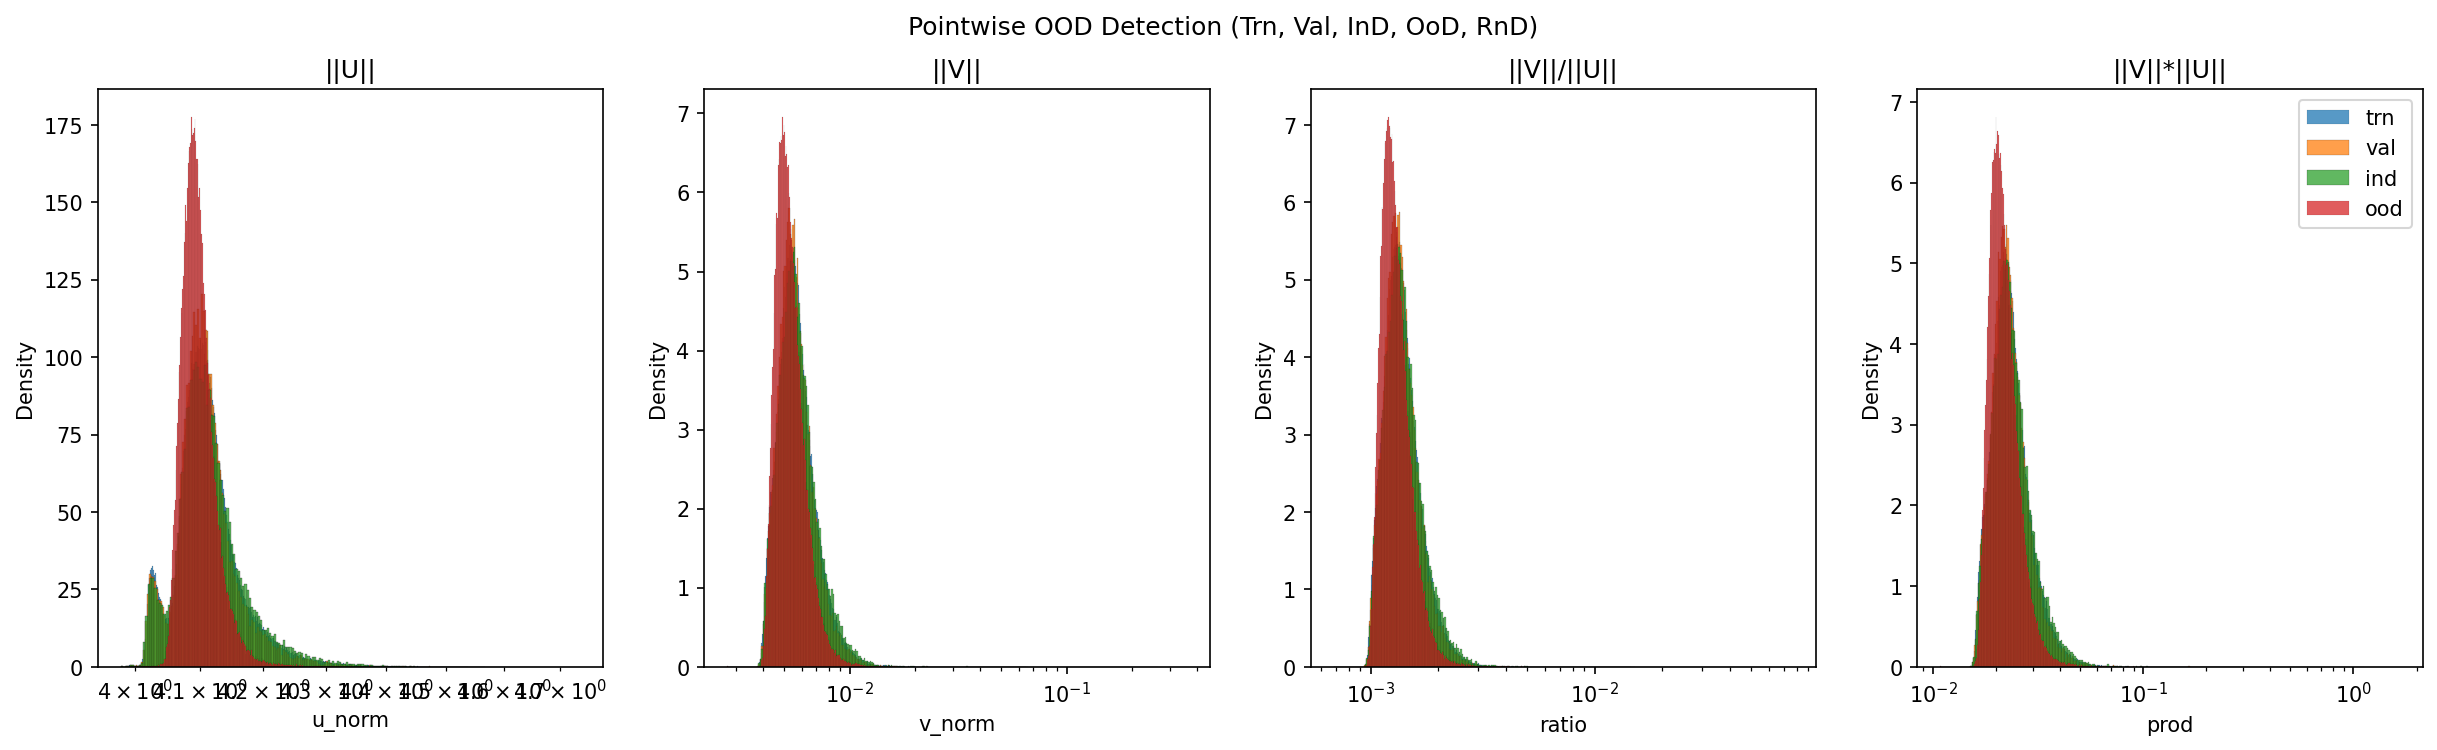

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 0.0027211218 0.2642364 0.26151526
Val 0.0027211218 0.066158004 0.06343688
Ind 0.0027211218 0.064717494 0.06199637
Ood 0.0027211218 0.35723323 0.3545121
Rnd 8.955595 12.002596 3.047001
KstestResult(statistic=0.19580640778177572, pvalue=0.0, statistic_location=0.0054295203, statistic_sign=-1)


[0 1 3 2 4]


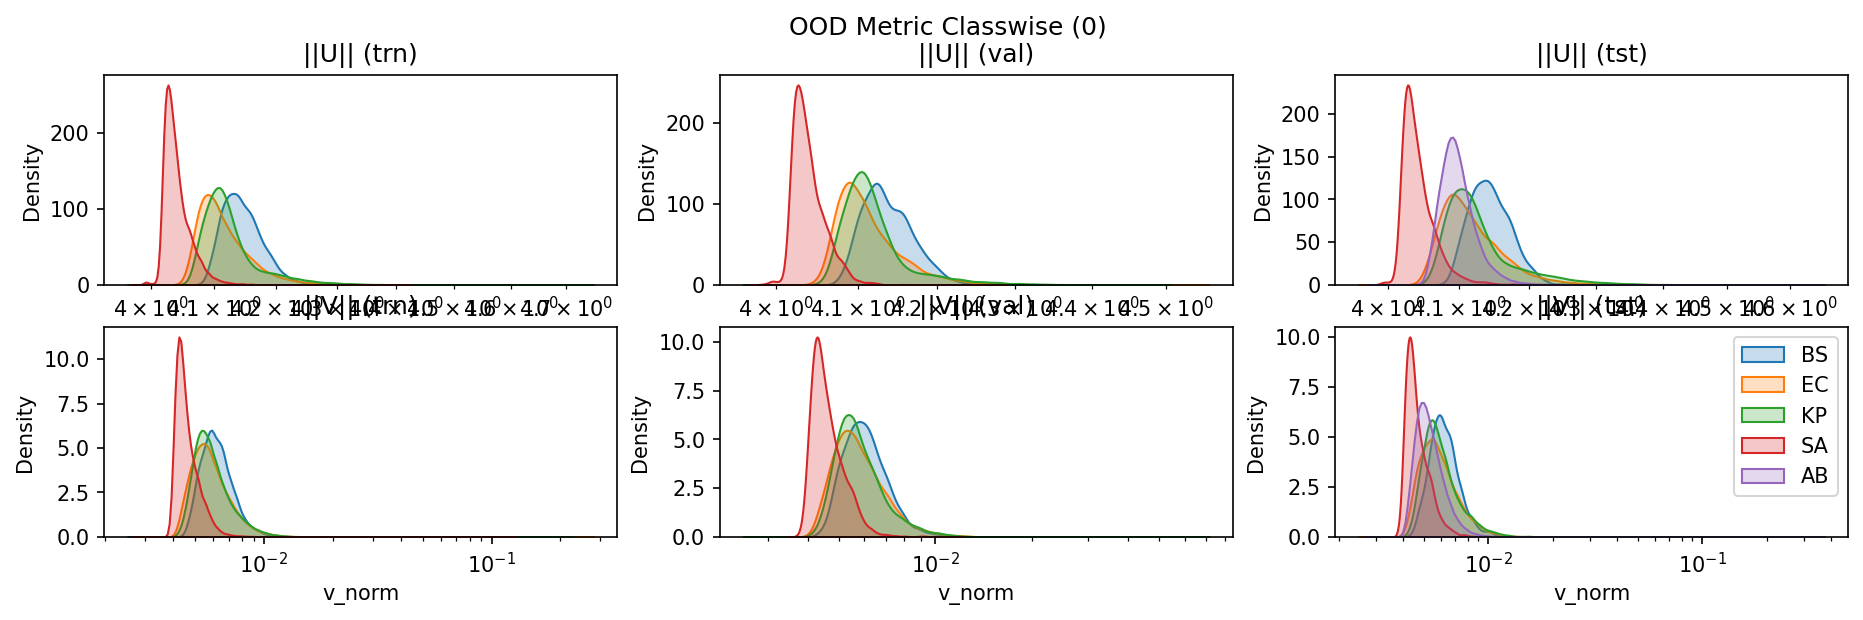

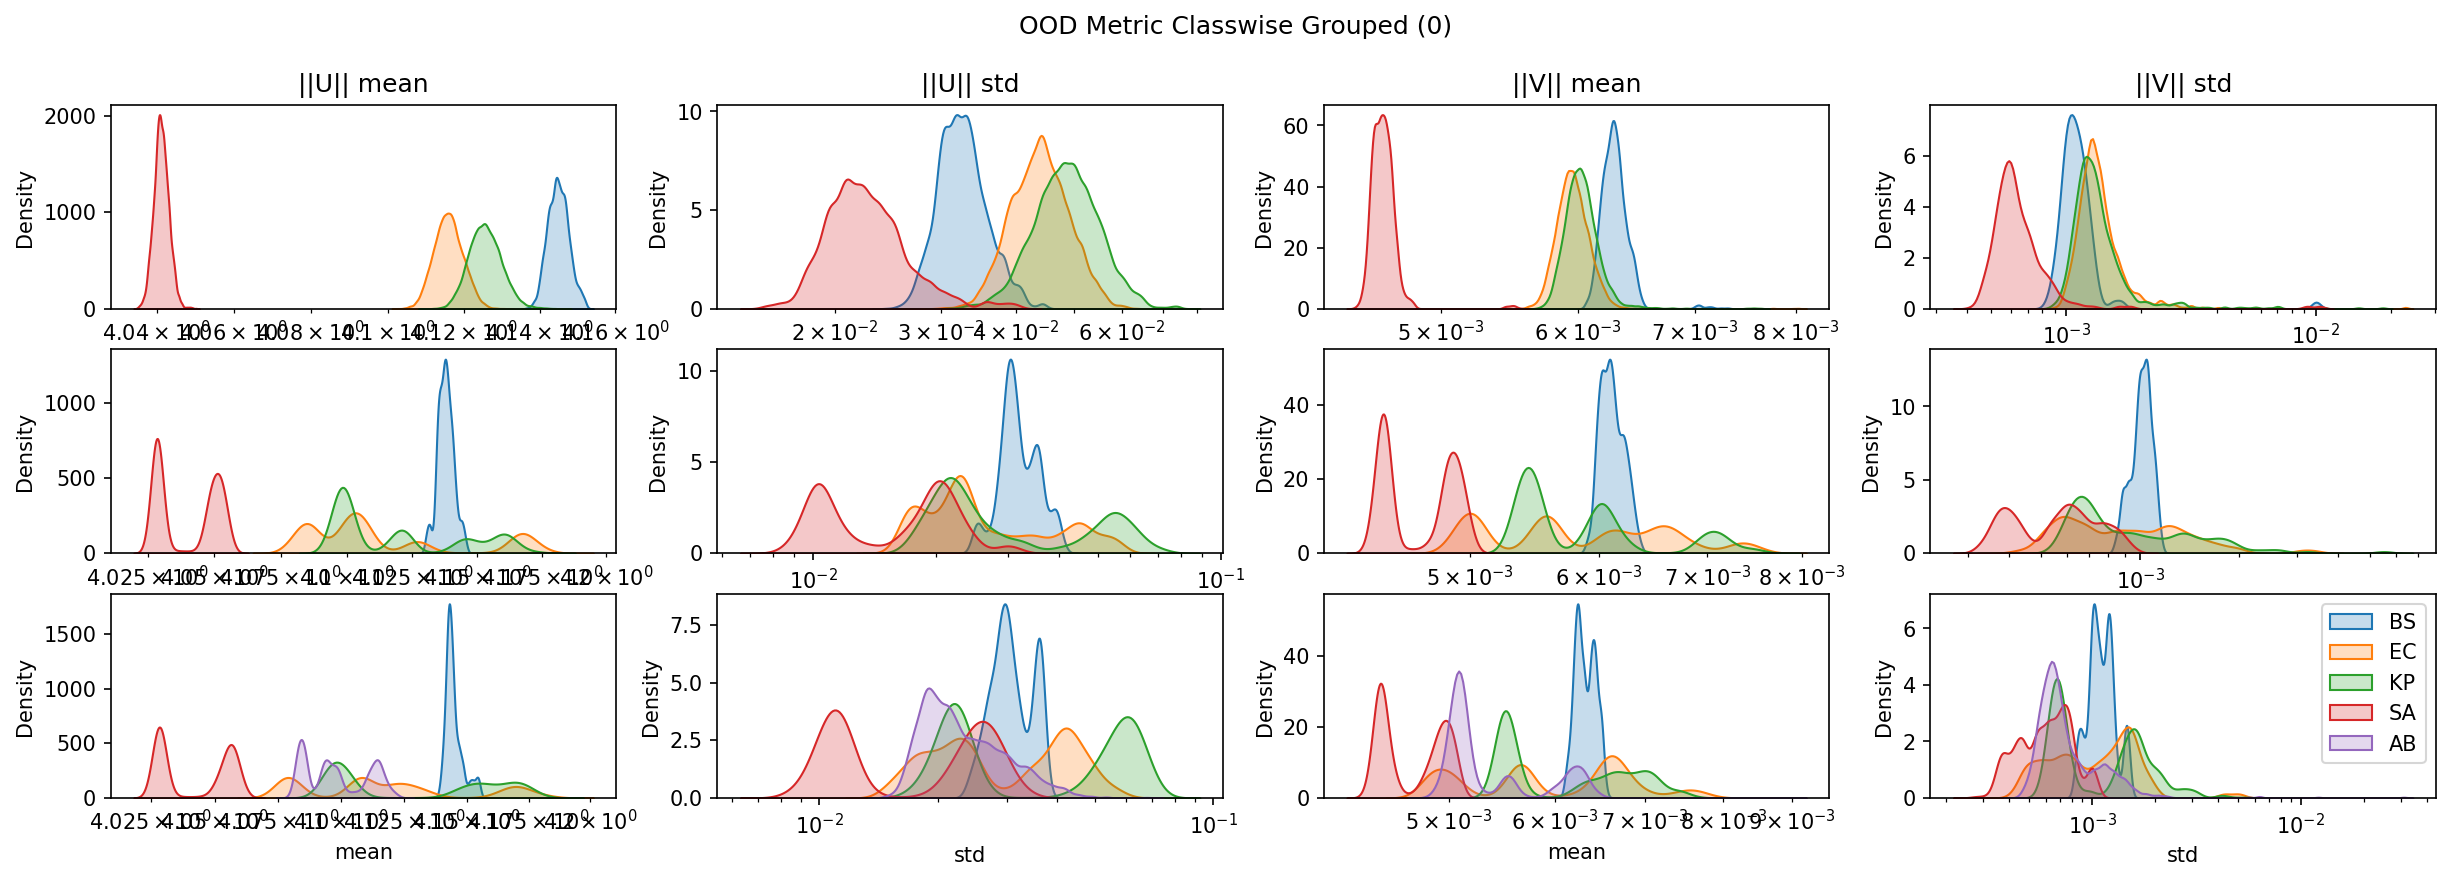

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)